In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import swifter
from tqdm import tqdm
import gc
pd.options.display.max_columns = None



In [2]:
def preprocessing_LETU(df):
    Y_var = df[['target','treat']]
    X_var = df.drop(['target','treat'], axis = 1)
    dataset = pd.DataFrame()
    ## Categorical to Vec
    dataset = pd.concat([dataset
                    , pd.get_dummies(X_var[['SEGMENT_N'
                                            ,	'SUB_EMAIL'
                                            , 'Тип карты'	
                                            , 'Канал регистрации'
                                            , 'NewComer']]
                                    )
                    ], axis = 1)
    X_var = X_var.drop(['SEGMENT_N'
                    ,'SUB_EMAIL'
                    , 'Тип карты'	
                    , 'Канал регистрации'
                    , 'NewComer'], axis =1)                    
    # dataset.head()

    ## Numeric preprocessing
    med = X_var['AGE'].median()
    dataset = pd.concat([dataset
                        , X_var['AGE'].apply(lambda x: x if((x >= 16) and (x <= 90)) else med).fillna(med)
                        ], axis=1)
    X_var = X_var.drop(['AGE'], axis =1)                     
    
    for_norm = ['lftm',	'AMOUNT'
            ,	'ORDERS'
            ,	'AOV'	
            ,'lftm_after_purch'
            ,'LTV_1M'
            , 'AO_per_month'
            , 'GET_Bonus'
            ,	'USE_Bonus'
            ,	'NON_SPEND_BONUS'
            ,	'BASE_GET_Bonus'
            ,	'BASE_USE_Bonus'
            ,	'Express_GET_Bonus'
            ,	'Express_USE_Bonus'
            ,	'Camp_GET_Bonus'
            ,	'REG_GET_Bonus'	
            , 'Camp_BASE_GET_Bonus'
            ,	'REG_BASE_GET_Bonus'
            , 'AVG_USE_BONUS'
            ,	'DISC_AMOUNT'
            ,	'DISC_ORDERS'
            , 'BASE_AVG_USE_BONUS'
            ,	'BASE_DISC_AMOUNT'
            ,	'BASE_DISC_ORDERS'
            , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS']

    x_means = X_var[for_norm].mean()
    x_std = X_var[for_norm].std()  
    x_v = X_var[for_norm].copy() 
    dataset = pd.concat([dataset
                    , (x_v - x_means).fillna(0) / x_std
                    ], axis = 1)
    X_var = X_var.drop(for_norm, axis =1)      

    dataset = pd.concat([dataset
                    , X_var.fillna(0)] , axis = 1)
    del X_var   
    gc.collect()
    return dataset, Y_var  



In [3]:
def preprocessing_LETU_without_norm(df):
    Y_var = df[['target','treat']]
    X_var = df.drop(['target','treat'], axis = 1)
    dataset = pd.DataFrame()
    ## Categorical to Vec
    dataset = pd.concat([dataset
                    , pd.get_dummies(X_var[['SEGMENT_N'
                                            ,	'SUB_EMAIL'
                                            , 'Тип карты'	
                                            , 'Канал регистрации'
                                            , 'NewComer']]
                                    )
                    ], axis = 1)
    X_var = X_var.drop(['SEGMENT_N'
                    ,'SUB_EMAIL'
                    , 'Тип карты'	
                    , 'Канал регистрации'
                    , 'NewComer'], axis =1)                    
    # dataset.head()

    ## Numeric preprocessing
    med = X_var['AGE'].median()
    dataset = pd.concat([dataset
                        , X_var['AGE'].apply(lambda x: x if((x >= 16) and (x <= 90)) else med).fillna(med)
                        ], axis=1)
    X_var = X_var.drop(['AGE'], axis =1)                     
    
    for_norm = ['lftm',	'AMOUNT'
            ,	'ORDERS'
            ,	'AOV'	
            ,'lftm_after_purch'
            ,'LTV_1M'
            , 'AO_per_month'
            , 'GET_Bonus'
            ,	'USE_Bonus'
            ,	'NON_SPEND_BONUS'
            ,	'BASE_GET_Bonus'
            ,	'BASE_USE_Bonus'
            ,	'Express_GET_Bonus'
            ,	'Express_USE_Bonus'
            ,	'Camp_GET_Bonus'
            ,	'REG_GET_Bonus'	
            , 'Camp_BASE_GET_Bonus'
            ,	'REG_BASE_GET_Bonus'
            , 'AVG_USE_BONUS'
            ,	'DISC_AMOUNT'
            ,	'DISC_ORDERS'
            , 'BASE_AVG_USE_BONUS'
            ,	'BASE_DISC_AMOUNT'
            ,	'BASE_DISC_ORDERS'
            , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS']


    x_v = X_var[for_norm].copy() 
    dataset = pd.concat([dataset
                    , x_v.fillna(0)
                    ], axis = 1)
    X_var = X_var.drop(for_norm, axis =1)      

    dataset = pd.concat([dataset
                    , X_var.fillna(0)] , axis = 1)
    del X_var   
    gc.collect()
    return dataset, Y_var  



# Базовая модель

In [3]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 

C:\Users\Kirill\AppData\Local\Temp\ipykernel_12088\1962451926.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


NewComer  SEGMENT_N_1  SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  \
7709046080         0            1            0            0            0   
7717101223         0            1            0            0            0   
7712715957         0            1            0            0            0   
7710968936         0            0            0            1            0   
7700742104         0            0            0            1            0   

            SEGMENT_N_5  SEGMENT_N_6  SEGMENT_N_8  SUB_EMAIL_Да  \
7709046080            0            0            0             1   
7717101223            0            0            0             1   
7712715957            0            0            0             0   
7710968936            0            0            0             1   
7700742104            0            0            0             1   

            SUB_EMAIL_Нет  Тип карты_Без возможности оплаты  \
7709046080              0                                 0   
7717101223              0                                 0   
7712715957              1                                 0   
7710968936              0                                 0   
7700742104              0                                 0   

            Тип карты_Как карточное платежное средство  \
7709046080                                           1   
7717101223                                           1   
7712715957                                           1   
7710968936                                           1   
7700742104                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7709046080                        1                          0  16.0   
7717101223                        1                          0  36.0   
7712715957                        1                          0  32.0   
7710968936                        1                          0  33.0   
7700742104                        1                          0  35.0   

                lftm    AMOUNT    ORDERS       AOV  lftm_after_purch  \
7709046080 -1.212281 -0.600401 -0.443194 -0.685838         -1.132995   
7717101223  0.826398 -0.462569 -0.443194 -0.433224          0.968922   
7712715957  1.069822 -0.624574 -0.443194 -0.730142         -1.196690   
7710968936 -0.086443 -0.245613 -0.443194 -0.035592         -1.610704   
7700742104  0.765542 -0.449705  0.938950 -0.681531          0.809685   

              LTV_1M  AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7709046080 -0.523763      0.333584  -0.353530  -0.546141         0.339303   
7717101223 -0.527795     -0.729638  -0.291854   0.130118        -0.552748   
7712715957 -0.574041      0.333584  -0.365865   0.000000         0.000000   
7710968936  0.214172      0.333584  -0.217843   0.130118        -0.496408   
7700742104 -0.518876      0.333584   2.785775   1.553644        -0.186538   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7709046080       -0.396474        0.000000                0.0   
7717101223       -0.308987        0.000000                0.0   
7712715957       -0.413971        0.000000                0.0   
7710968936       -0.204004        0.000000                0.0   
7700742104        4.056583        1.561972                0.0   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7709046080          -0.608796             0.0      -0.600477   
7717101223           0.185893             0.0      -0.428430   
7712715957           0.000000             0.0      -0.634887   
7710968936           0.185893             0.0      -0.221974   
7700742104           0.185893             0.0      -0.445635   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS  \
7709046080                  0.0           -0.600477      -0.439705   
7717101223                  0.0           -0.428430       0.709397   
7712715957                  0.0           -0.634887       0.000000   
7710968936                  0.0        

target  treat
7709046080       0      0
7717101223       0      0
7712715957       1      0
7710968936       0      0
7700742104       0      0

WAU = 0.009048420192708254; UpLift at 30% 0.008097225628794336


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


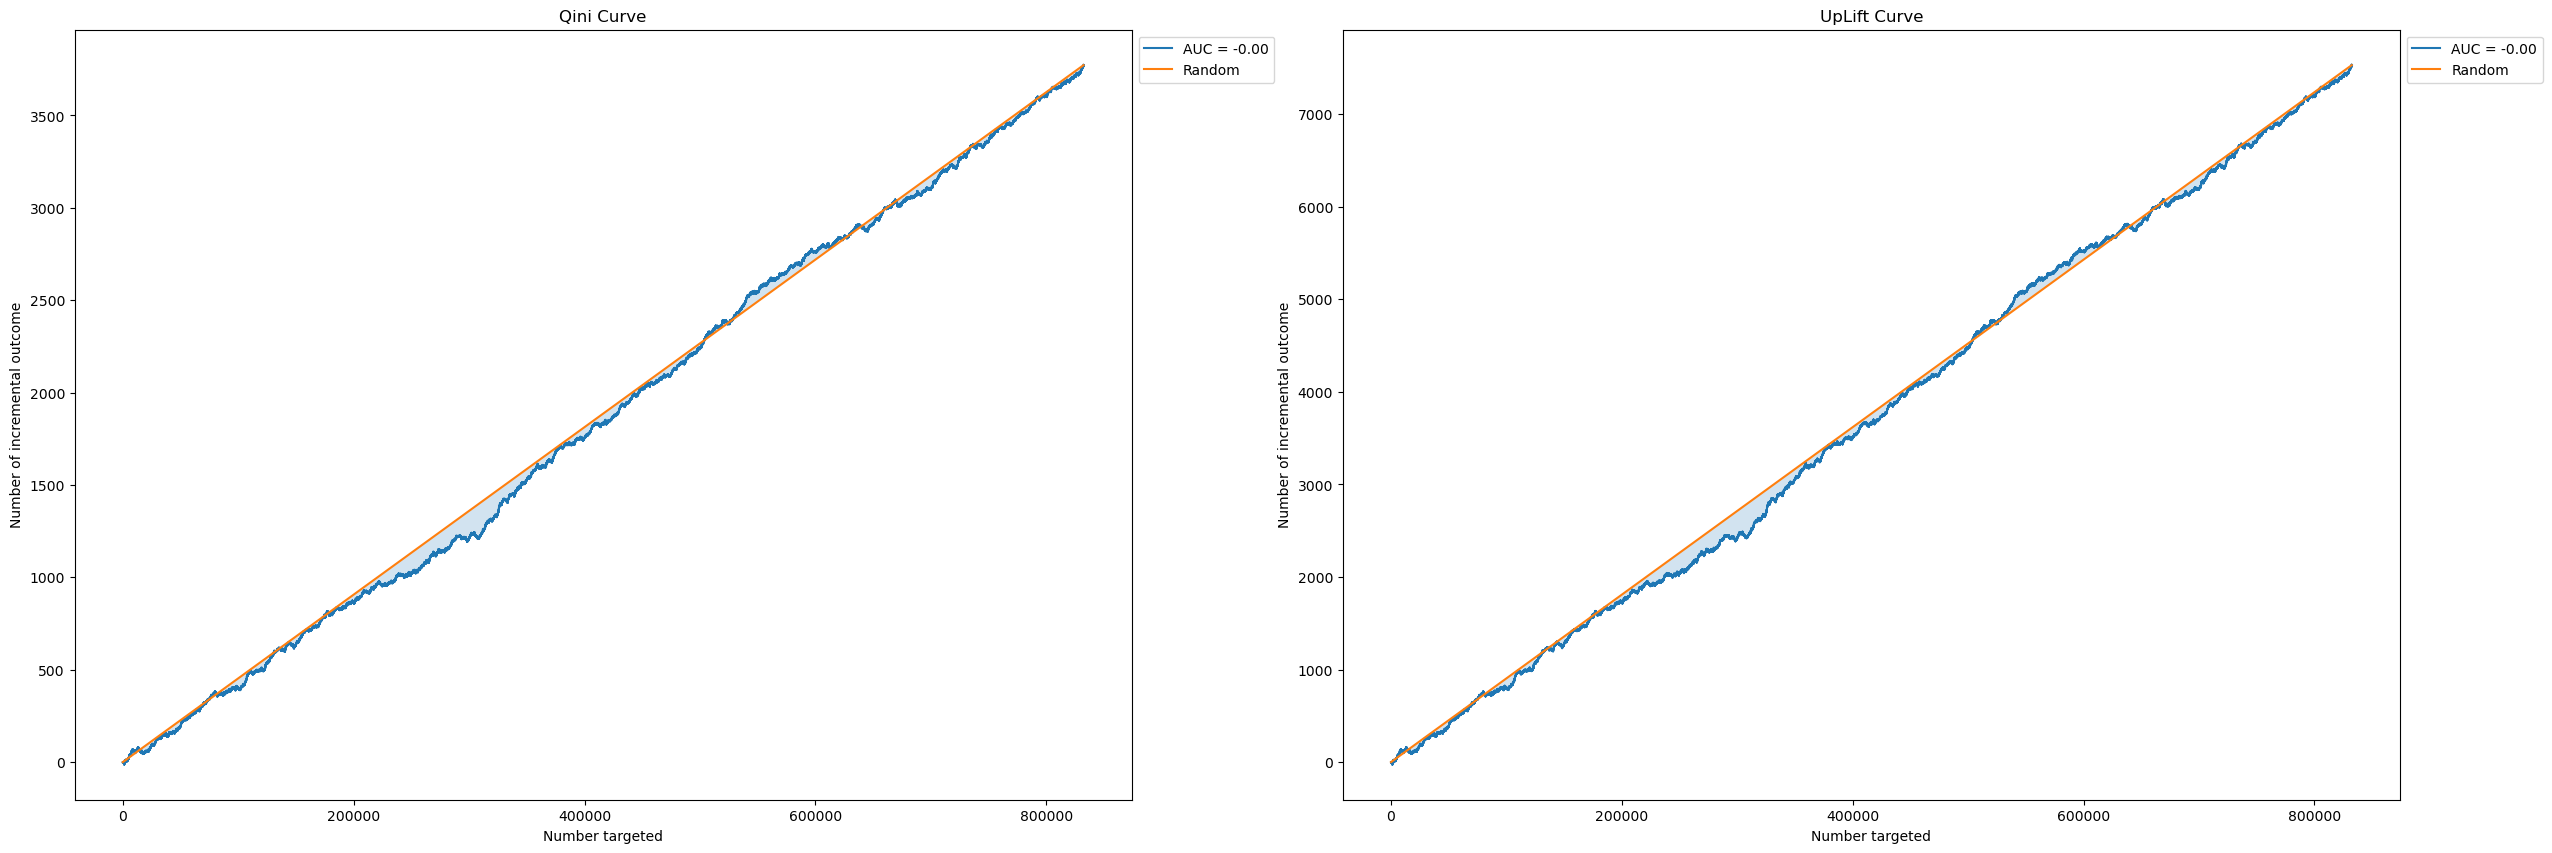

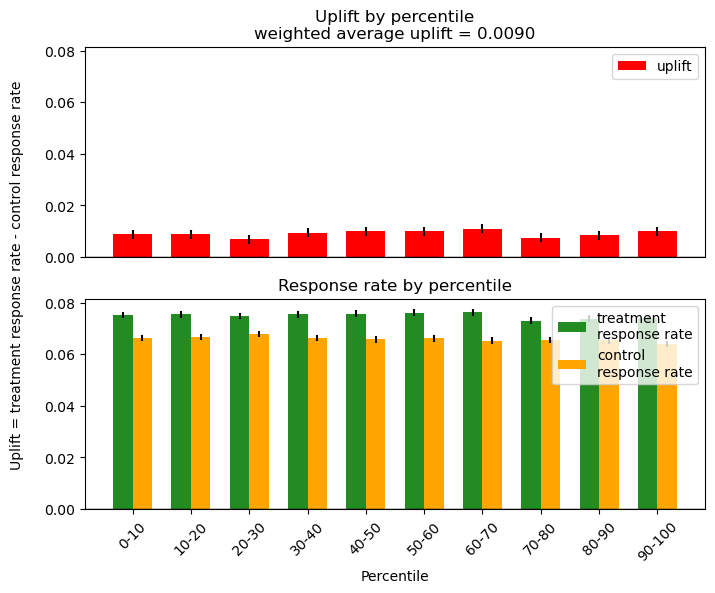

In [4]:
treat = Y_data.treat.values
y = Y_data.target.values

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


y_pred = np.random.uniform(-1, 1, len(treat)).tolist()
gc.collect()
wau = weighted_average_uplift(y_true=y , uplift=y_pred,
                        treatment=treat)
uplift_overall = uplift_at_k(y_true=y , uplift=y_pred,
                        treatment=treat, strategy='by_group', k=0.3)

print(f'WAU = {wau}; UpLift at 30% {uplift_overall}')
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax[0].set_title('Qini Curve')
ax[1].set_title('UpLift Curve')
plot_qini_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[0], perfect=False)
gc.collect()
plot_uplift_curve(y_true=y , uplift=y_pred,
                        treatment=treat, ax = ax[1], perfect=False)
gc.collect()
gc.collect()
gc.collect()
plt.savefig(f"Plots/Base model Split.png")

plot_uplift_by_percentile(y_true=y , uplift=y_pred,
                        treatment=treat, kind='bar')
plt.savefig(f"Plots/Base model Procentile.png")






In [5]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

8227

# Метод одной модели

In [6]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = Y_data.treat.values
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target.values
gc.collect()

C:\Users\Kirill\AppData\Local\Temp\ipykernel_12088\1962451926.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


NewComer  SEGMENT_N_1  SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  \
7709046080         0            1            0            0            0   
7717101223         0            1            0            0            0   
7712715957         0            1            0            0            0   
7710968936         0            0            0            1            0   
7700742104         0            0            0            1            0   

            SEGMENT_N_5  SEGMENT_N_6  SEGMENT_N_8  SUB_EMAIL_Да  \
7709046080            0            0            0             1   
7717101223            0            0            0             1   
7712715957            0            0            0             0   
7710968936            0            0            0             1   
7700742104            0            0            0             1   

            SUB_EMAIL_Нет  Тип карты_Без возможности оплаты  \
7709046080              0                                 0   
7717101223              0                                 0   
7712715957              1                                 0   
7710968936              0                                 0   
7700742104              0                                 0   

            Тип карты_Как карточное платежное средство  \
7709046080                                           1   
7717101223                                           1   
7712715957                                           1   
7710968936                                           1   
7700742104                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7709046080                        1                          0  16.0   
7717101223                        1                          0  36.0   
7712715957                        1                          0  32.0   
7710968936                        1                          0  33.0   
7700742104                        1                          0  35.0   

                lftm    AMOUNT    ORDERS       AOV  lftm_after_purch  \
7709046080 -1.212281 -0.600401 -0.443194 -0.685838         -1.132995   
7717101223  0.826398 -0.462569 -0.443194 -0.433224          0.968922   
7712715957  1.069822 -0.624574 -0.443194 -0.730142         -1.196690   
7710968936 -0.086443 -0.245613 -0.443194 -0.035592         -1.610704   
7700742104  0.765542 -0.449705  0.938950 -0.681531          0.809685   

              LTV_1M  AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7709046080 -0.523763      0.333584  -0.353530  -0.546141         0.339303   
7717101223 -0.527795     -0.729638  -0.291854   0.130118        -0.552748   
7712715957 -0.574041      0.333584  -0.365865   0.000000         0.000000   
7710968936  0.214172      0.333584  -0.217843   0.130118        -0.496408   
7700742104 -0.518876      0.333584   2.785775   1.553644        -0.186538   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7709046080       -0.396474        0.000000                0.0   
7717101223       -0.308987        0.000000                0.0   
7712715957       -0.413971        0.000000                0.0   
7710968936       -0.204004        0.000000                0.0   
7700742104        4.056583        1.561972                0.0   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7709046080          -0.608796             0.0      -0.600477   
7717101223           0.185893             0.0      -0.428430   
7712715957           0.000000             0.0      -0.634887   
7710968936           0.185893             0.0      -0.221974   
7700742104           0.185893             0.0      -0.445635   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS  \
7709046080                  0.0           -0.600477      -0.439705   
7717101223                  0.0           -0.428430       0.709397   
7712715957                  0.0           -0.634887       0.000000   
7710968936                  0.0        

target  treat
7709046080       0      0
7717101223       0      0
7712715957       1      0
7710968936       0      0
7700742104       0      0

In [8]:
t_0 = np.argwhere(treat == 0)
t_1 = np.argwhere(treat == 1)
y_c = y[t_0]
len(y_c[y_c == 1]) / len(y_c)

0.06588882254367548

In [9]:
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt



Split 1; WAU = 0.01024431737751701; UpLift at 30% 0.015487381269761305


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.008324924980468636; UpLift at 30% 0.007485847249942404


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.008958561417045883; UpLift at 30% 0.007328441950992255


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.009804202780209978; UpLift at 30% 0.010972907772349327


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.006843951941932496; UpLift at 30% 0.0057875122423113184


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0088; Mean UpLift 30% = 0.0094


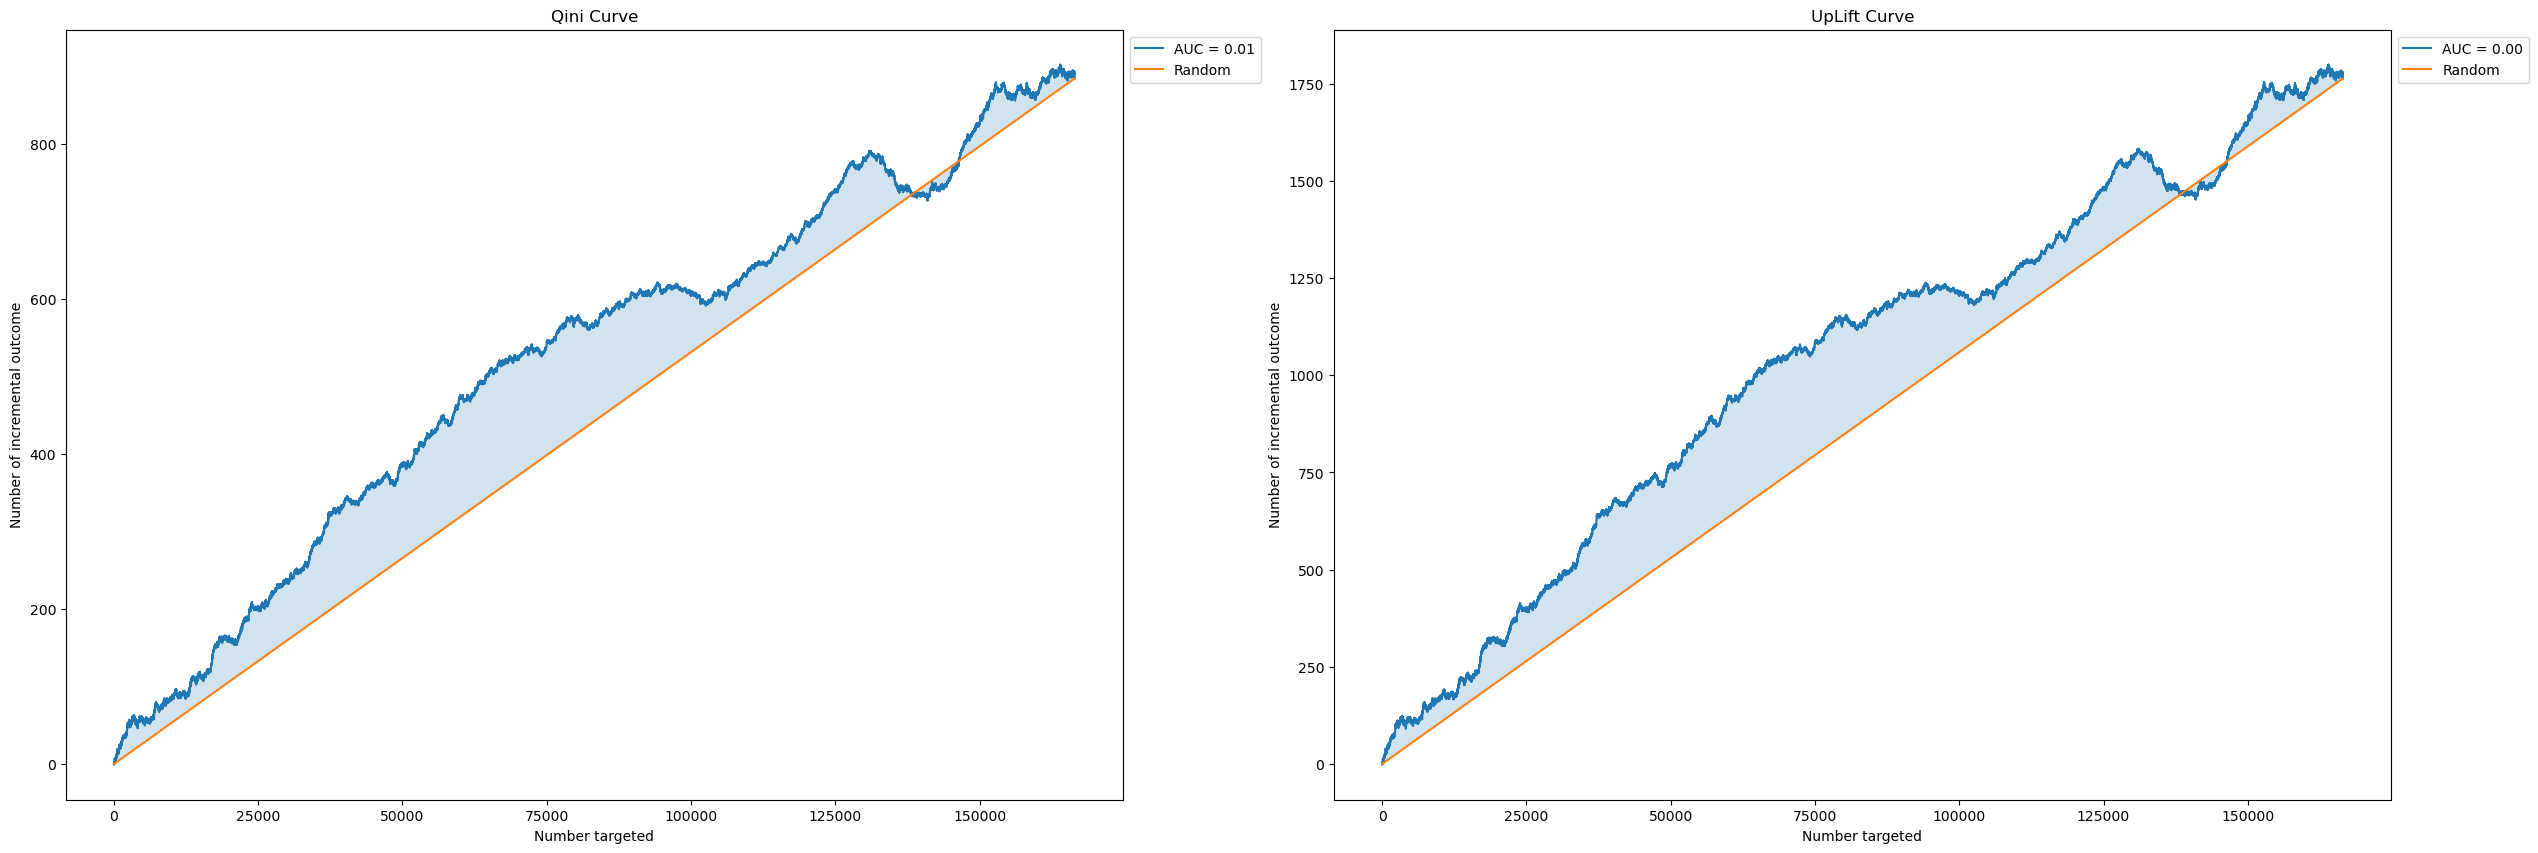

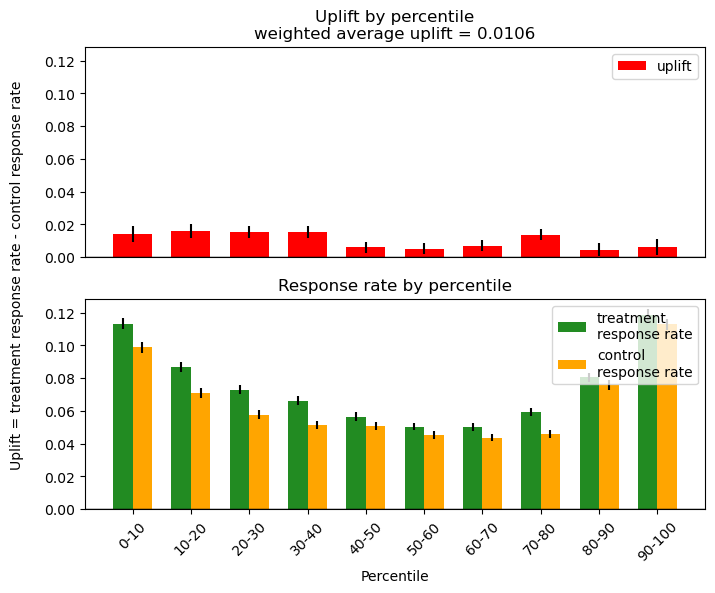

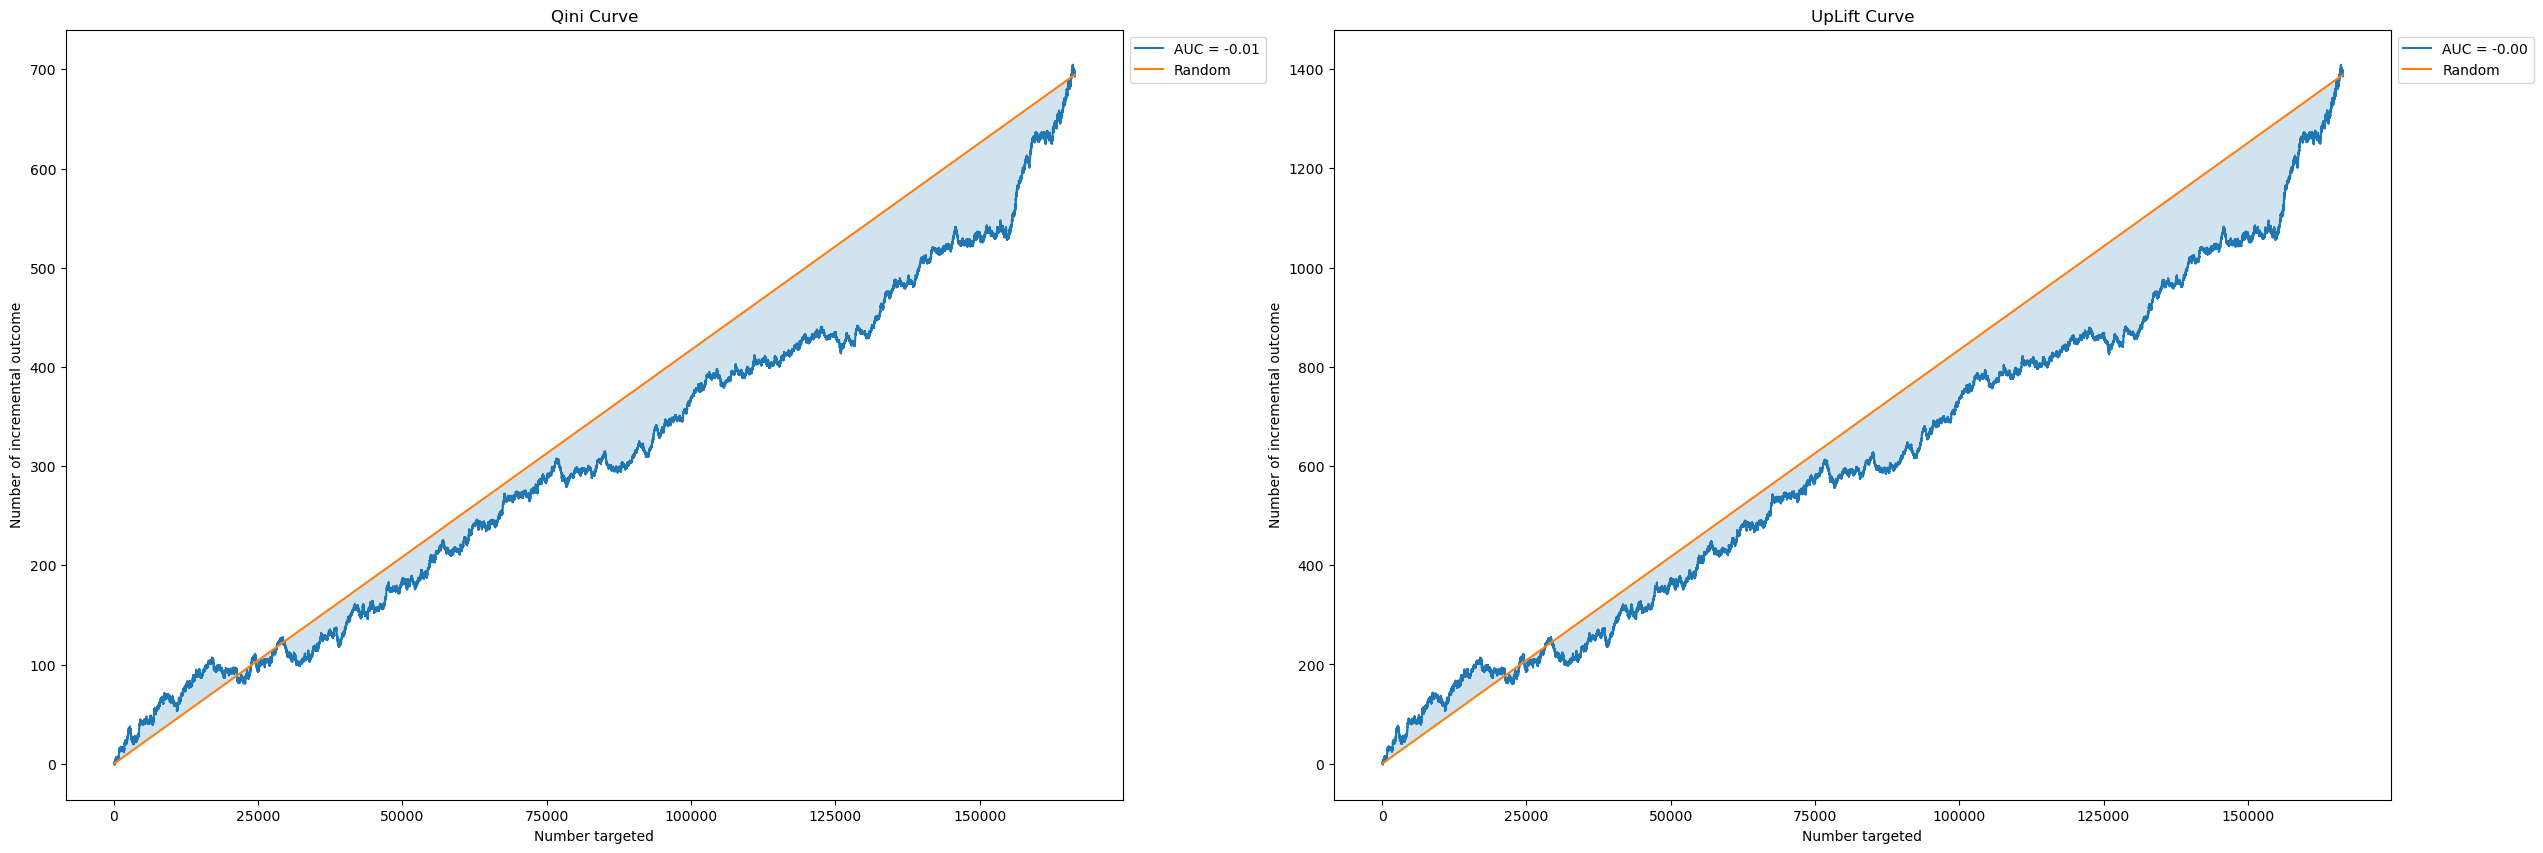

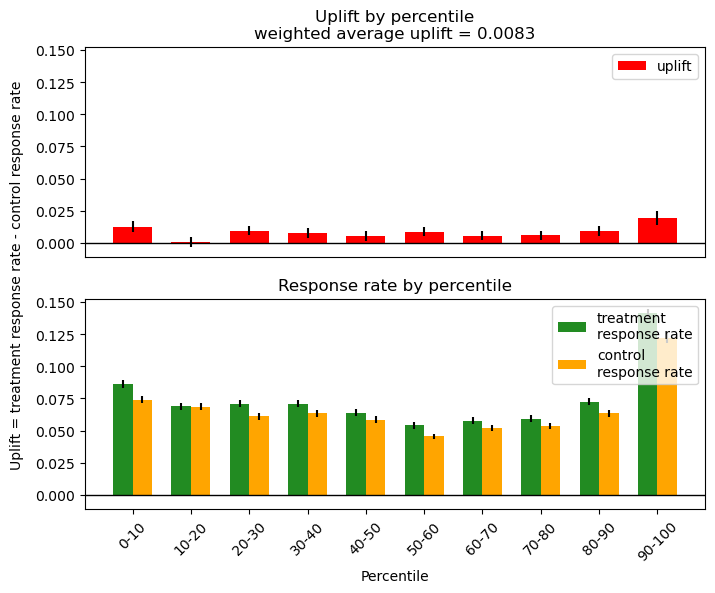

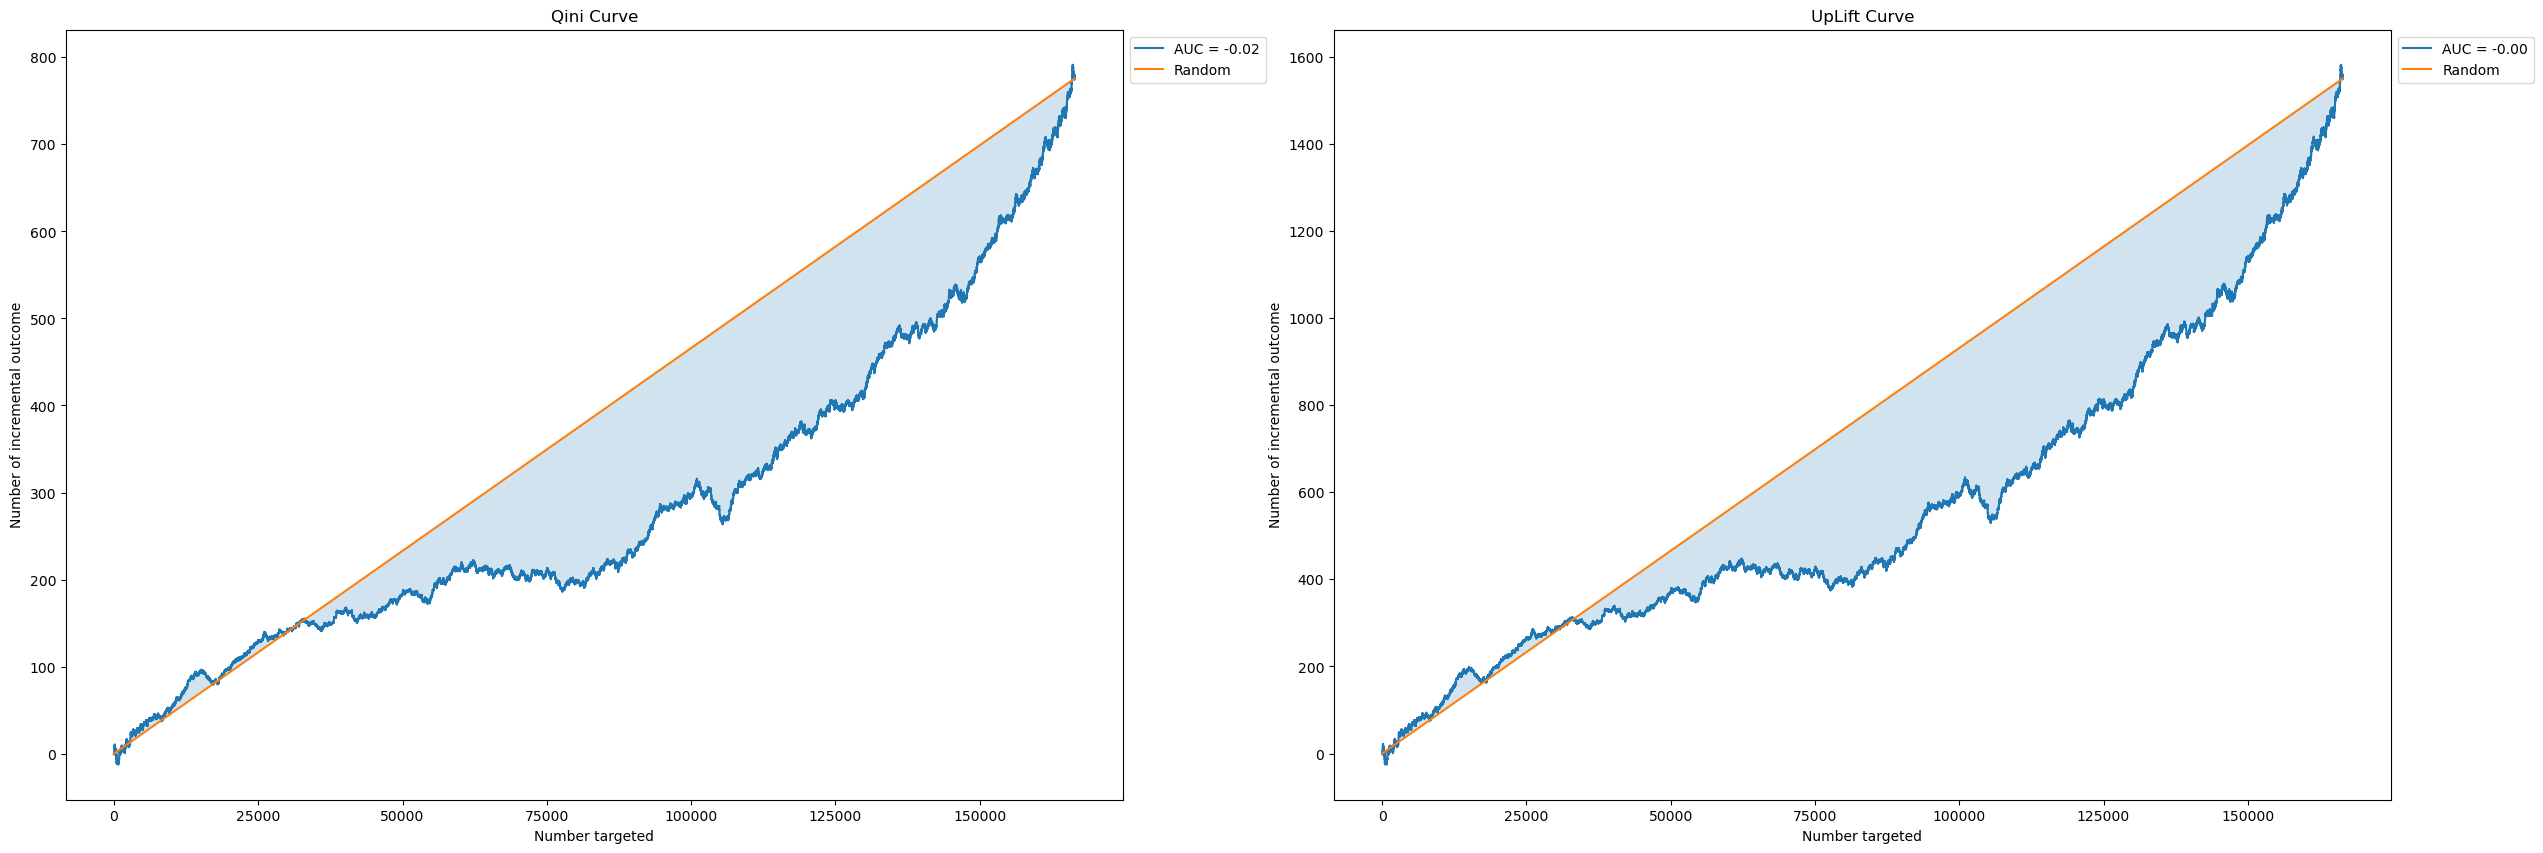

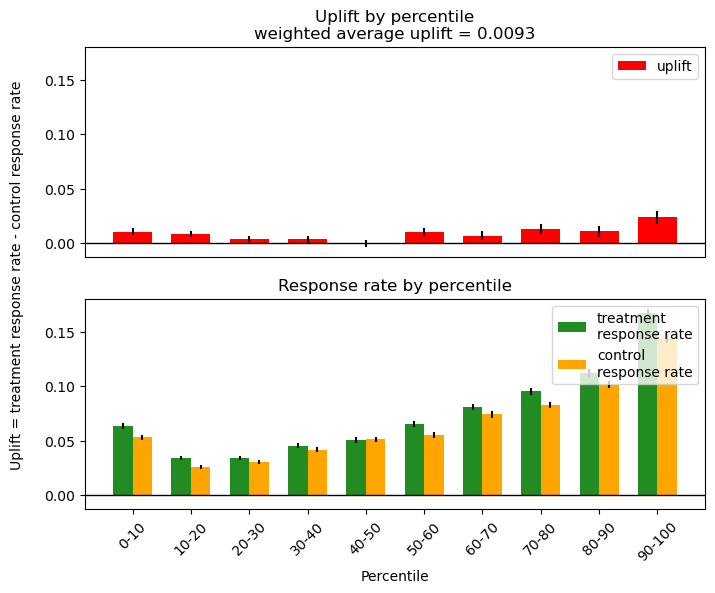

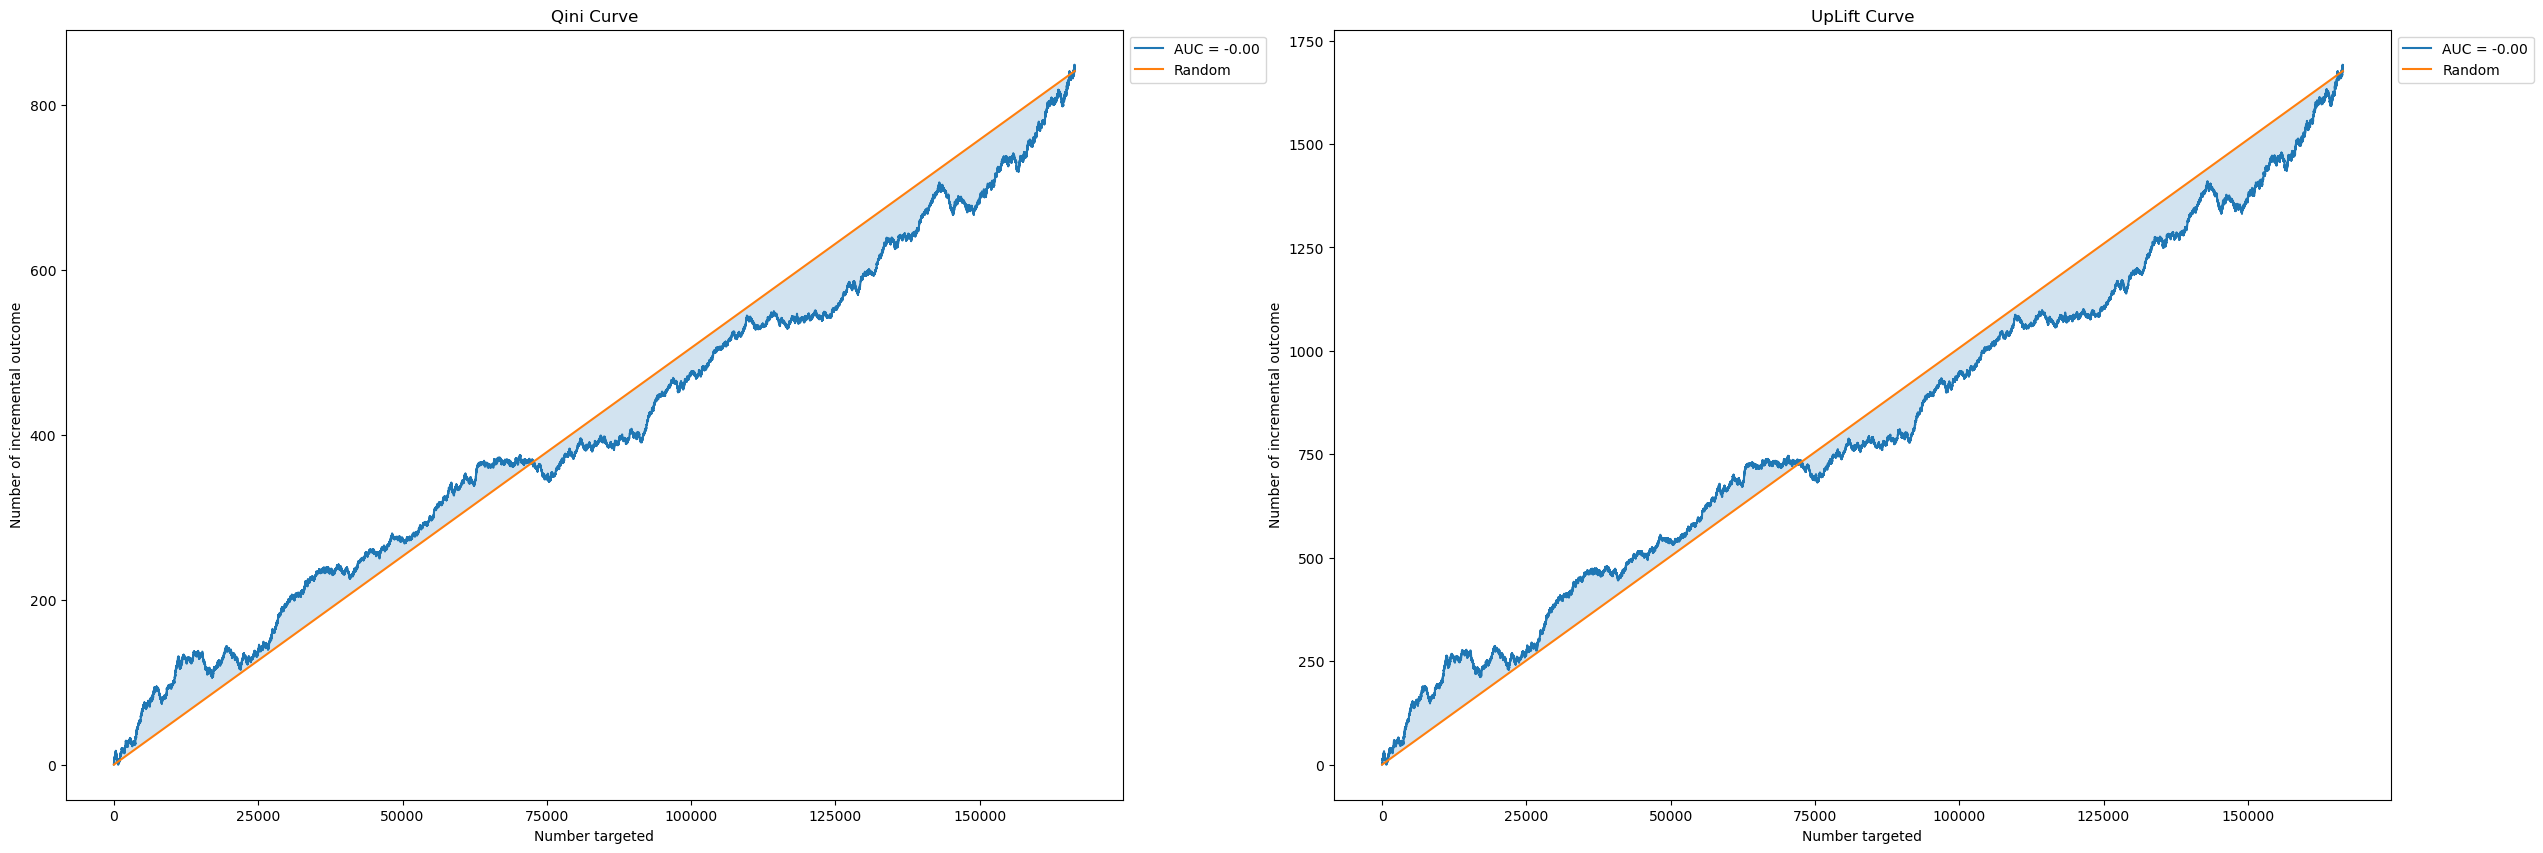

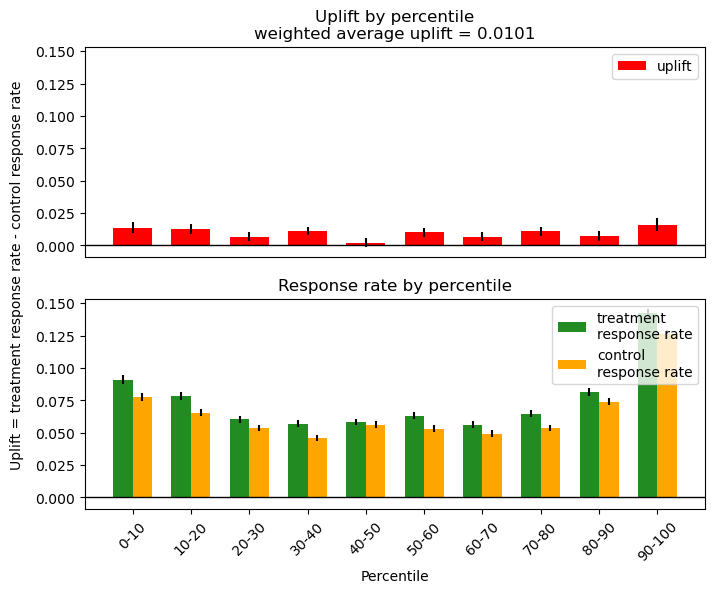

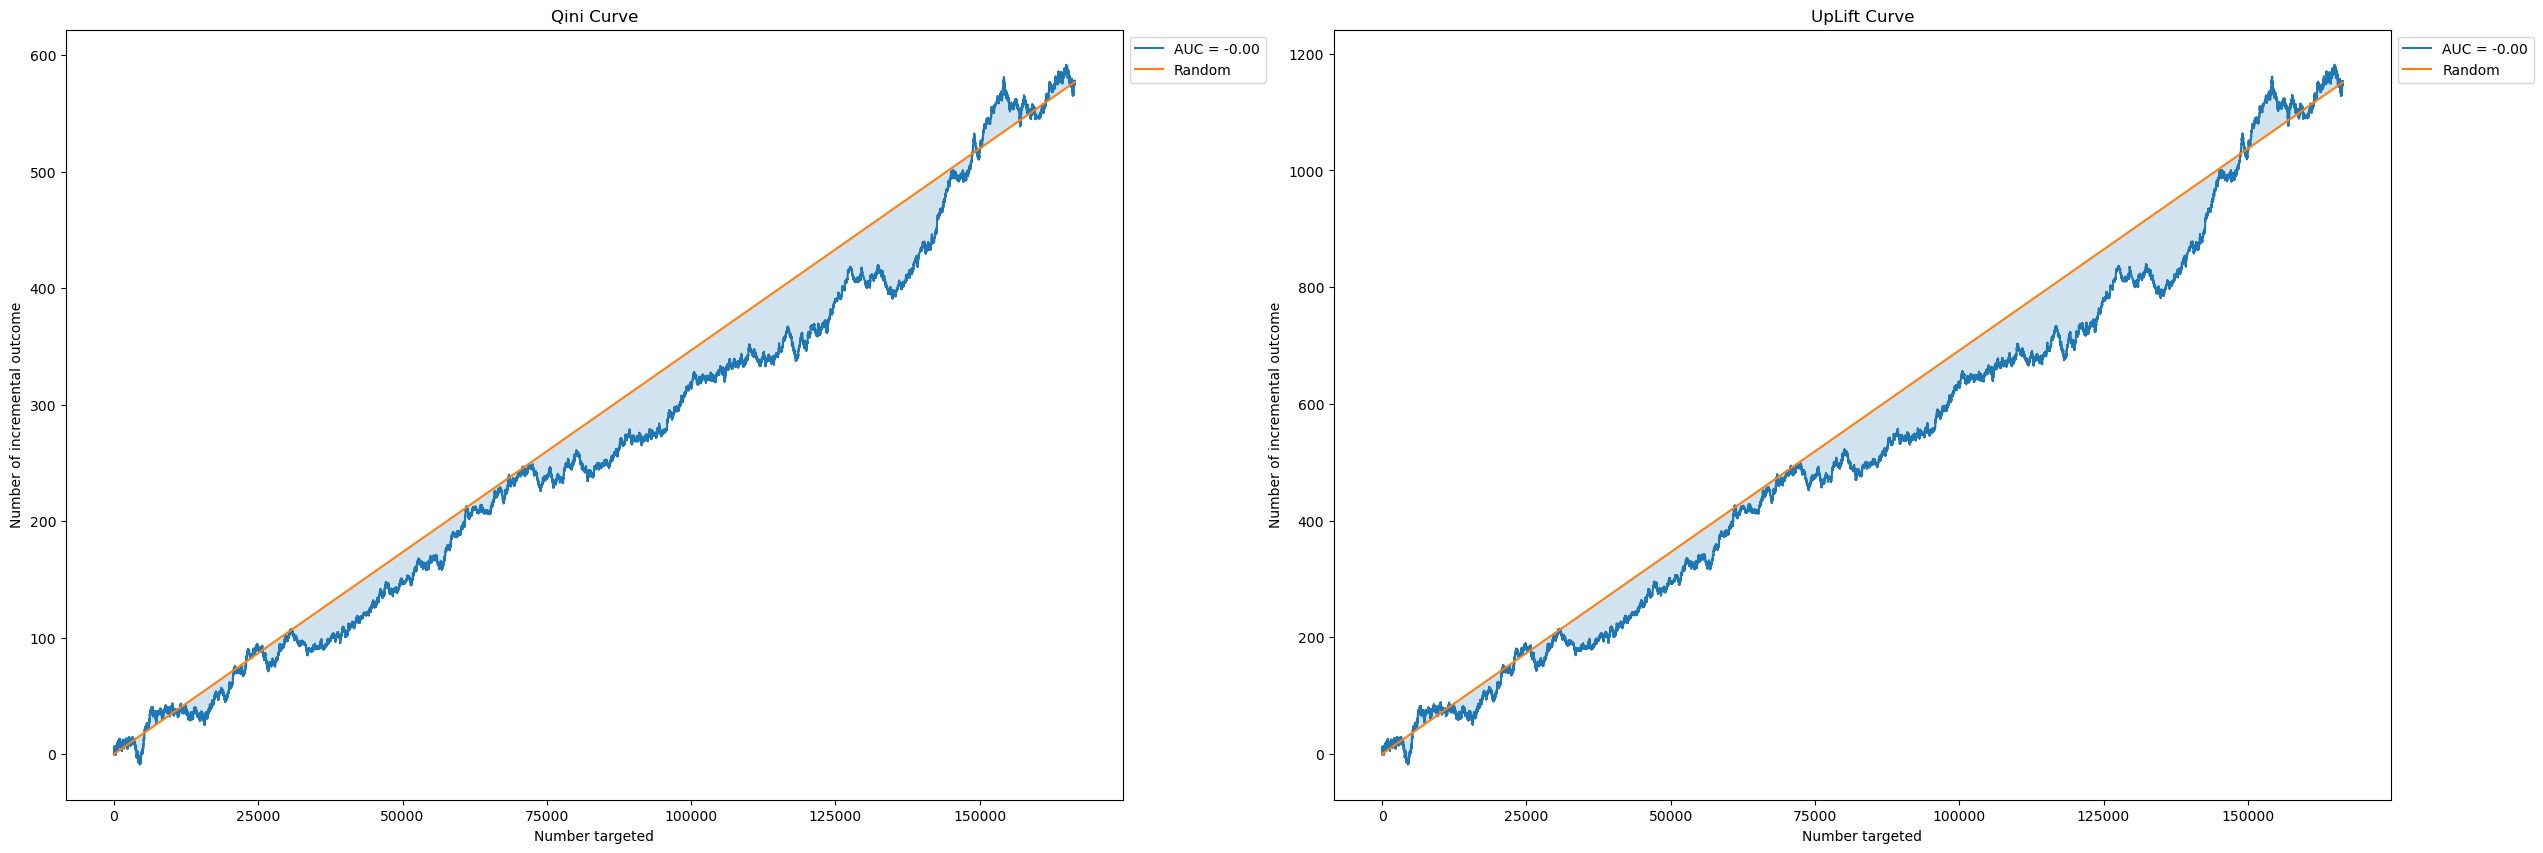

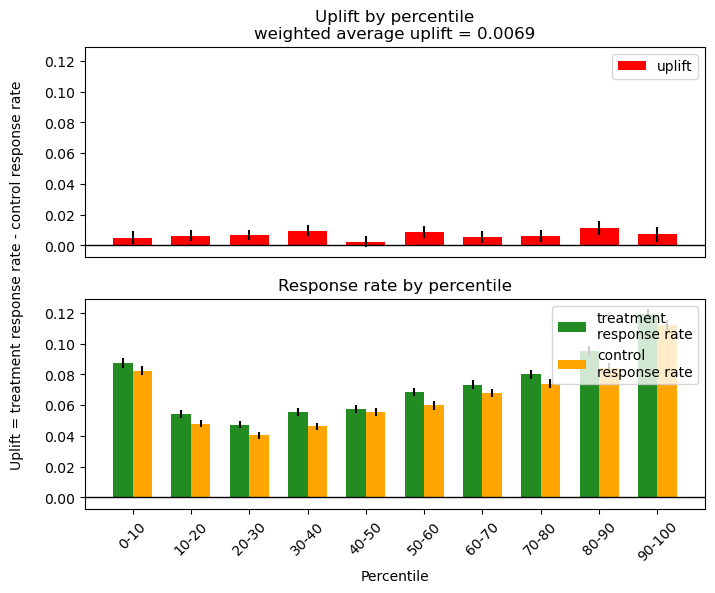

In [10]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      clf = CatBoostClassifier(verbose = 0)
      clf.fit(X_train_, y_train_)
      X_test_[:, -1] = 1#np.ones(len(test_index))
      y_pred1 = clf.predict_proba(X_test_).T[1]
      X_test_[:, -1] = 0#np.ones(len(test_index))
      y_pred0 = clf.predict_proba(X_test_).T[1]
      y_pred = y_pred1 - y_pred0
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/One model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/One model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

In [11]:
wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

Mean WAU = 0.0088; Mean UpLift 30% = 0.0094


In [12]:
gc.collect()

70928

In [14]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

0

# Метод двух моделей

In [15]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
treat = Y_data.treat.values
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target.values
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







C:\Users\Kirill\AppData\Local\Temp\ipykernel_12088\2601922837.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


NewComer  SEGMENT_N_1  SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  \
7709046080         0            1            0            0            0   
7717101223         0            1            0            0            0   
7712715957         0            1            0            0            0   
7710968936         0            0            0            1            0   
7700742104         0            0            0            1            0   

            SEGMENT_N_5  SEGMENT_N_6  SEGMENT_N_8  SUB_EMAIL_Да  \
7709046080            0            0            0             1   
7717101223            0            0            0             1   
7712715957            0            0            0             0   
7710968936            0            0            0             1   
7700742104            0            0            0             1   

            SUB_EMAIL_Нет  Тип карты_Без возможности оплаты  \
7709046080              0                                 0   
7717101223              0                                 0   
7712715957              1                                 0   
7710968936              0                                 0   
7700742104              0                                 0   

            Тип карты_Как карточное платежное средство  \
7709046080                                           1   
7717101223                                           1   
7712715957                                           1   
7710968936                                           1   
7700742104                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7709046080                        1                          0  16.0   
7717101223                        1                          0  36.0   
7712715957                        1                          0  32.0   
7710968936                        1                          0  33.0   
7700742104                        1                          0  35.0   

                lftm    AMOUNT    ORDERS       AOV  lftm_after_purch  \
7709046080 -1.212281 -0.600401 -0.443194 -0.685838         -1.132995   
7717101223  0.826398 -0.462569 -0.443194 -0.433224          0.968922   
7712715957  1.069822 -0.624574 -0.443194 -0.730142         -1.196690   
7710968936 -0.086443 -0.245613 -0.443194 -0.035592         -1.610704   
7700742104  0.765542 -0.449705  0.938950 -0.681531          0.809685   

              LTV_1M  AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7709046080 -0.523763      0.333584  -0.353530  -0.546141         0.339303   
7717101223 -0.527795     -0.729638  -0.291854   0.130118        -0.552748   
7712715957 -0.574041      0.333584  -0.365865   0.000000         0.000000   
7710968936  0.214172      0.333584  -0.217843   0.130118        -0.496408   
7700742104 -0.518876      0.333584   2.785775   1.553644        -0.186538   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7709046080       -0.396474        0.000000                0.0   
7717101223       -0.308987        0.000000                0.0   
7712715957       -0.413971        0.000000                0.0   
7710968936       -0.204004        0.000000                0.0   
7700742104        4.056583        1.561972                0.0   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7709046080          -0.608796             0.0      -0.600477   
7717101223           0.185893             0.0      -0.428430   
7712715957           0.000000             0.0      -0.634887   
7710968936           0.185893             0.0      -0.221974   
7700742104           0.185893             0.0      -0.445635   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS  \
7709046080                  0.0           -0.600477      -0.439705   
7717101223                  0.0           -0.428430       0.709397   
7712715957                  0.0           -0.634887       0.000000   
7710968936                  0.0        

target  treat
7709046080       0      0
7717101223       0      0
7712715957       1      0
7710968936       0      0
7700742104       0      0

Split 1; WAU = 0.010264018504577595; UpLift 30% 0.017094921883363562


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.008362749858370664; UpLift 30% 0.012918225387217097


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.008953465853569239; UpLift 30% 0.011759567946222654


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.009630034265416882; UpLift 30% 0.015724302896788944


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.006771973817167191; UpLift 30% 0.009420667336748373


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0088; Mean UpLift 30% = 0.0134


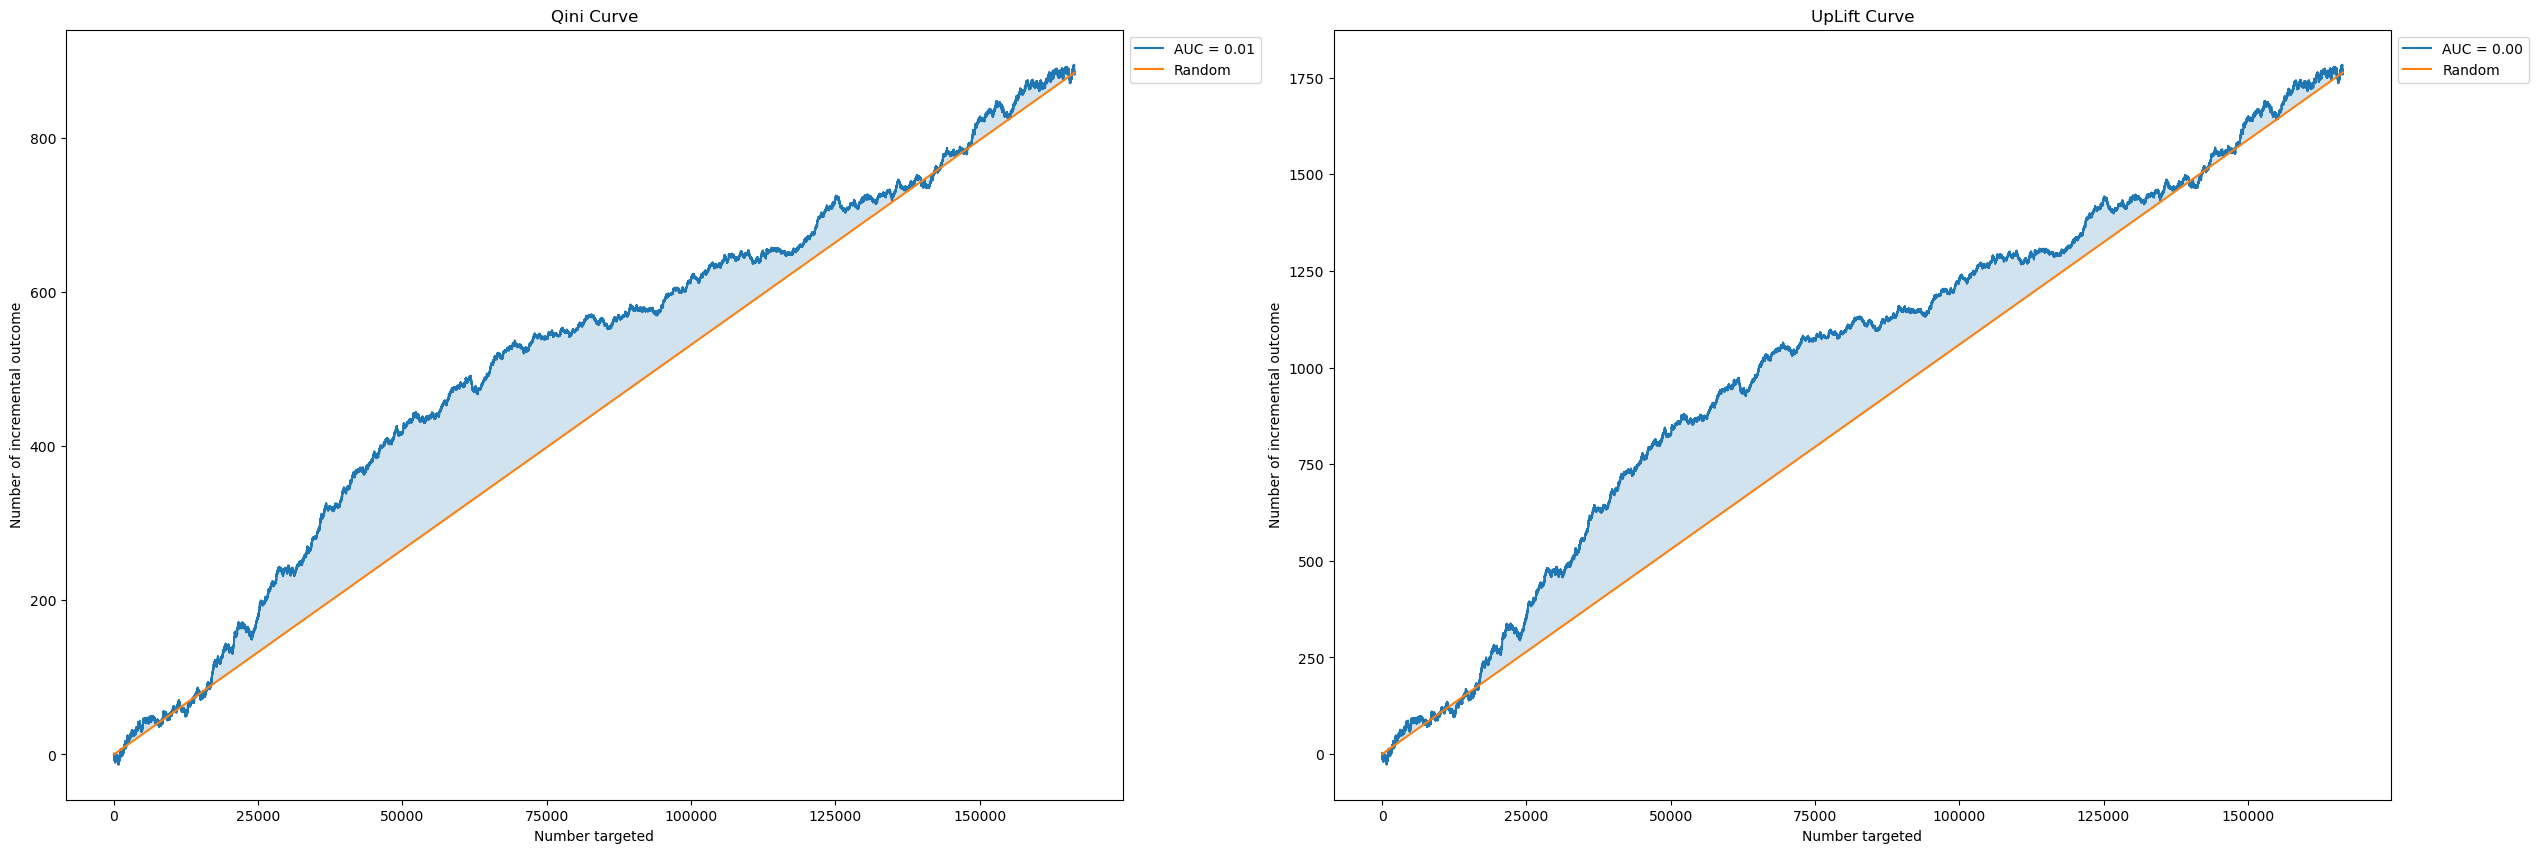

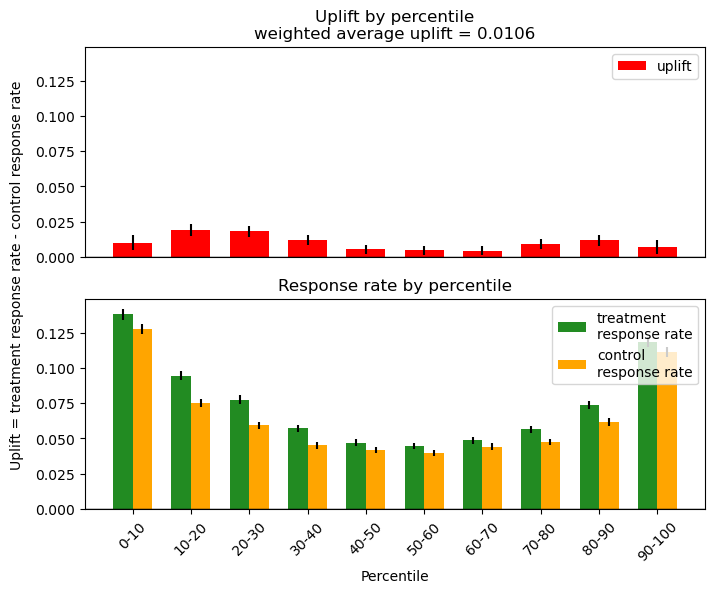

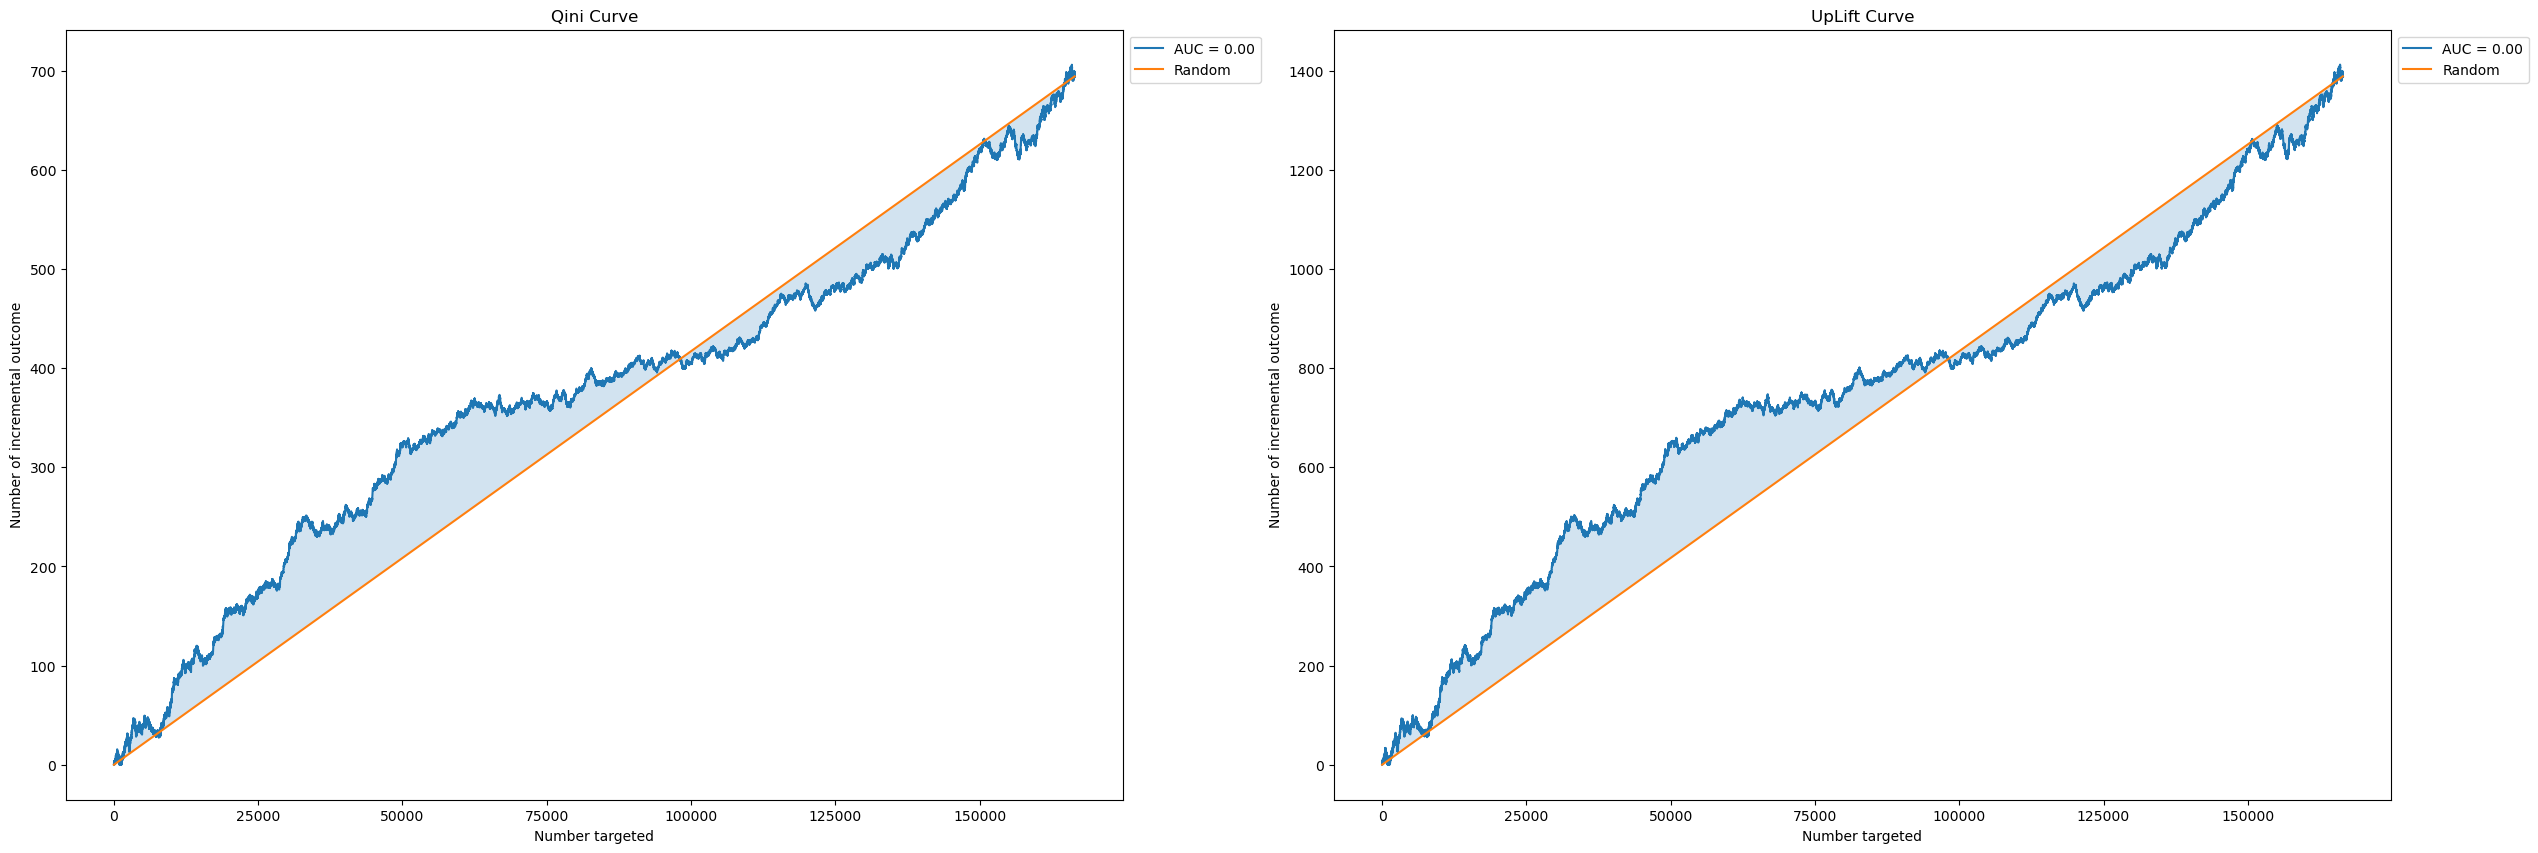

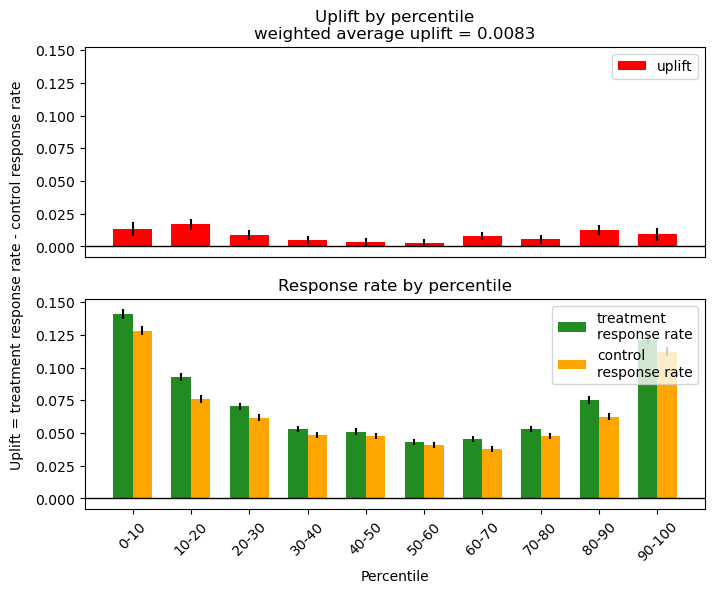

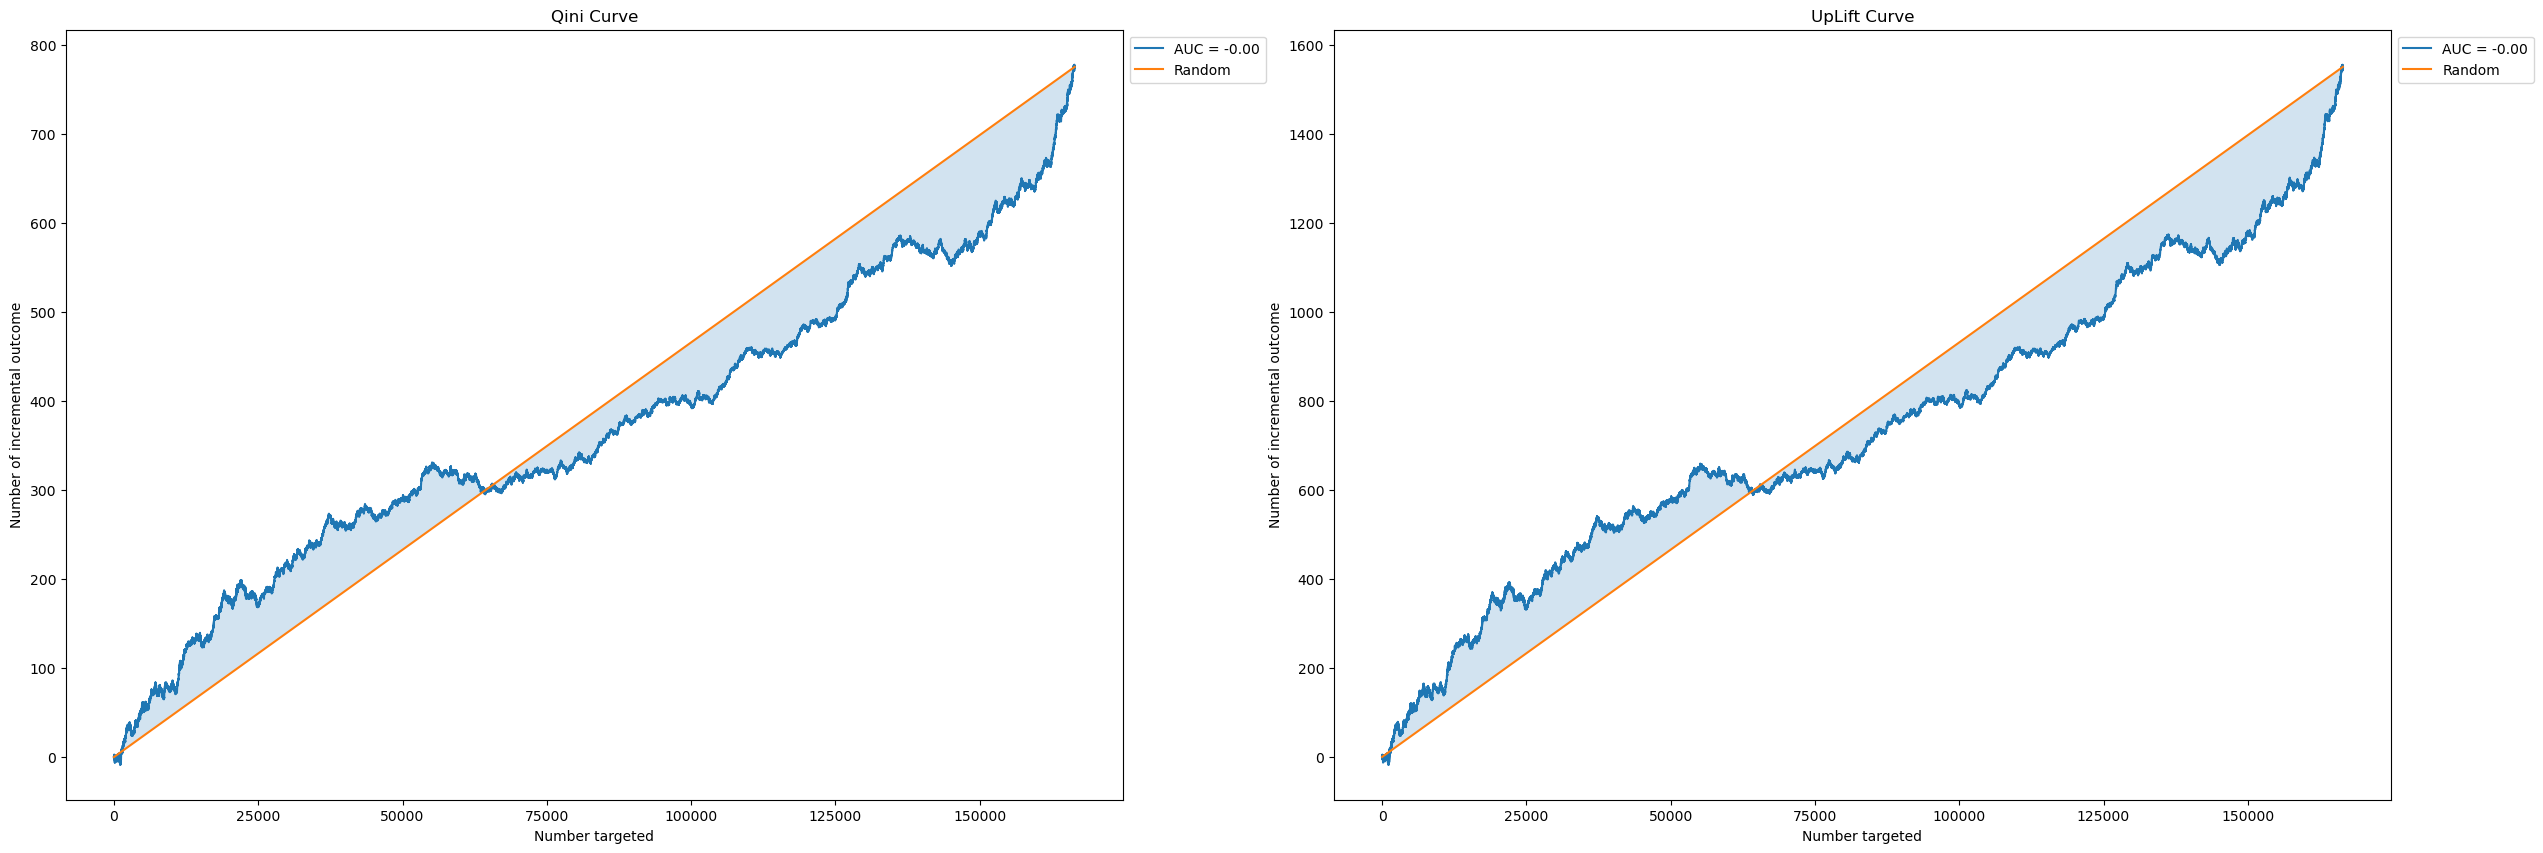

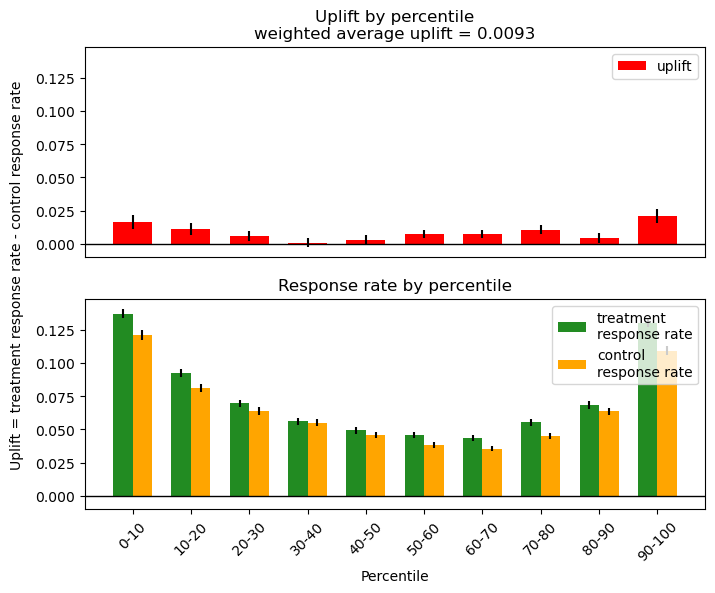

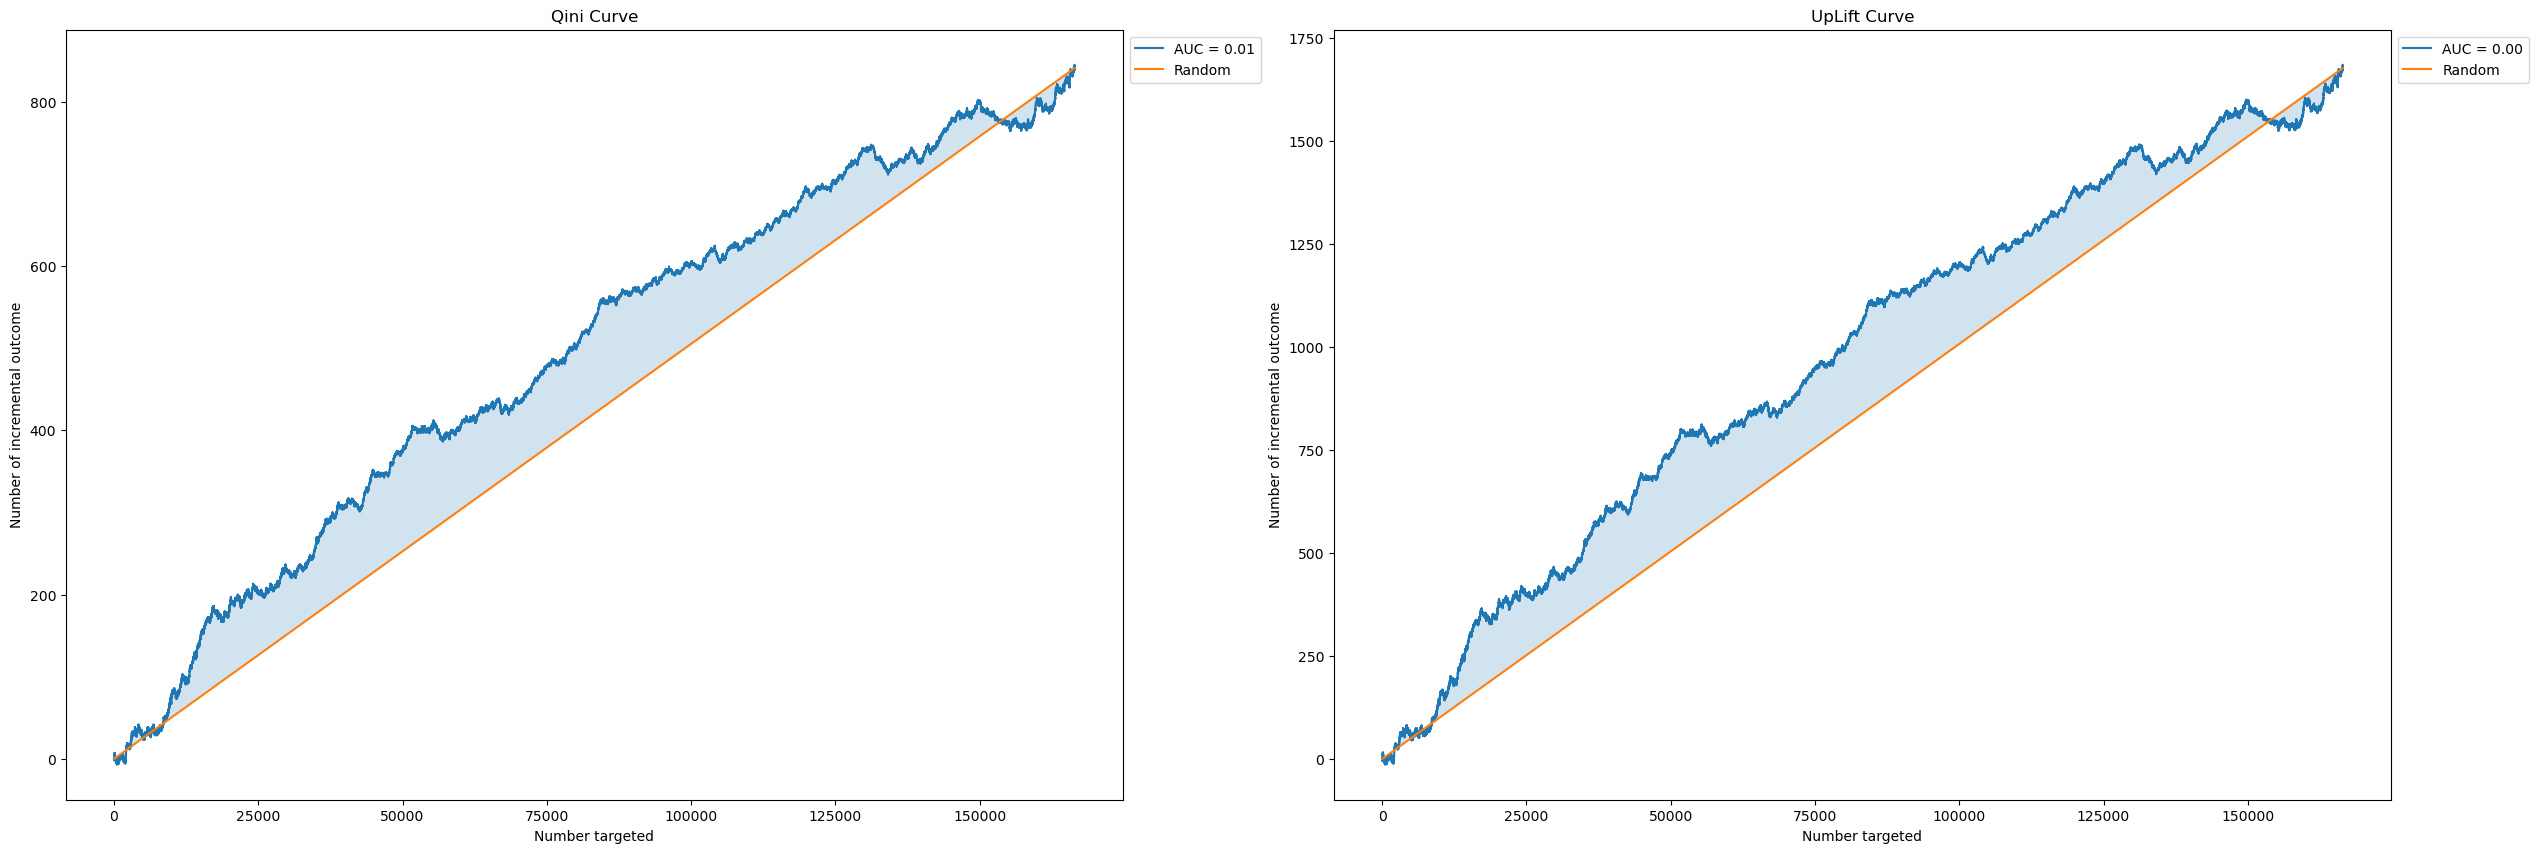

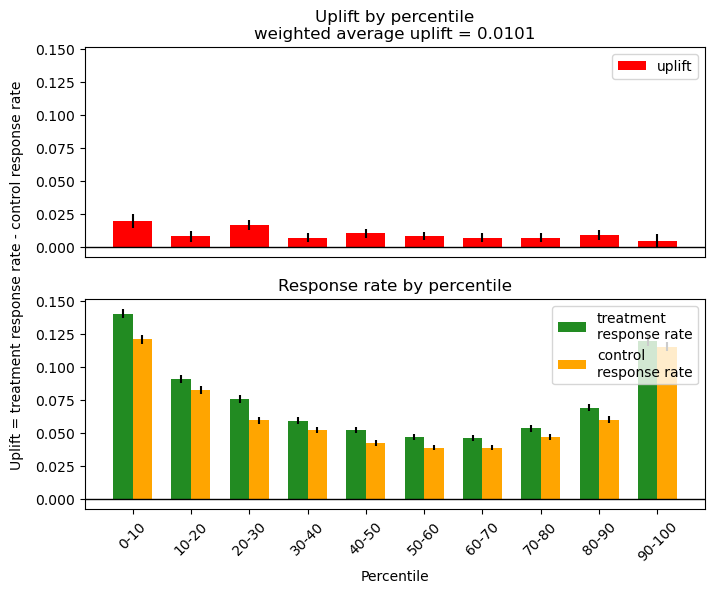

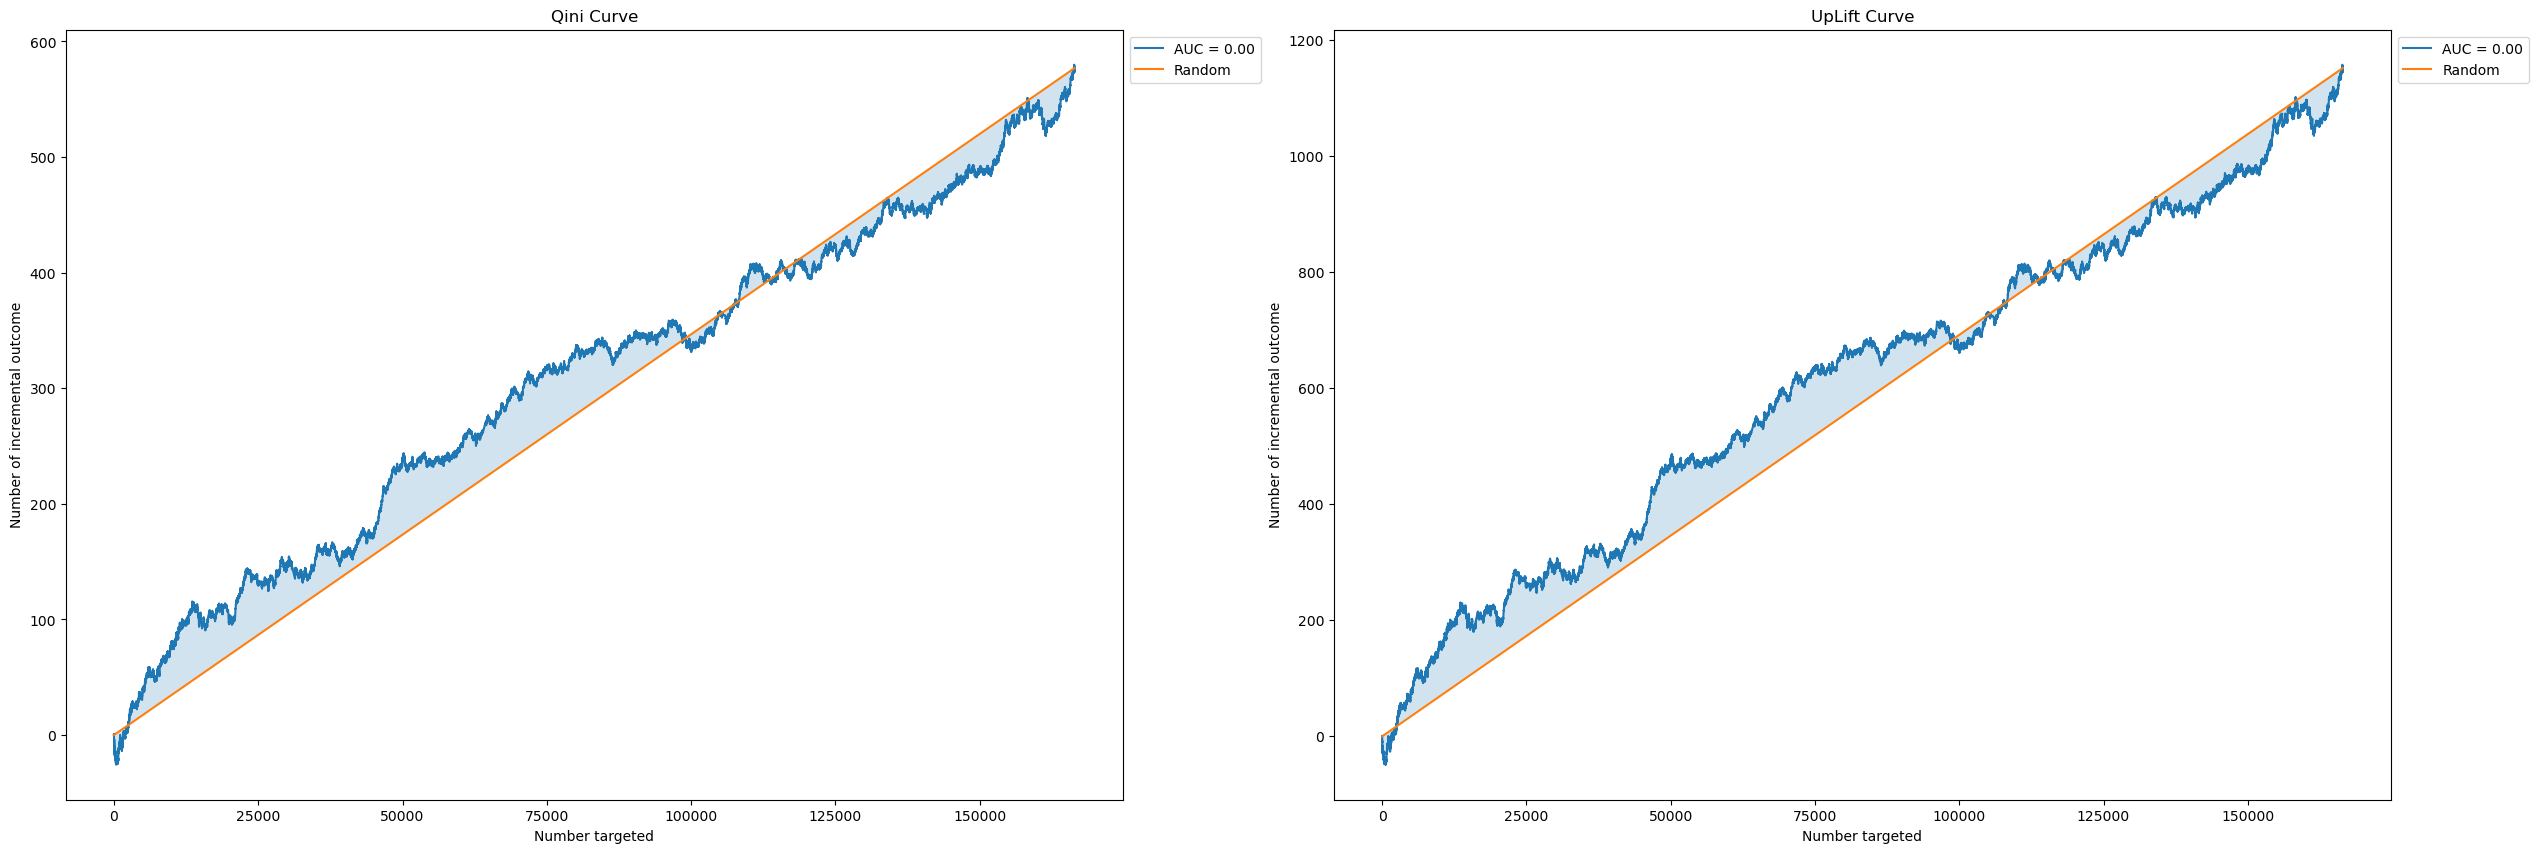

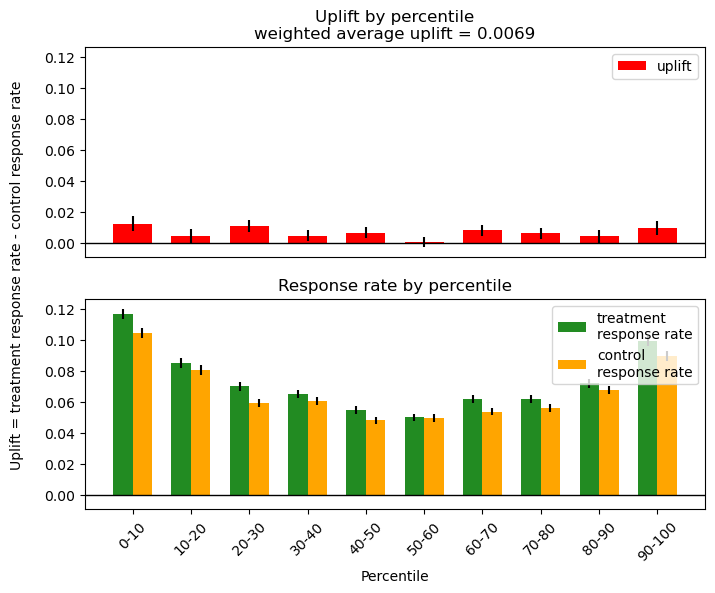

In [17]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      t_0 = np.argwhere(treat[train_index] == 0)
      t_1 = np.argwhere(treat[train_index] == 1)
      clf0 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf0.fit(np.squeeze(X_train_[t_0]), np.squeeze(y_train_[t_0]))
      clf1 = CatBoostClassifier(verbose = 0, class_weights= [0.5, 0.5] )
      clf1.fit(np.squeeze(X_train_[t_1]), np.squeeze(y_train_[t_1]))
      y_pred1 = clf1.predict_proba(X_test_).T[1]
      y_pred0 = clf0.predict_proba(X_test_).T[1]
      y_pred = y_pred1 - y_pred0
      del clf0
      del clf1
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Two model Split {i}.png")

      plot_uplift_by_percentile(y_true=y_test_ , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Two model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

In [18]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

71082

# Метод трансформации класса

In [3]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







C:\Users\Kirill\AppData\Local\Temp\ipykernel_5732\529319093.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


NewComer  SEGMENT_N_1  SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  \
7709046080         0            1            0            0            0   
7717101223         0            1            0            0            0   
7712715957         0            1            0            0            0   
7710968936         0            0            0            1            0   
7700742104         0            0            0            1            0   

            SEGMENT_N_5  SEGMENT_N_6  SEGMENT_N_8  SUB_EMAIL_Да  \
7709046080            0            0            0             1   
7717101223            0            0            0             1   
7712715957            0            0            0             0   
7710968936            0            0            0             1   
7700742104            0            0            0             1   

            SUB_EMAIL_Нет  Тип карты_Без возможности оплаты  \
7709046080              0                                 0   
7717101223              0                                 0   
7712715957              1                                 0   
7710968936              0                                 0   
7700742104              0                                 0   

            Тип карты_Как карточное платежное средство  \
7709046080                                           1   
7717101223                                           1   
7712715957                                           1   
7710968936                                           1   
7700742104                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  \
7709046080                        1                          0  16.0   
7717101223                        1                          0  36.0   
7712715957                        1                          0  32.0   
7710968936                        1                          0  33.0   
7700742104                        1                          0  35.0   

                lftm    AMOUNT    ORDERS       AOV  lftm_after_purch  \
7709046080 -1.212281 -0.600401 -0.443194 -0.685838         -1.132995   
7717101223  0.826398 -0.462569 -0.443194 -0.433224          0.968922   
7712715957  1.069822 -0.624574 -0.443194 -0.730142         -1.196690   
7710968936 -0.086443 -0.245613 -0.443194 -0.035592         -1.610704   
7700742104  0.765542 -0.449705  0.938950 -0.681531          0.809685   

              LTV_1M  AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7709046080 -0.523763      0.333584  -0.353530  -0.546141         0.339303   
7717101223 -0.527795     -0.729638  -0.291854   0.130118        -0.552748   
7712715957 -0.574041      0.333584  -0.365865   0.000000         0.000000   
7710968936  0.214172      0.333584  -0.217843   0.130118        -0.496408   
7700742104 -0.518876      0.333584   2.785775   1.553644        -0.186538   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7709046080       -0.396474        0.000000                0.0   
7717101223       -0.308987        0.000000                0.0   
7712715957       -0.413971        0.000000                0.0   
7710968936       -0.204004        0.000000                0.0   
7700742104        4.056583        1.561972                0.0   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7709046080          -0.608796             0.0      -0.600477   
7717101223           0.185893             0.0      -0.428430   
7712715957           0.000000             0.0      -0.634887   
7710968936           0.185893             0.0      -0.221974   
7700742104           0.185893             0.0      -0.445635   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS  \
7709046080                  0.0           -0.600477      -0.439705   
7717101223                  0.0           -0.428430       0.709397   
7712715957                  0.0           -0.634887       0.000000   
7710968936                  0.0        

target  treat
7709046080       0      0
7717101223       0      0
7712715957       1      0
7710968936       0      0
7700742104       0      0

In [4]:
treat = Y_data.treat.values
p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
targ = Y_data.target
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


[[0.       1.       0.       ... 0.420668 0.       0.420668]
 [0.       1.       0.       ... 0.293083 0.       0.293083]
 [0.       1.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]]
[-0.         -0.         -2.00406899 ...  0.         -0.
  0.        ]
0.5010151832976517


Split 1; WAU = 0.010201938475556512; UpLift 30% = 0.013689563692564563


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.008713619890881262; UpLift 30% = 0.016081424991560178


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.009002001471697597; UpLift 30% = 0.013437913574497182


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.010152215894846946; UpLift 30% = 0.016680133761357463


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.006571443102878011; UpLift 30% = 0.006049510101868147


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0089; Mean UpLift 30% = 0.0132


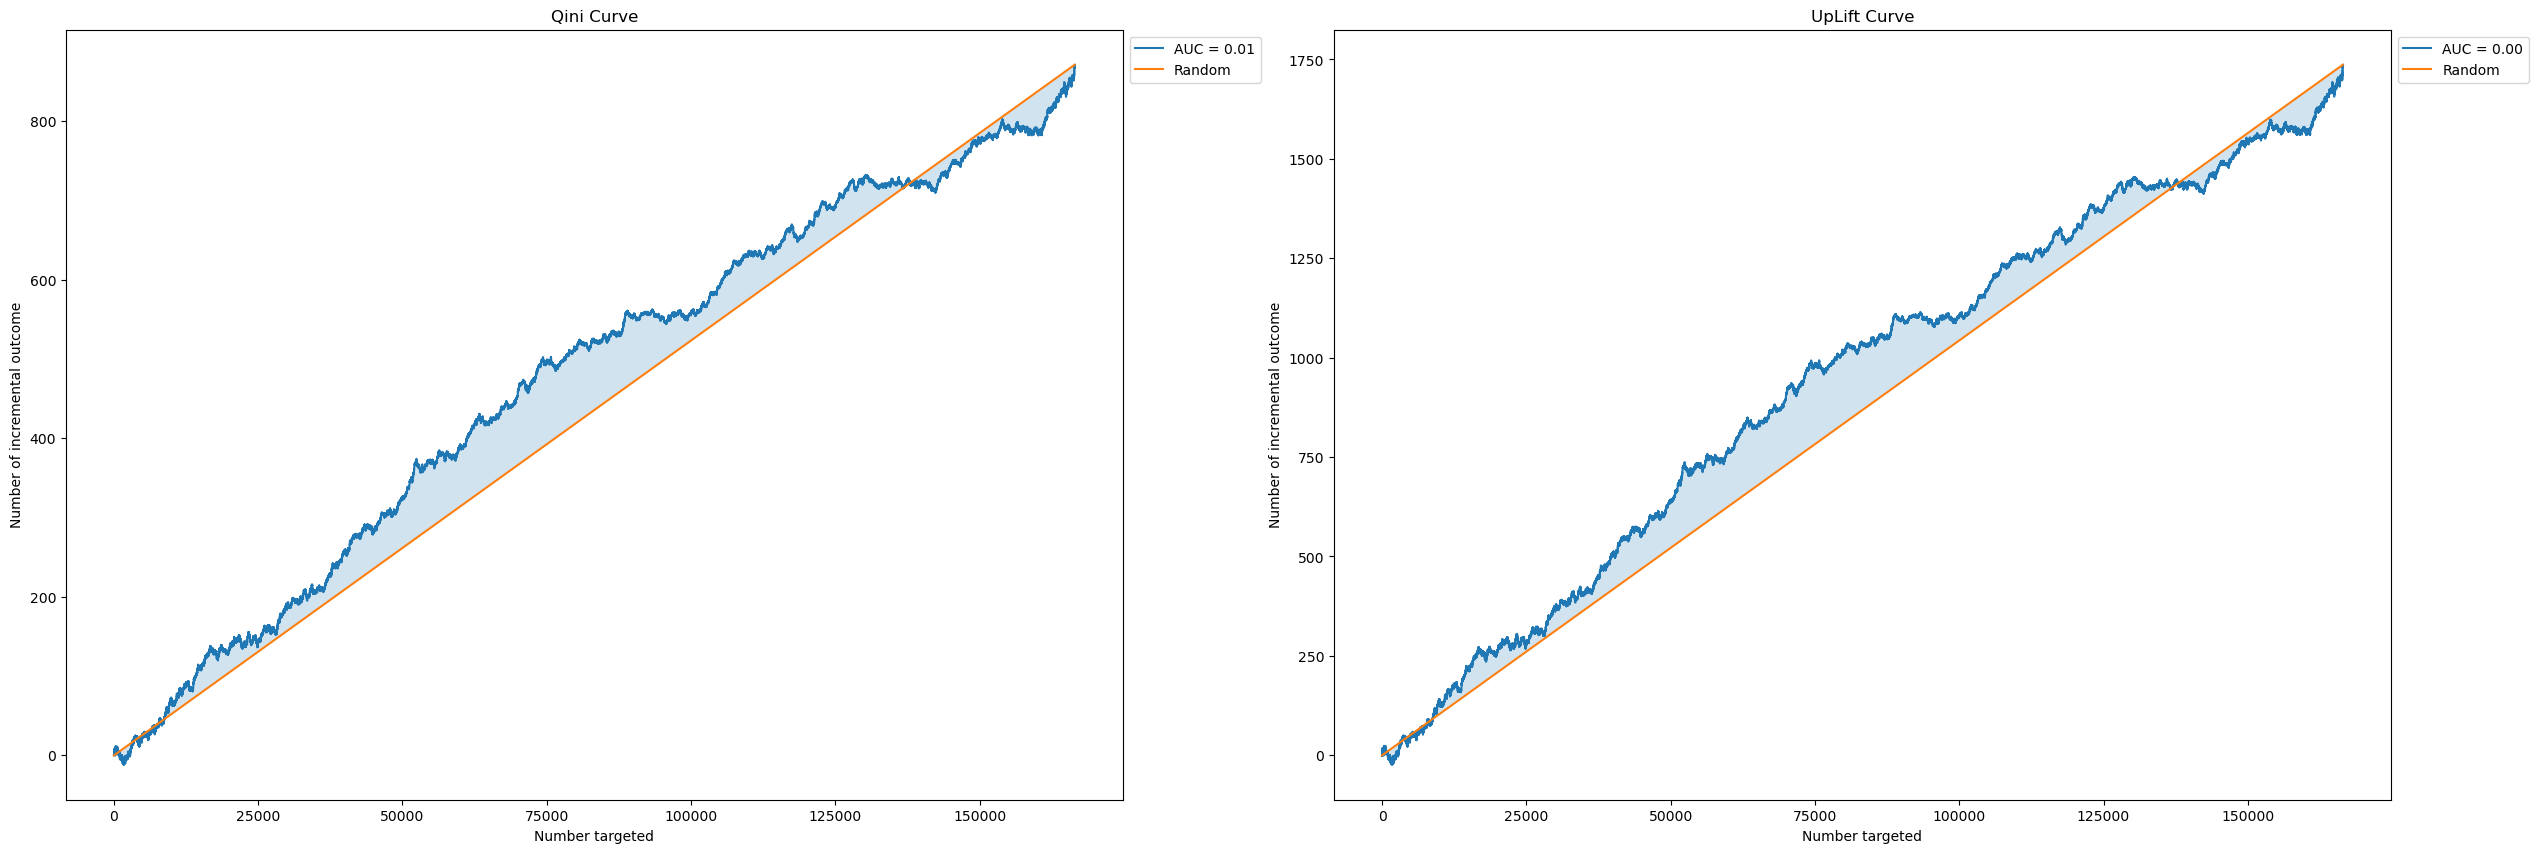

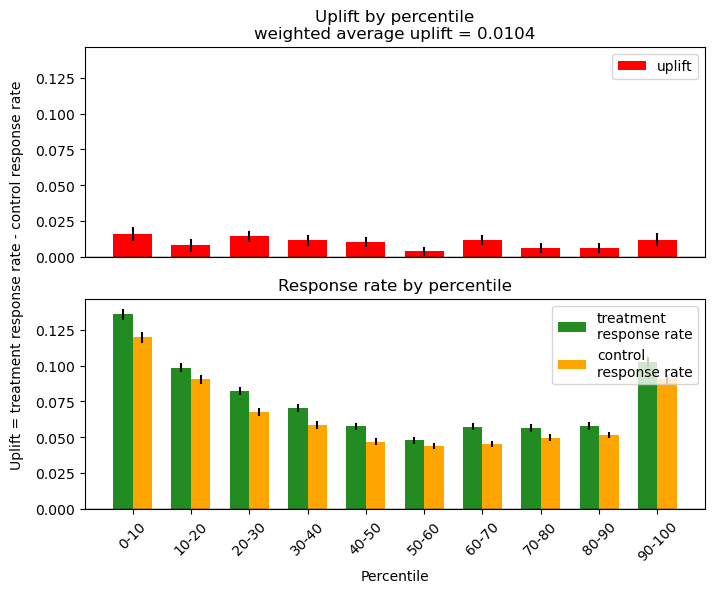

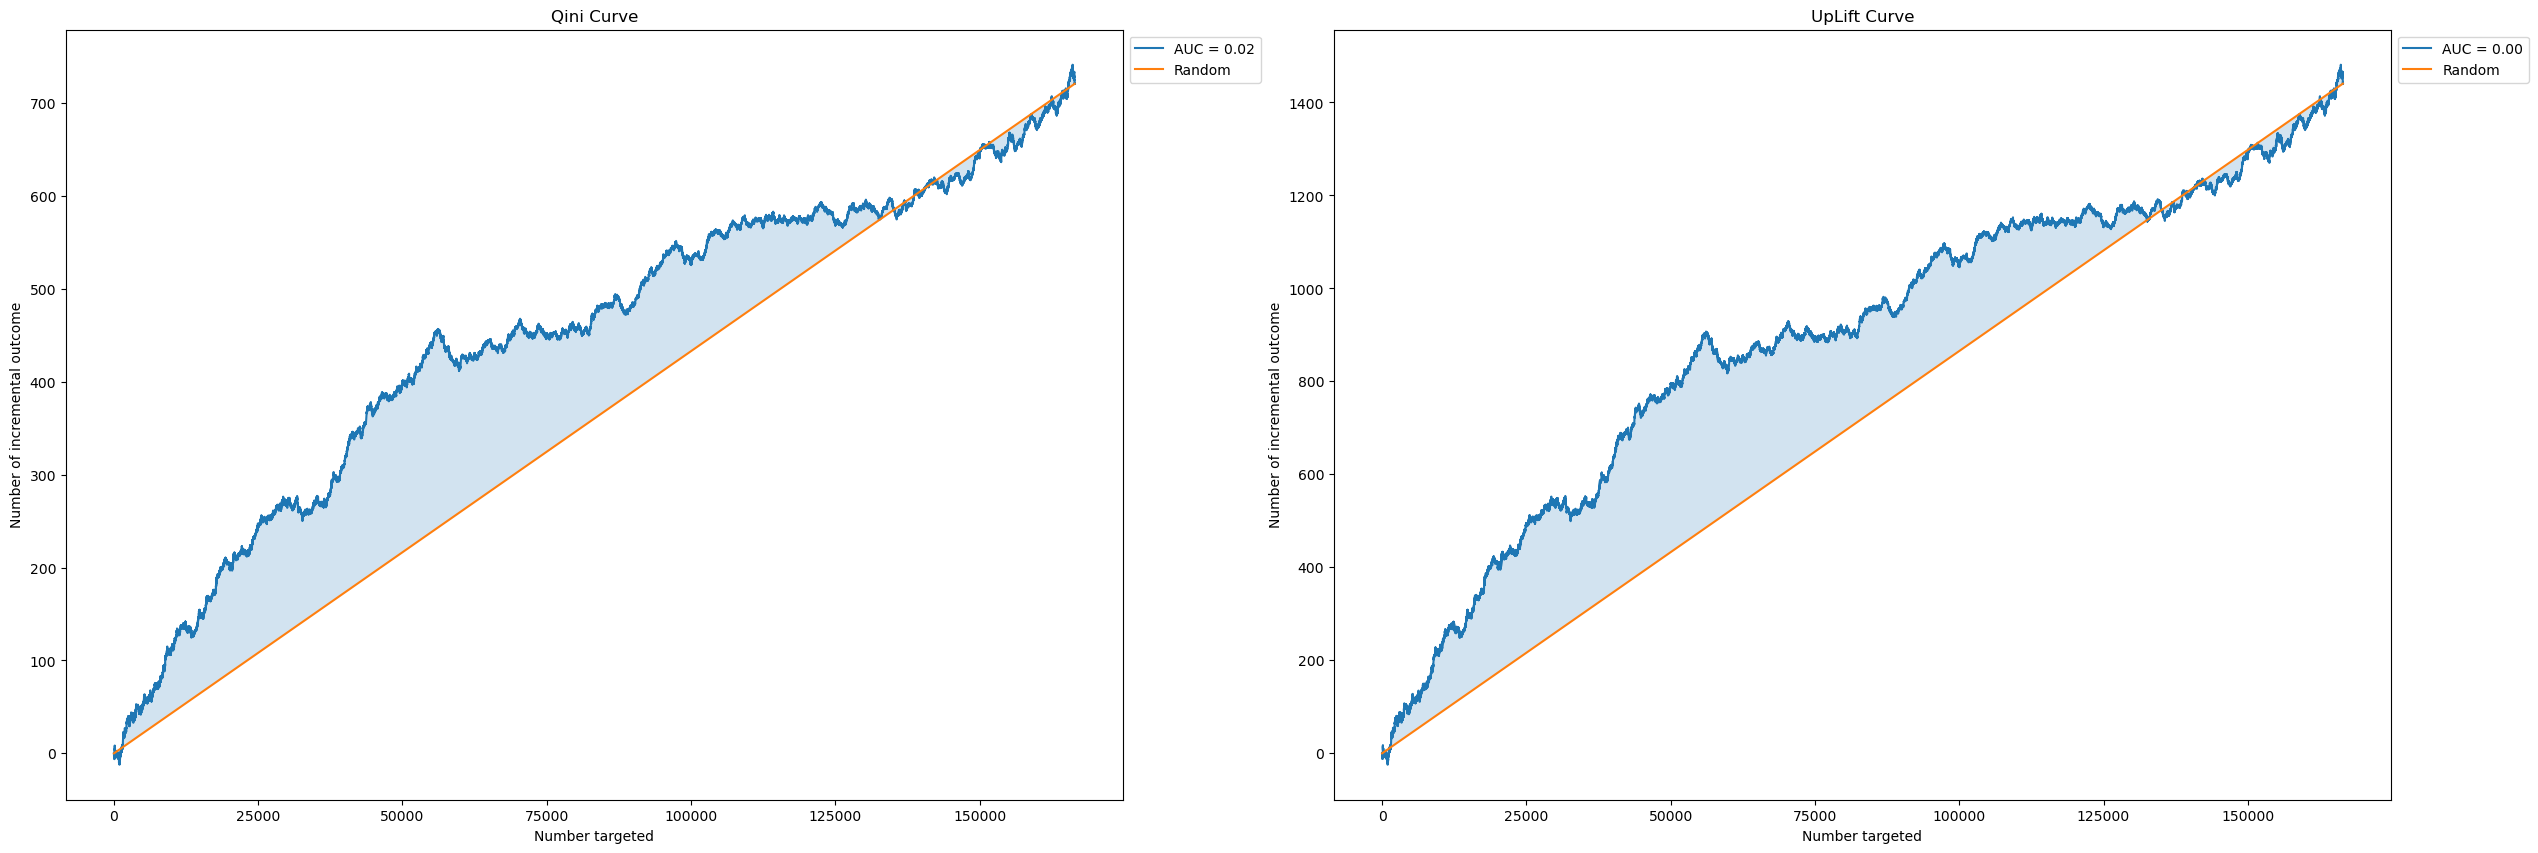

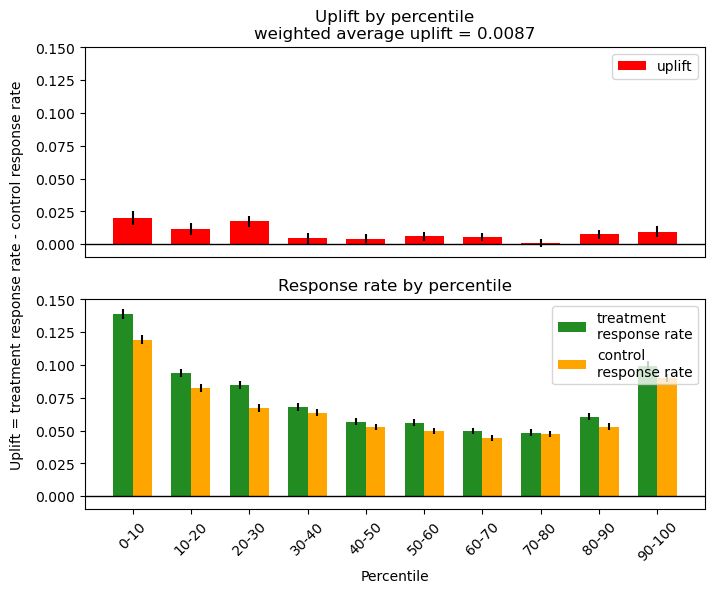

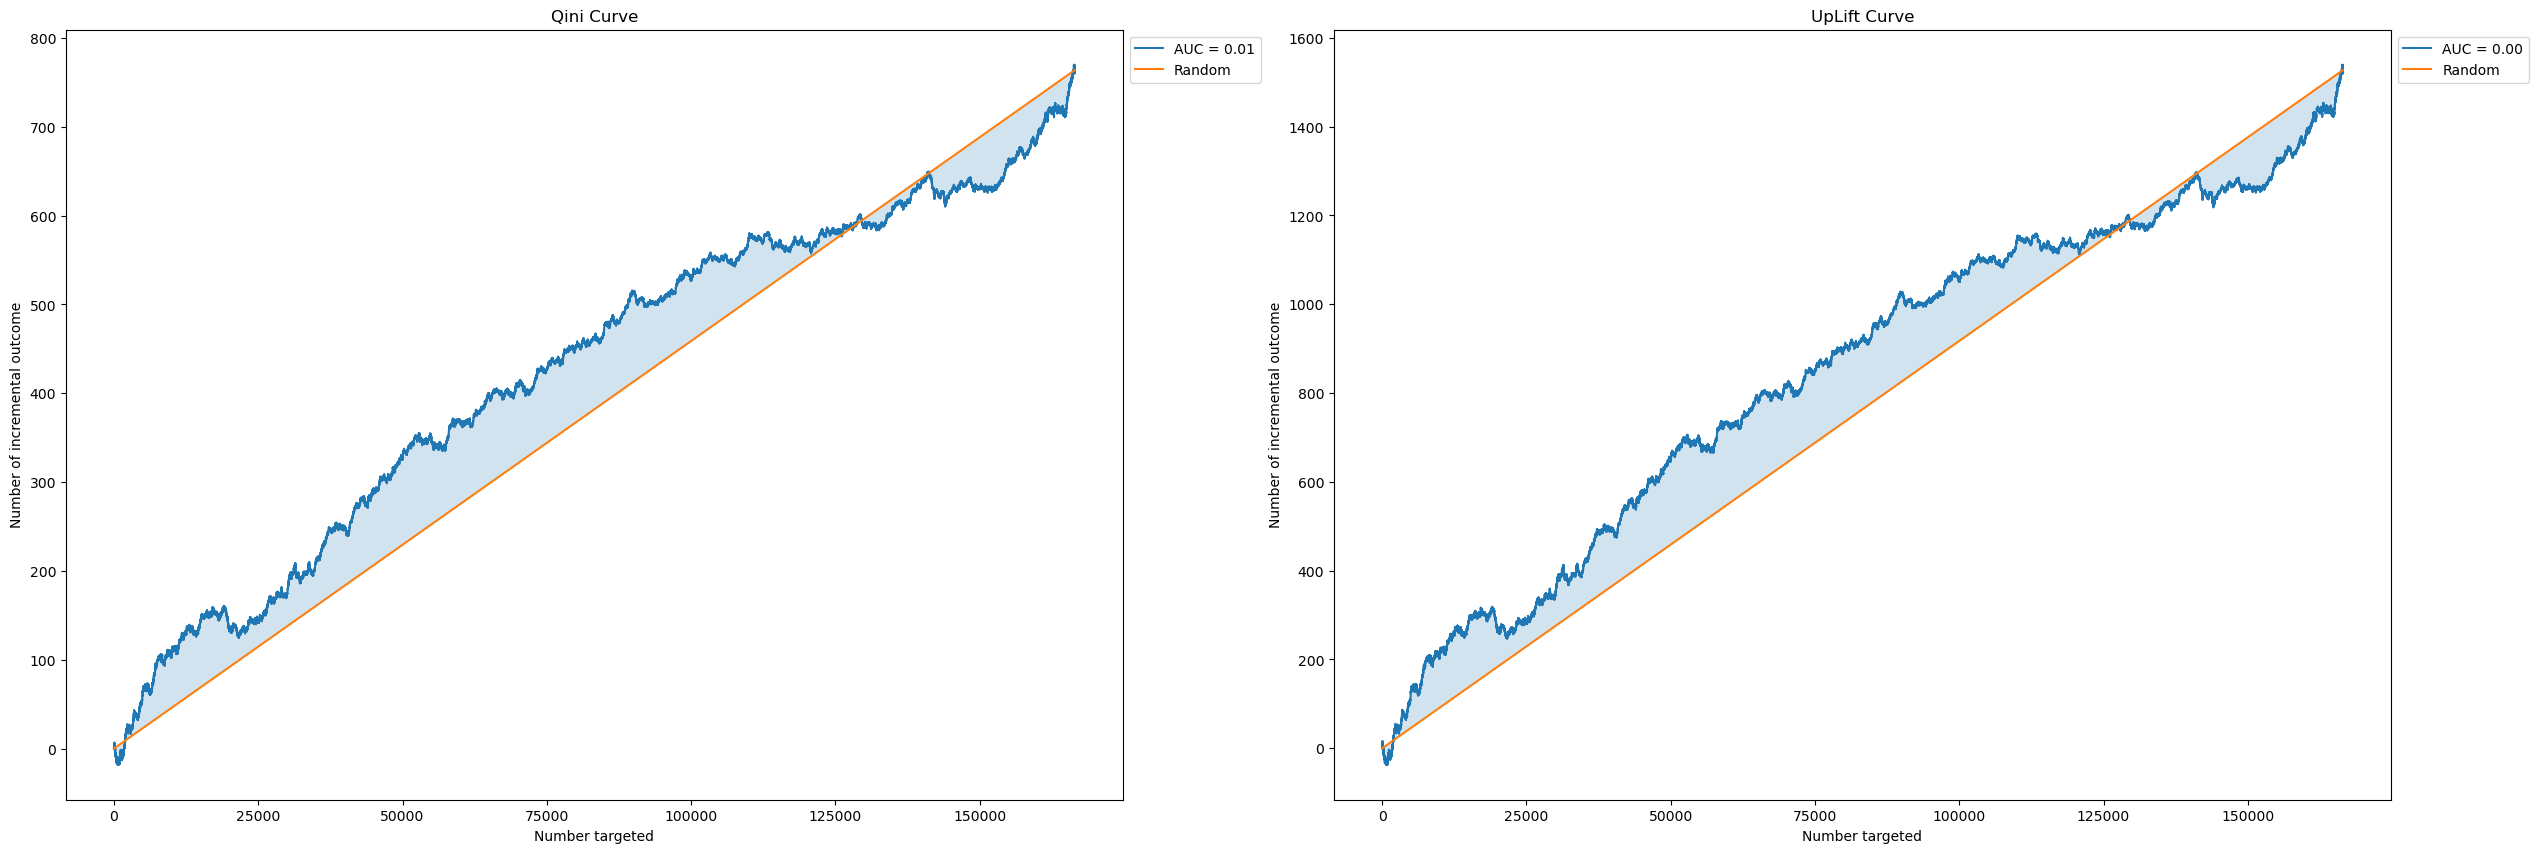

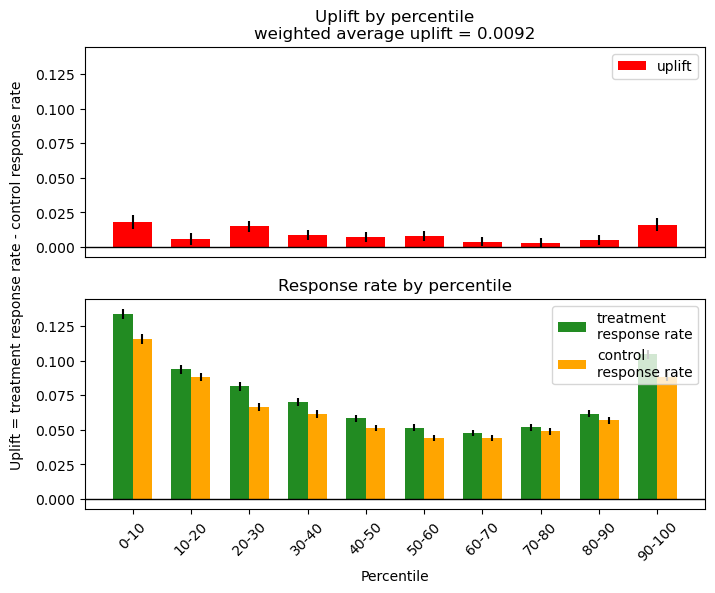

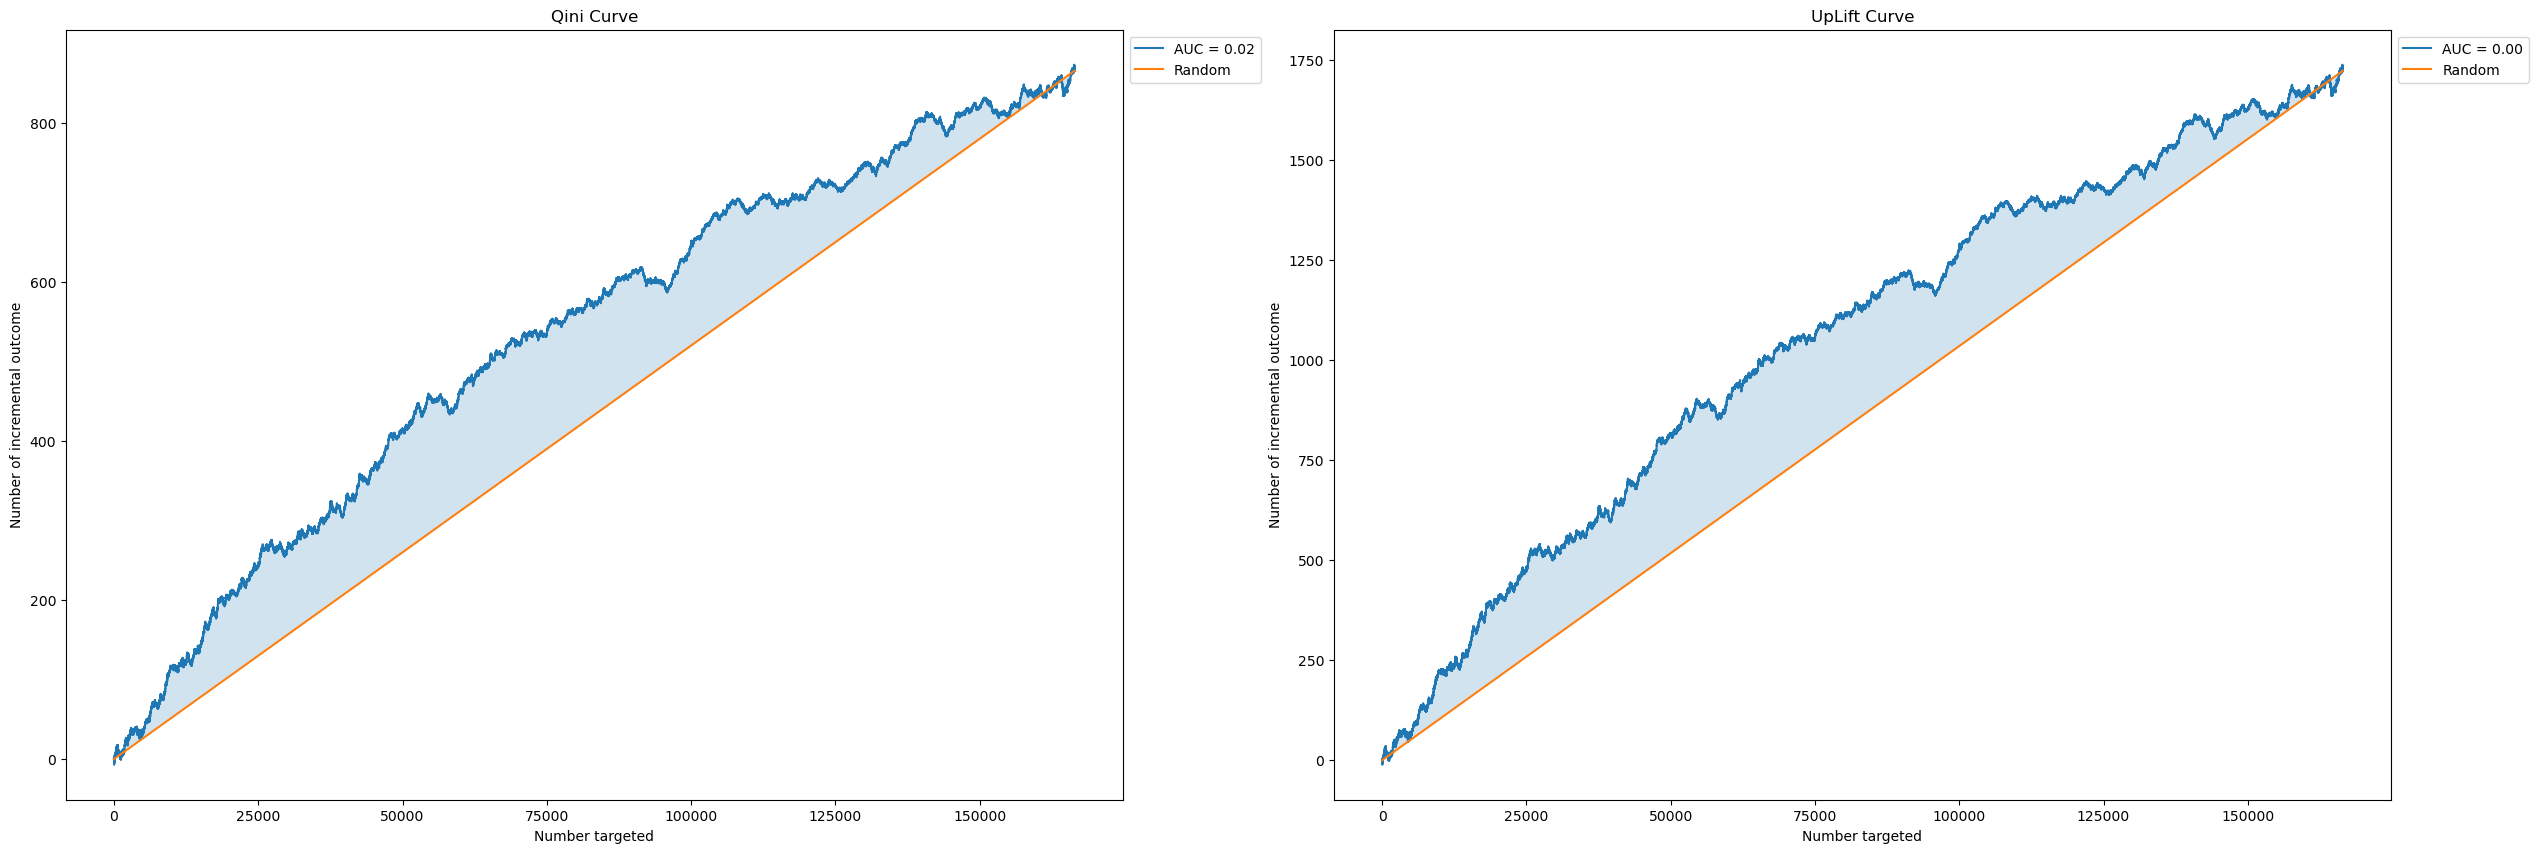

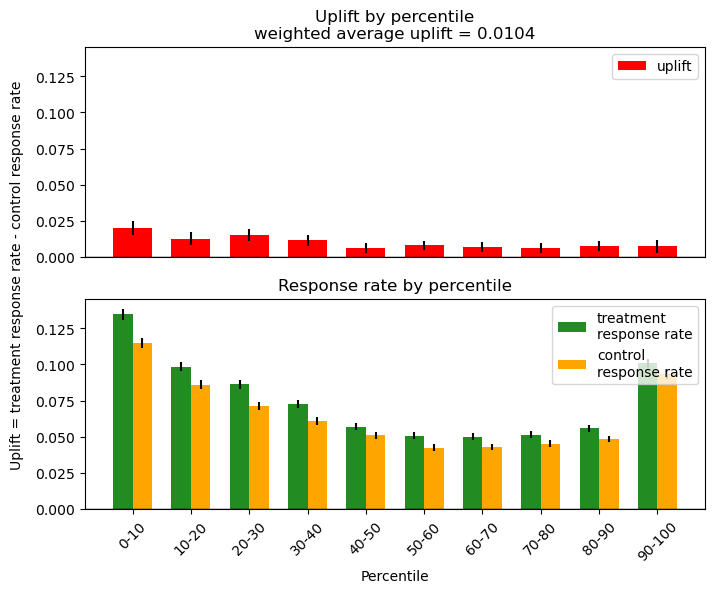

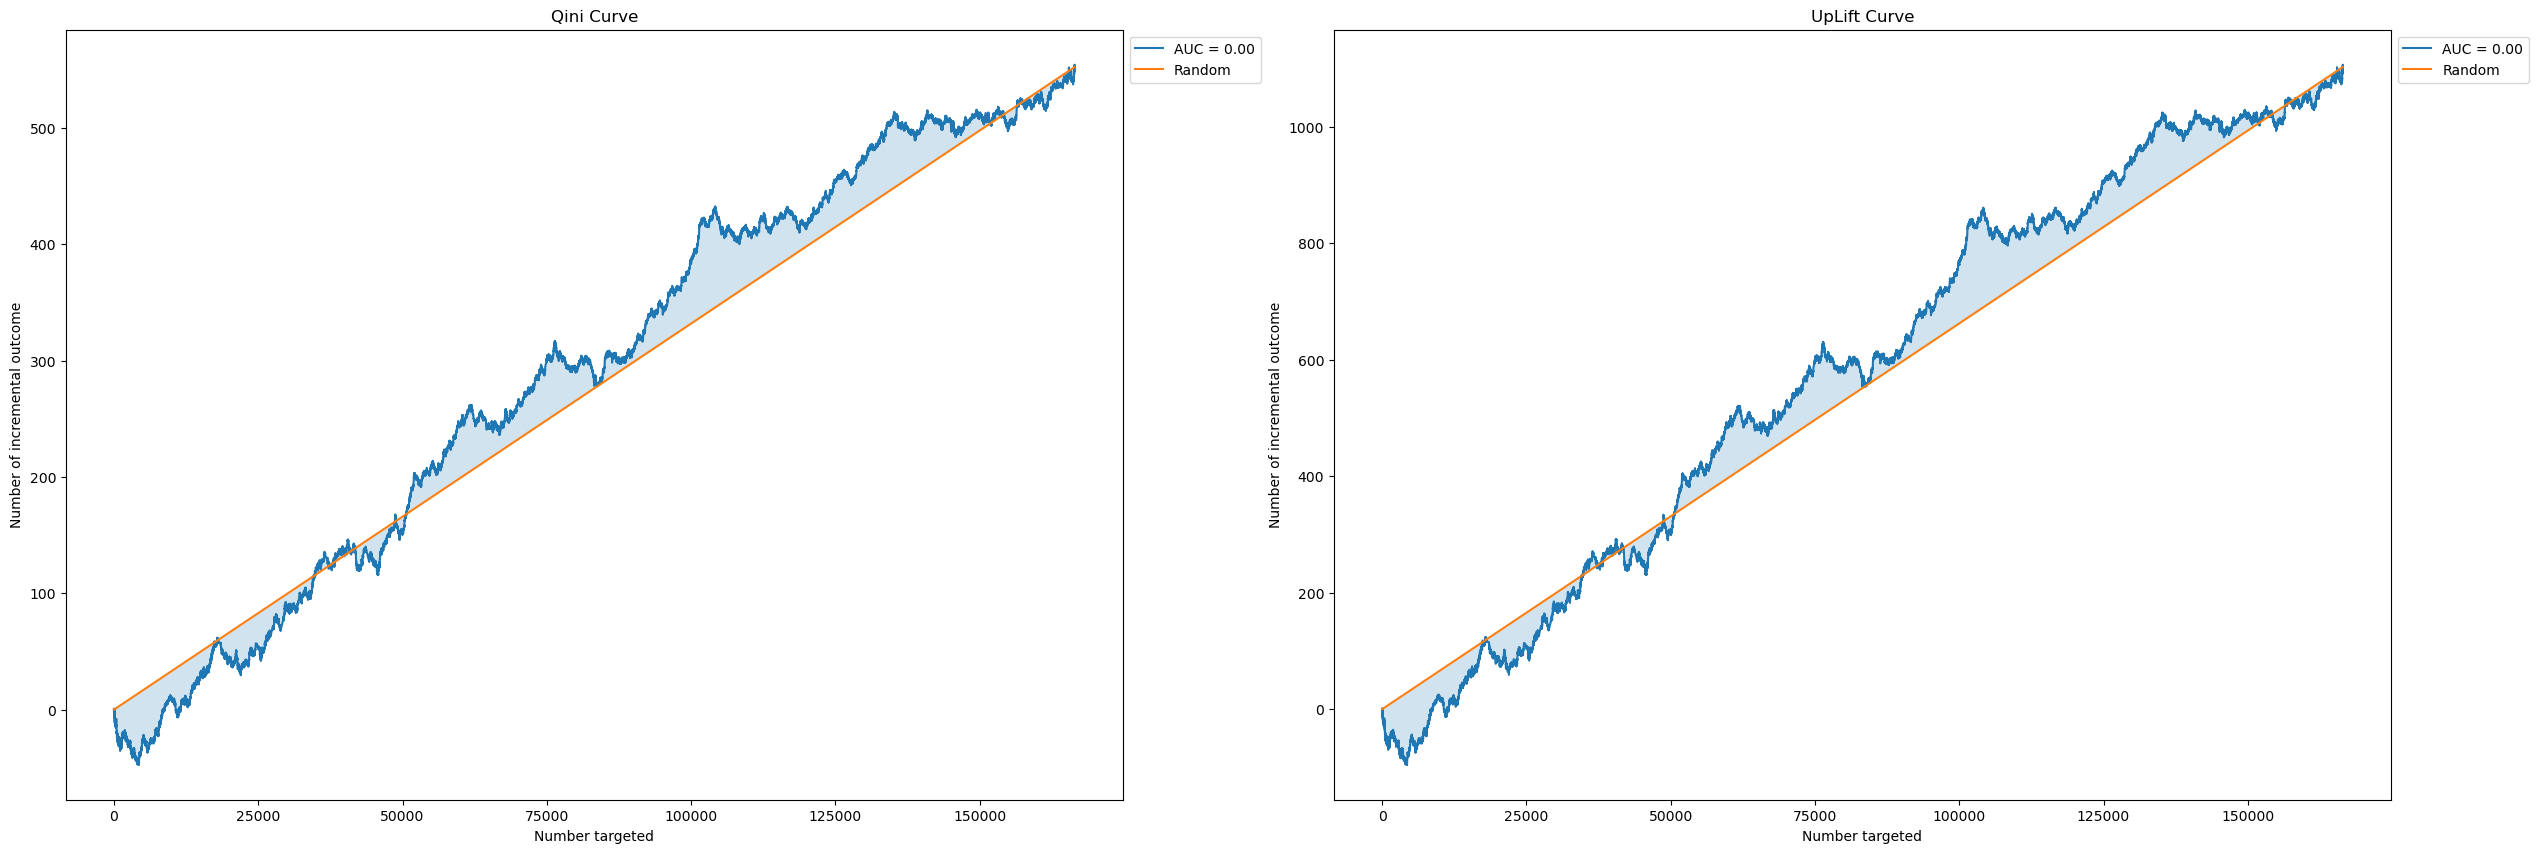

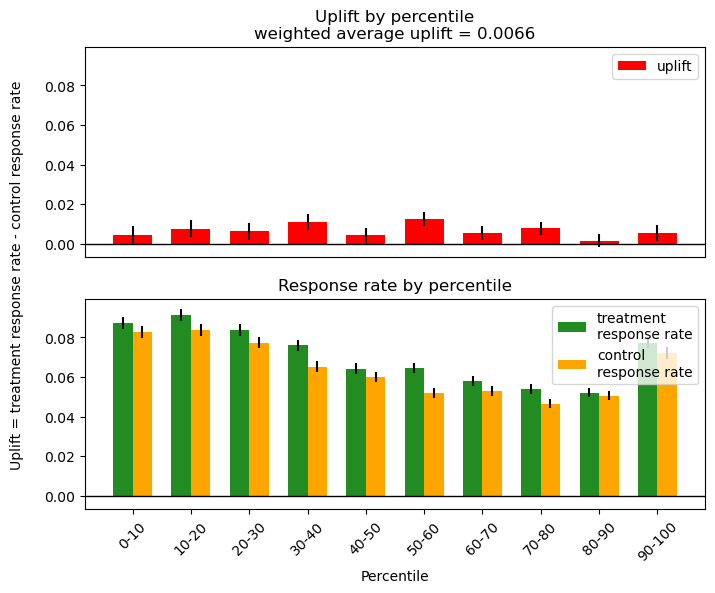

In [5]:
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      reg = CatBoostRegressor(verbose=0)
      reg.fit(X_train_, y_train_)
      y_pred = reg.predict(X_test_)
      del reg
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')


In [6]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

70480

# AutoML

## Search PipeLine

In [4]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU_without_norm(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


C:\Users\Kirill\AppData\Local\Temp\ipykernel_10136\900749741.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


NewComer  SEGMENT_N_1  SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  \
7709046080         0            1            0            0            0   
7717101223         0            1            0            0            0   
7712715957         0            1            0            0            0   
7710968936         0            0            0            1            0   
7700742104         0            0            0            1            0   

            SEGMENT_N_5  SEGMENT_N_6  SEGMENT_N_8  SUB_EMAIL_Да  \
7709046080            0            0            0             1   
7717101223            0            0            0             1   
7712715957            0            0            0             0   
7710968936            0            0            0             1   
7700742104            0            0            0             1   

            SUB_EMAIL_Нет  Тип карты_Без возможности оплаты  \
7709046080              0                                 0   
7717101223              0                                 0   
7712715957              1                                 0   
7710968936              0                                 0   
7700742104              0                                 0   

            Тип карты_Как карточное платежное средство  \
7709046080                                           1   
7717101223                                           1   
7712715957                                           1   
7710968936                                           1   
7700742104                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  lftm  \
7709046080                        1                          0  16.0    23   
7717101223                        1                          0  36.0    90   
7712715957                        1                          0  32.0    98   
7710968936                        1                          0  33.0    60   
7700742104                        1                          0  35.0    88   

             AMOUNT  ORDERS          AOV  lftm_after_purch       LTV_1M  \
7709046080   413.15     1.0   413.150000              23.0   413.150000   
7717101223  1206.00     1.0  1206.000000              89.0   402.000000   
7712715957   274.10     1.0   274.100000              21.0   274.100000   
7710968936  2454.00     1.0  2454.000000               8.0  2454.000000   
7700742104  1280.00     3.0   426.666666              84.0   426.666666   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7709046080      1.000000        5.0      300.0           -295.0   
7717101223      0.333333       15.0      500.0           -485.0   
7712715957      1.000000        3.0        0.0              0.0   
7710968936      1.000000       27.0      500.0           -473.0   
7700742104      1.000000      514.0      921.0           -407.0   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7709046080             5.0             0.0                0.0   
7717101223            15.0             0.0                0.0   
7712715957             3.0             0.0                0.0   
7710968936            27.0             0.0                0.0   
7700742104           514.0           421.0                0.0   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7709046080              300.0             0.0            5.0   
7717101223              500.0             0.0           15.0   
7712715957                0.0             0.0            3.0   
7710968936              500.0             0.0           27.0   
7700742104              500.0             0.0           14.0   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS  \
7709046080                  0.0                 5.0          300.0   
7717101223                  0.0                15.0          500.0   
7712715957                  0.0                 3.0            0.0   
7710968936                  0.0              

target  treat
7709046080       0      0
7717101223       0      0
7712715957       1      0
7710968936       0      0
7700742104       0      0

[[0.       1.       0.       ... 0.420668 0.       0.420668]
 [0.       1.       0.       ... 0.293083 0.       0.293083]
 [0.       1.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]]
[-0.         -0.         -2.00406899 ...  0.         -0.
  0.        ]
0.5010151832976517


In [5]:
import evalml
from evalml import AutoMLSearch

In [6]:
X_train,X_test,y_train,y_test=evalml.preprocessing.split_data(X, y,problem_type='regression')

In [7]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 10
                    , objective = 'Root Mean Squared Error'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 20
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Root Mean Squared Error. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 10 batches for a total of 20 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.532

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.532
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.532

*****************************
* Evaluating Batch Number 2 *
*****************************



c:\Users\Kirill\.conda\envs\automl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.937e+03, tolerance: 4.662e+00



Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.532
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.532

*****************************
* Evaluating Batch Number 3 *
*****************************

Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.532
Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.532
XGBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer:
	Starting cros

{1: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler': '00:11',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer': '00:27',
  'Total time of batch': '00:39'},
 2: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model': '00:31',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model': '00:38',
  'Total time of batch': '01:10'},
 3: {'Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:04',
  'Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:09',
  'XGBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:09',
  'CatBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:04',
  'LightGBM Regressor w/ Replace

In [9]:
automl.save('automl_big_searching.cloudpickle')

## Train Best Pipeline

In [10]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching.cloudpickle')


In [11]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [12]:
ranks.to_csv('evalml_res.csv', index = False)

In [13]:
ranks.head()

pipeline_name  validation_score  \
0  Elastic Net Regressor w/ Replace Nullable Type...          0.531860   
1                  Mean Baseline Regression Pipeline          0.531878   
2  Elastic Net Regressor w/ Replace Nullable Type...          0.531878   
5  CatBoost Regressor w/ Replace Nullable Types T...          0.531884   
6  Random Forest Regressor w/ Replace Nullable Ty...          0.531975   

   percent_better_than_baseline  \
0                      0.003392   
1                      0.000000   
2                      0.000000   
5                     -0.000998   
6                     -0.018230   

                                          parameters  
0  {'Imputer': {'categorical_impute_strategy': 'm...  
1       {'Baseline Regressor': {'strategy': 'mean'}}  
2  {'Imputer': {'categorical_impute_strategy': 'm...  
5  {'Imputer': {'categorical_impute_strategy': 'm...  
6  {'Imputer': {'categorical_impute_strategy': 'm...

In [14]:
ranks.shape

(13, 4)

In [15]:

ranks.head(5).to_excel('res.xlsx')

In [18]:
ranks.iloc[0, :].parameters

{'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'RF Regressor Select From Model': {'number_features': None,
  'n_estimators': 10,
  'max_depth': None,
  'percent_features': 0.5,
  'threshold': 'median',
  'n_jobs': -1},
 'Elastic Net Regressor': {'alpha': 0.0001,
  'l1_ratio': 0.15,
  'max_iter': 1000,
  'normalize': False}}

In [19]:
ctbst  = automl.best_pipeline
type(ctbst)

evalml.pipelines.regression_pipeline.RegressionPipeline

In [20]:
#ctbst.fit(X_train, y_train)

In [25]:
best_features = ctbst.feature_importance.copy()
best_features = best_features[best_features.importance.abs() > 0.001]
best_features

feature  importance
0        30    0.005707
1        42    0.005701
2        33   -0.005020
3        44   -0.004903
4        34    0.004120
5        14    0.003973
6        20   -0.003790
7        43   -0.002547
8        15    0.002524
9        21    0.002336
10       18   -0.002283
11       25    0.002216
12       37   -0.001842
13       24   -0.001823
14       23    0.001677
15       22   -0.001260

In [26]:
features

['NewComer',
 'SEGMENT_N_1',
 'SEGMENT_N_2',
 'SEGMENT_N_3',
 'SEGMENT_N_4',
 'SEGMENT_N_5',
 'SEGMENT_N_6',
 'SEGMENT_N_8',
 'SUB_EMAIL_Да',
 'SUB_EMAIL_Нет',
 'Тип карты_Без возможности оплаты',
 'Тип карты_Как карточное платежное средство',
 'Канал регистрации_Ecomm',
 'Канал регистрации_Розница',
 'AGE',
 'lftm',
 'AMOUNT',
 'ORDERS',
 'AOV',
 'lftm_after_purch',
 'LTV_1M',
 'AO_per_month',
 'GET_Bonus',
 'USE_Bonus',
 'NON_SPEND_BONUS',
 'BASE_GET_Bonus',
 'BASE_USE_Bonus',
 'Express_GET_Bonus',
 'Express_USE_Bonus',
 'Camp_GET_Bonus',
 'REG_GET_Bonus',
 'Camp_BASE_GET_Bonus',
 'REG_BASE_GET_Bonus',
 'AVG_USE_BONUS',
 'DISC_AMOUNT',
 'DISC_ORDERS',
 'BASE_AVG_USE_BONUS',
 'BASE_DISC_AMOUNT',
 'BASE_DISC_ORDERS',
 'Express_AVG_USE_BONUS',
 'Express_DISC_AMOUNT',
 'Express_DISC_ORDERS',
 'AVG_DIS',
 'BASE_AVG_DIS',
 'Express_AVG_DIS']

In [27]:
best_features['Name'] = best_features.feature.apply(lambda x: features[x])
best_features

feature  importance              Name
0        30    0.005707     REG_GET_Bonus
1        42    0.005701           AVG_DIS
2        33   -0.005020     AVG_USE_BONUS
3        44   -0.004903   Express_AVG_DIS
4        34    0.004120       DISC_AMOUNT
5        14    0.003973               AGE
6        20   -0.003790            LTV_1M
7        43   -0.002547      BASE_AVG_DIS
8        15    0.002524              lftm
9        21    0.002336      AO_per_month
10       18   -0.002283               AOV
11       25    0.002216    BASE_GET_Bonus
12       37   -0.001842  BASE_DISC_AMOUNT
13       24   -0.001823   NON_SPEND_BONUS
14       23    0.001677         USE_Bonus
15       22   -0.001260         GET_Bonus

In [28]:
print(best_features.Name.tolist())

['REG_GET_Bonus', 'AVG_DIS', 'AVG_USE_BONUS', 'Express_AVG_DIS', 'DISC_AMOUNT', 'AGE', 'LTV_1M', 'BASE_AVG_DIS', 'lftm', 'AO_per_month', 'AOV', 'BASE_GET_Bonus', 'BASE_DISC_AMOUNT', 'NON_SPEND_BONUS', 'USE_Bonus', 'GET_Bonus']


In [31]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU_without_norm(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


C:\Users\Kirill\AppData\Local\Temp\ipykernel_10136\900749741.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



NewComer  SEGMENT_N_1  SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  \
7709046080         0            1            0            0            0   
7717101223         0            1            0            0            0   
7712715957         0            1            0            0            0   
7710968936         0            0            0            1            0   
7700742104         0            0            0            1            0   

            SEGMENT_N_5  SEGMENT_N_6  SEGMENT_N_8  SUB_EMAIL_Да  \
7709046080            0            0            0             1   
7717101223            0            0            0             1   
7712715957            0            0            0             0   
7710968936            0            0            0             1   
7700742104            0            0            0             1   

            SUB_EMAIL_Нет  Тип карты_Без возможности оплаты  \
7709046080              0                                 0   
7717101223              0                                 0   
7712715957              1                                 0   
7710968936              0                                 0   
7700742104              0                                 0   

            Тип карты_Как карточное платежное средство  \
7709046080                                           1   
7717101223                                           1   
7712715957                                           1   
7710968936                                           1   
7700742104                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  lftm  \
7709046080                        1                          0  16.0    23   
7717101223                        1                          0  36.0    90   
7712715957                        1                          0  32.0    98   
7710968936                        1                          0  33.0    60   
7700742104                        1                          0  35.0    88   

             AMOUNT  ORDERS          AOV  lftm_after_purch       LTV_1M  \
7709046080   413.15     1.0   413.150000              23.0   413.150000   
7717101223  1206.00     1.0  1206.000000              89.0   402.000000   
7712715957   274.10     1.0   274.100000              21.0   274.100000   
7710968936  2454.00     1.0  2454.000000               8.0  2454.000000   
7700742104  1280.00     3.0   426.666666              84.0   426.666666   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7709046080      1.000000        5.0      300.0           -295.0   
7717101223      0.333333       15.0      500.0           -485.0   
7712715957      1.000000        3.0        0.0              0.0   
7710968936      1.000000       27.0      500.0           -473.0   
7700742104      1.000000      514.0      921.0           -407.0   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7709046080             5.0             0.0                0.0   
7717101223            15.0             0.0                0.0   
7712715957             3.0             0.0                0.0   
7710968936            27.0             0.0                0.0   
7700742104           514.0           421.0                0.0   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7709046080              300.0             0.0            5.0   
7717101223              500.0             0.0           15.0   
7712715957                0.0             0.0            3.0   
7710968936              500.0             0.0           27.0   
7700742104              500.0             0.0           14.0   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS  \
7709046080                  0.0                 5.0          300.0   
7717101223                  0.0                15.0          500.0   
7712715957                  0.0                 3.0            0.0   
7710968936                  0.0              

target  treat
7709046080       0      0
7717101223       0      0
7712715957       1      0
7710968936       0      0
7700742104       0      0

[[0.       1.       0.       ... 0.420668 0.       0.420668]
 [0.       1.       0.       ... 0.293083 0.       0.293083]
 [0.       1.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]]
[-0.         -0.         -2.00406899 ...  0.         -0.
  0.        ]
0.5010151832976517


Split 1; WAU = 0.01013117505191248; UpLift 30% = 0.016605729890134827


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 2; WAU = 0.008596878255502502; UpLift 30% = 0.014671010023493594


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 3; WAU = 0.009086305731958712; UpLift 30% = 0.016876180205748464


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 4; WAU = 0.009933603321746214; UpLift 30% = 0.014134393194294978


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 5; WAU = 0.006532142486610781; UpLift 30% = 0.011566816489258502


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Mean WAU = 0.0089; Mean UpLift 30% = 0.0148


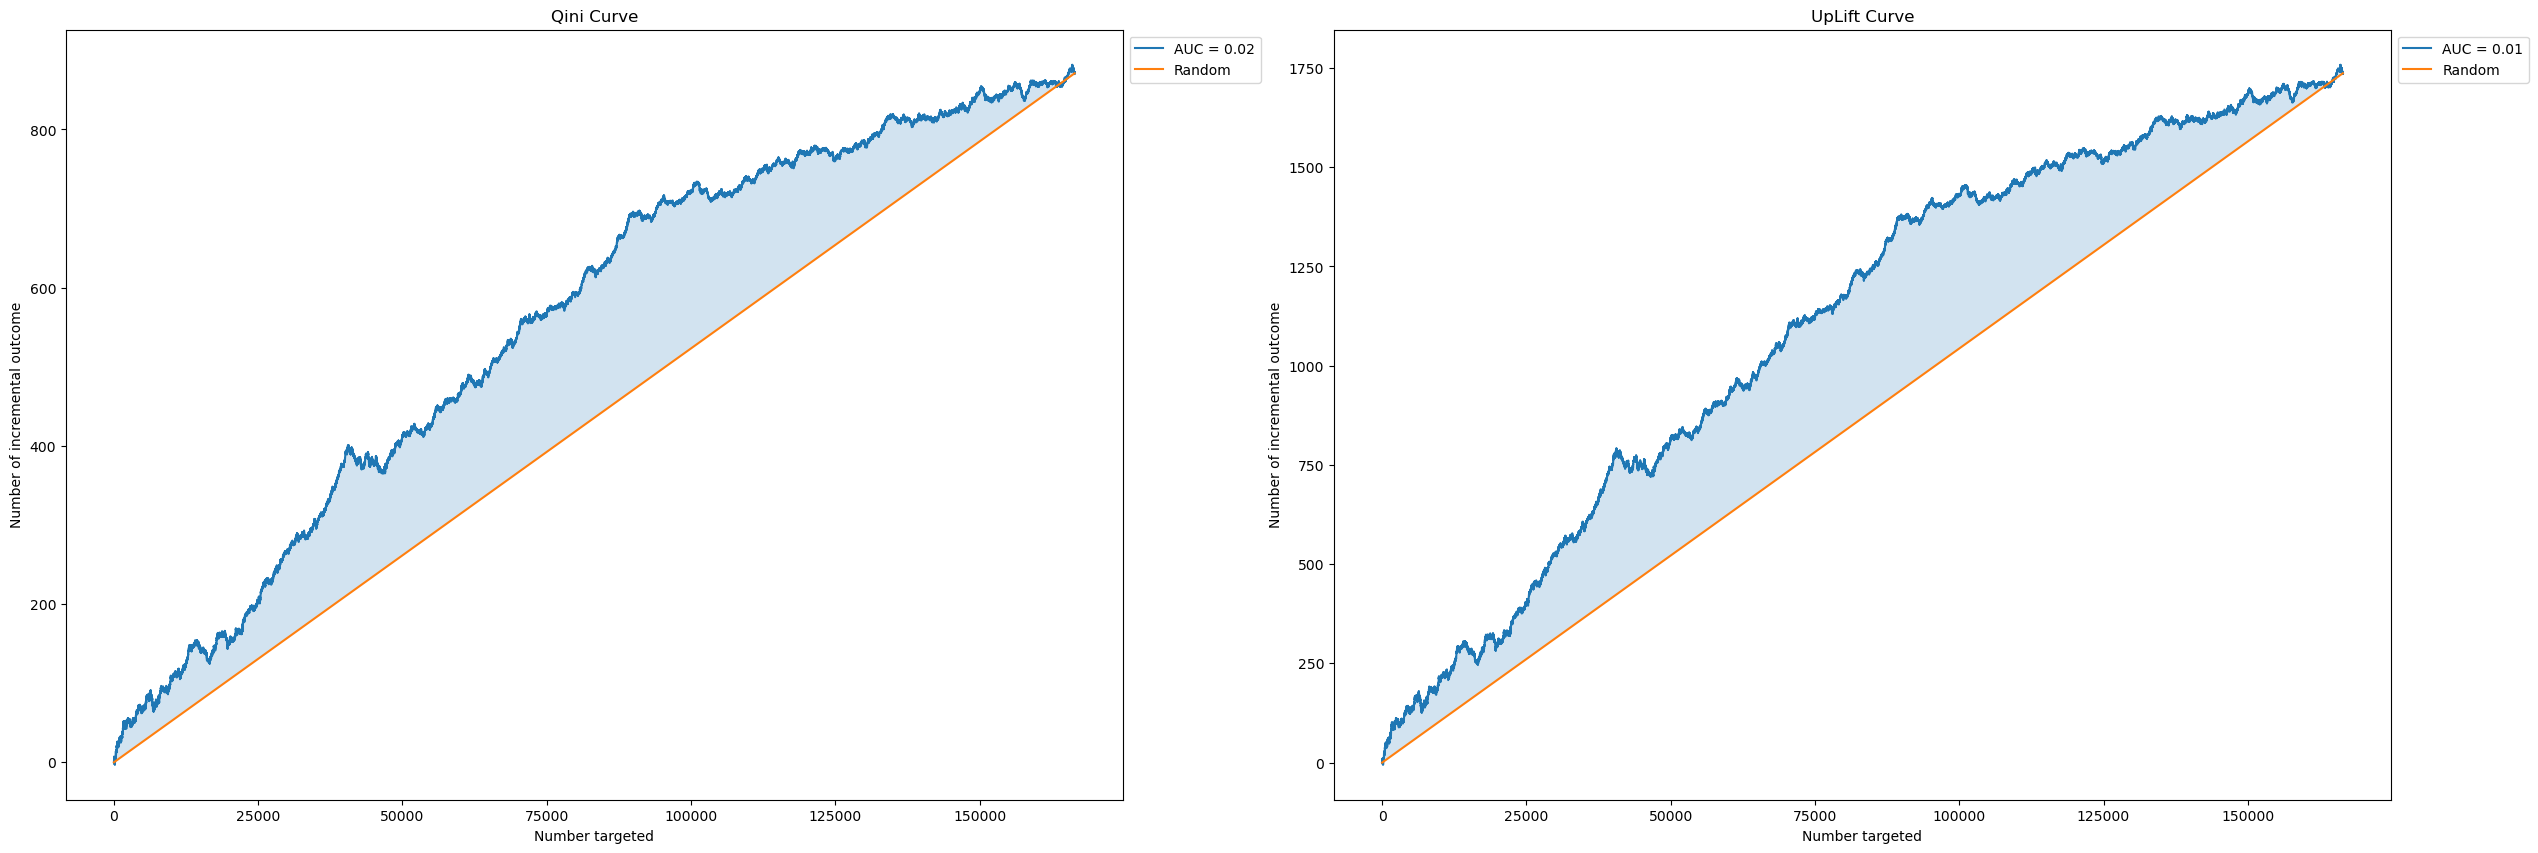

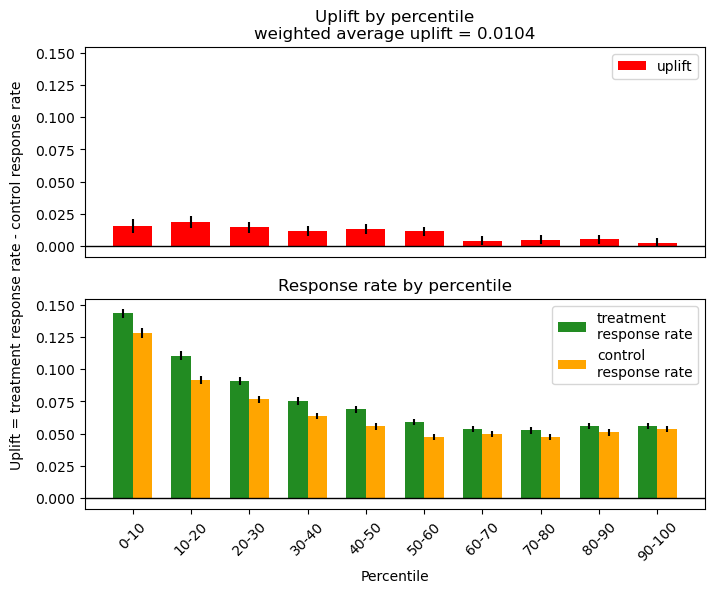

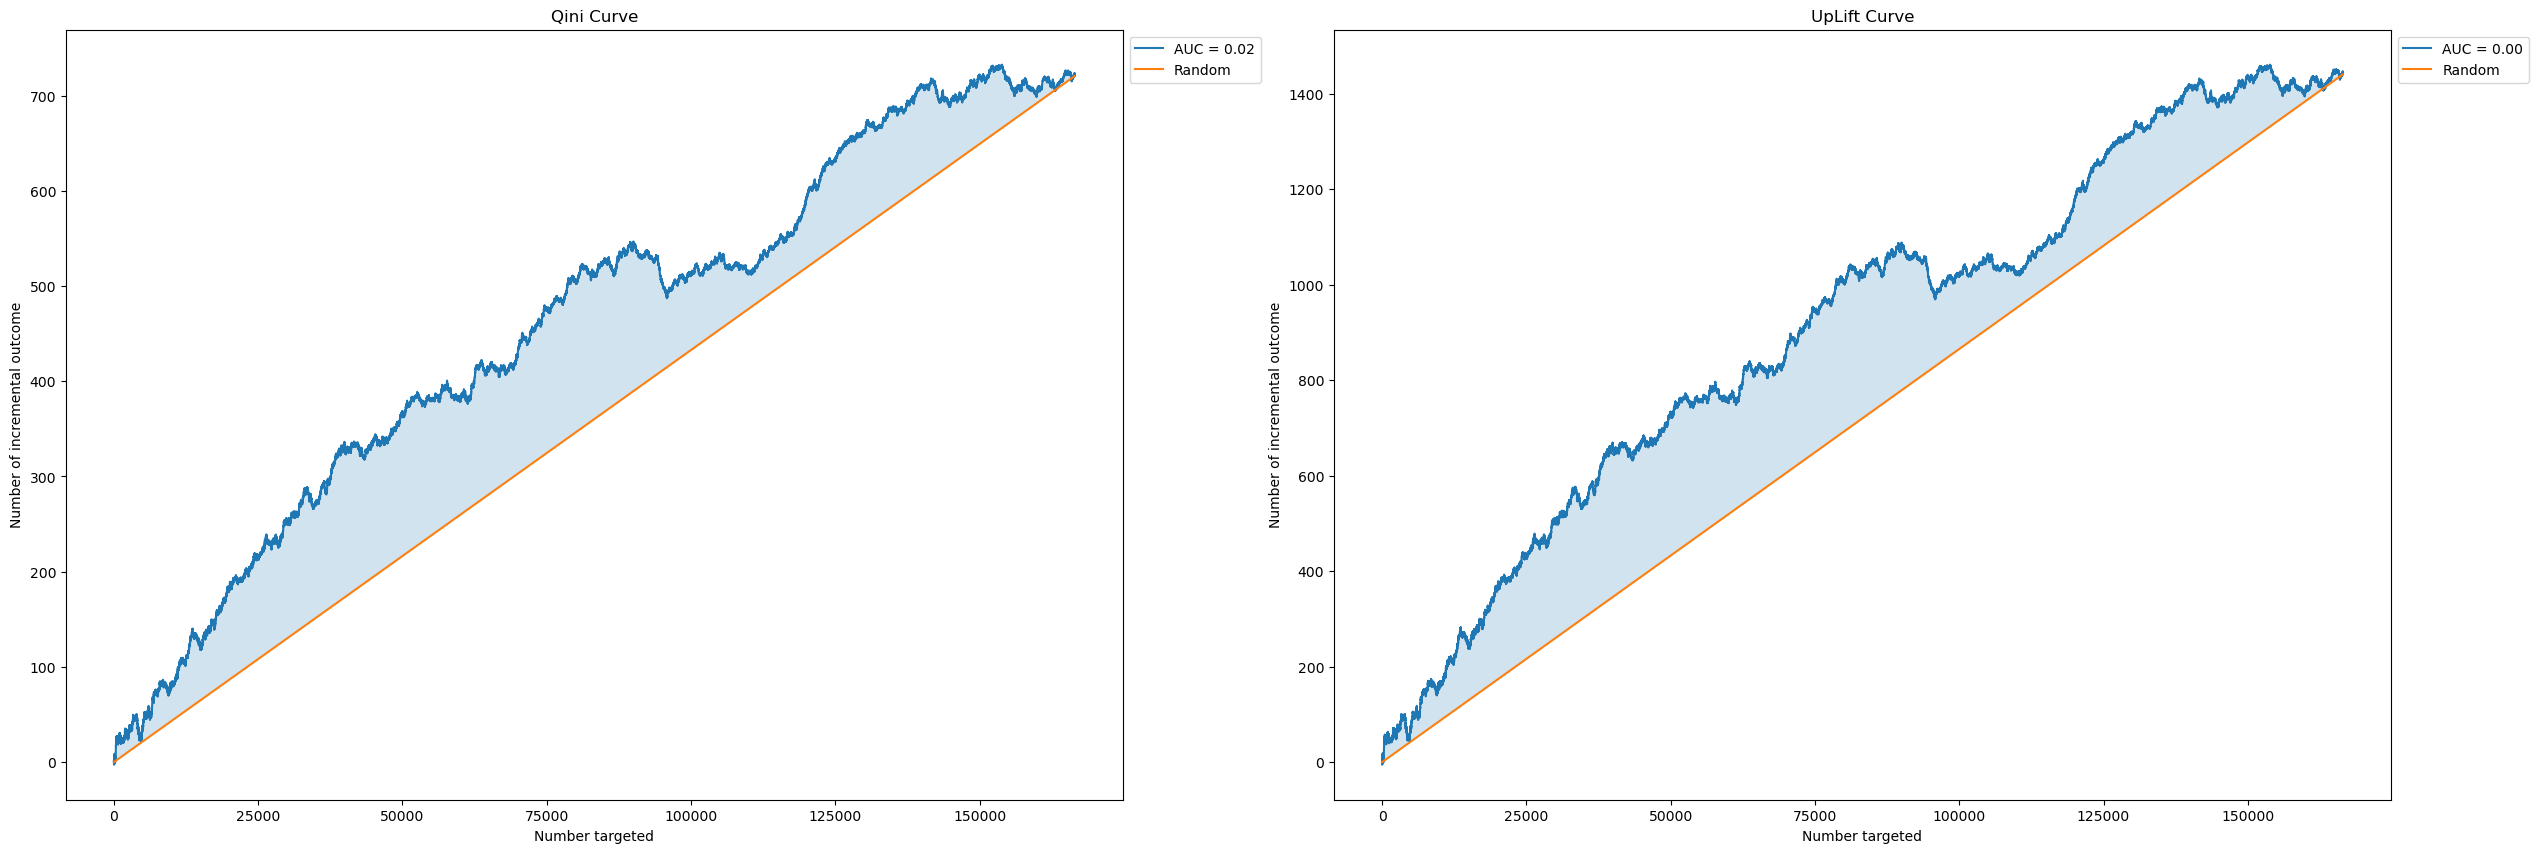

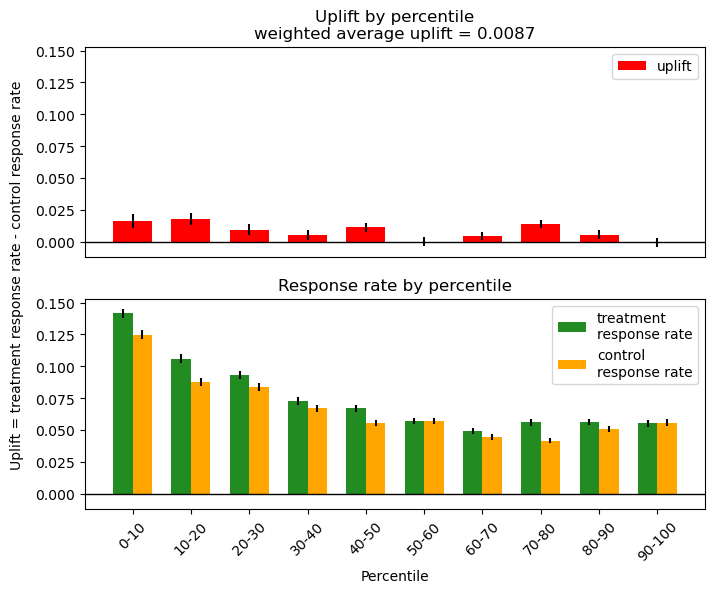

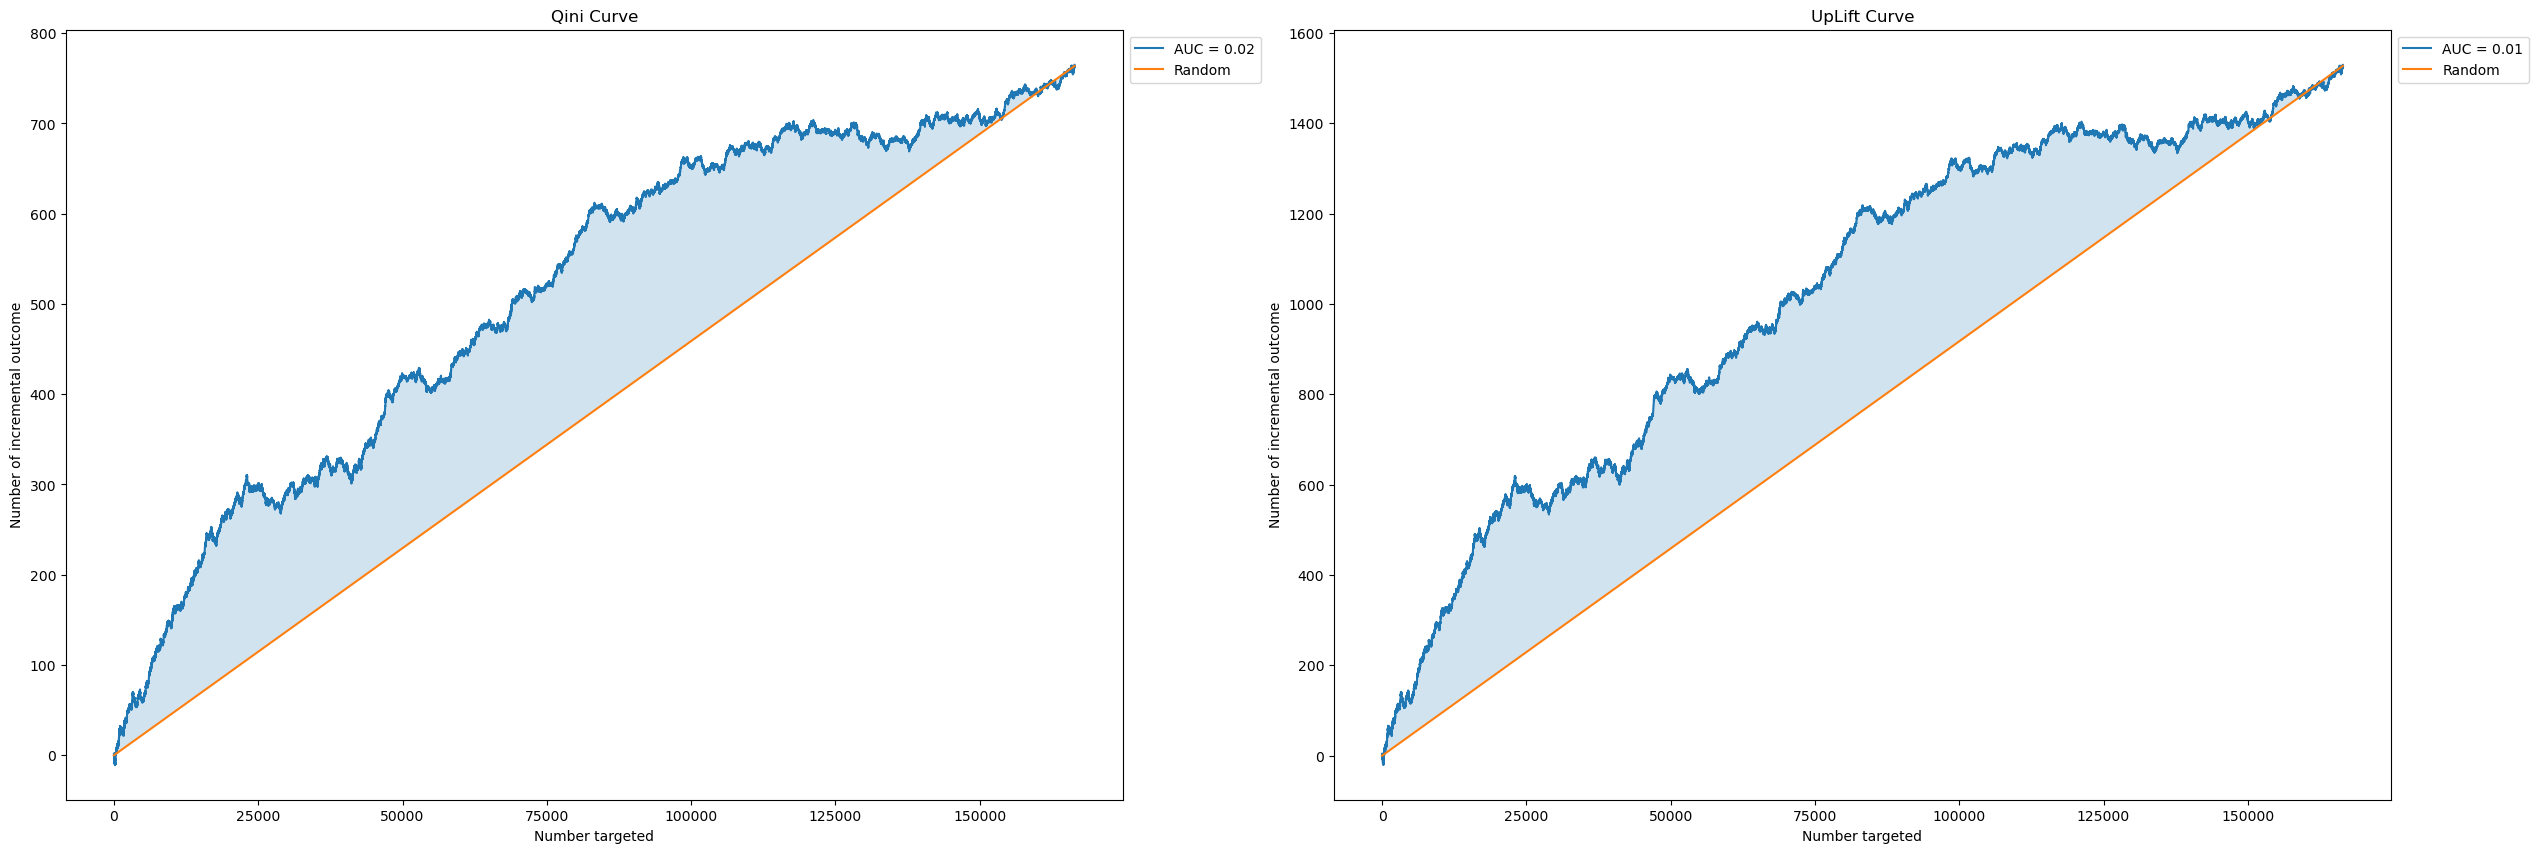

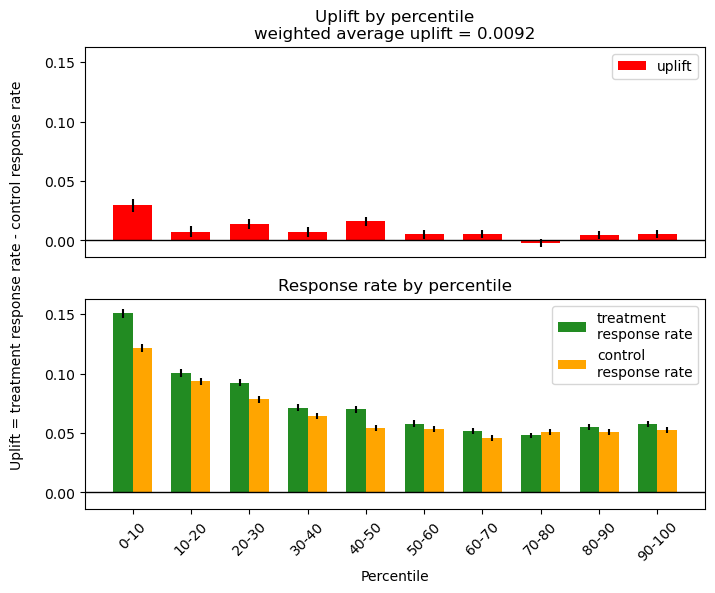

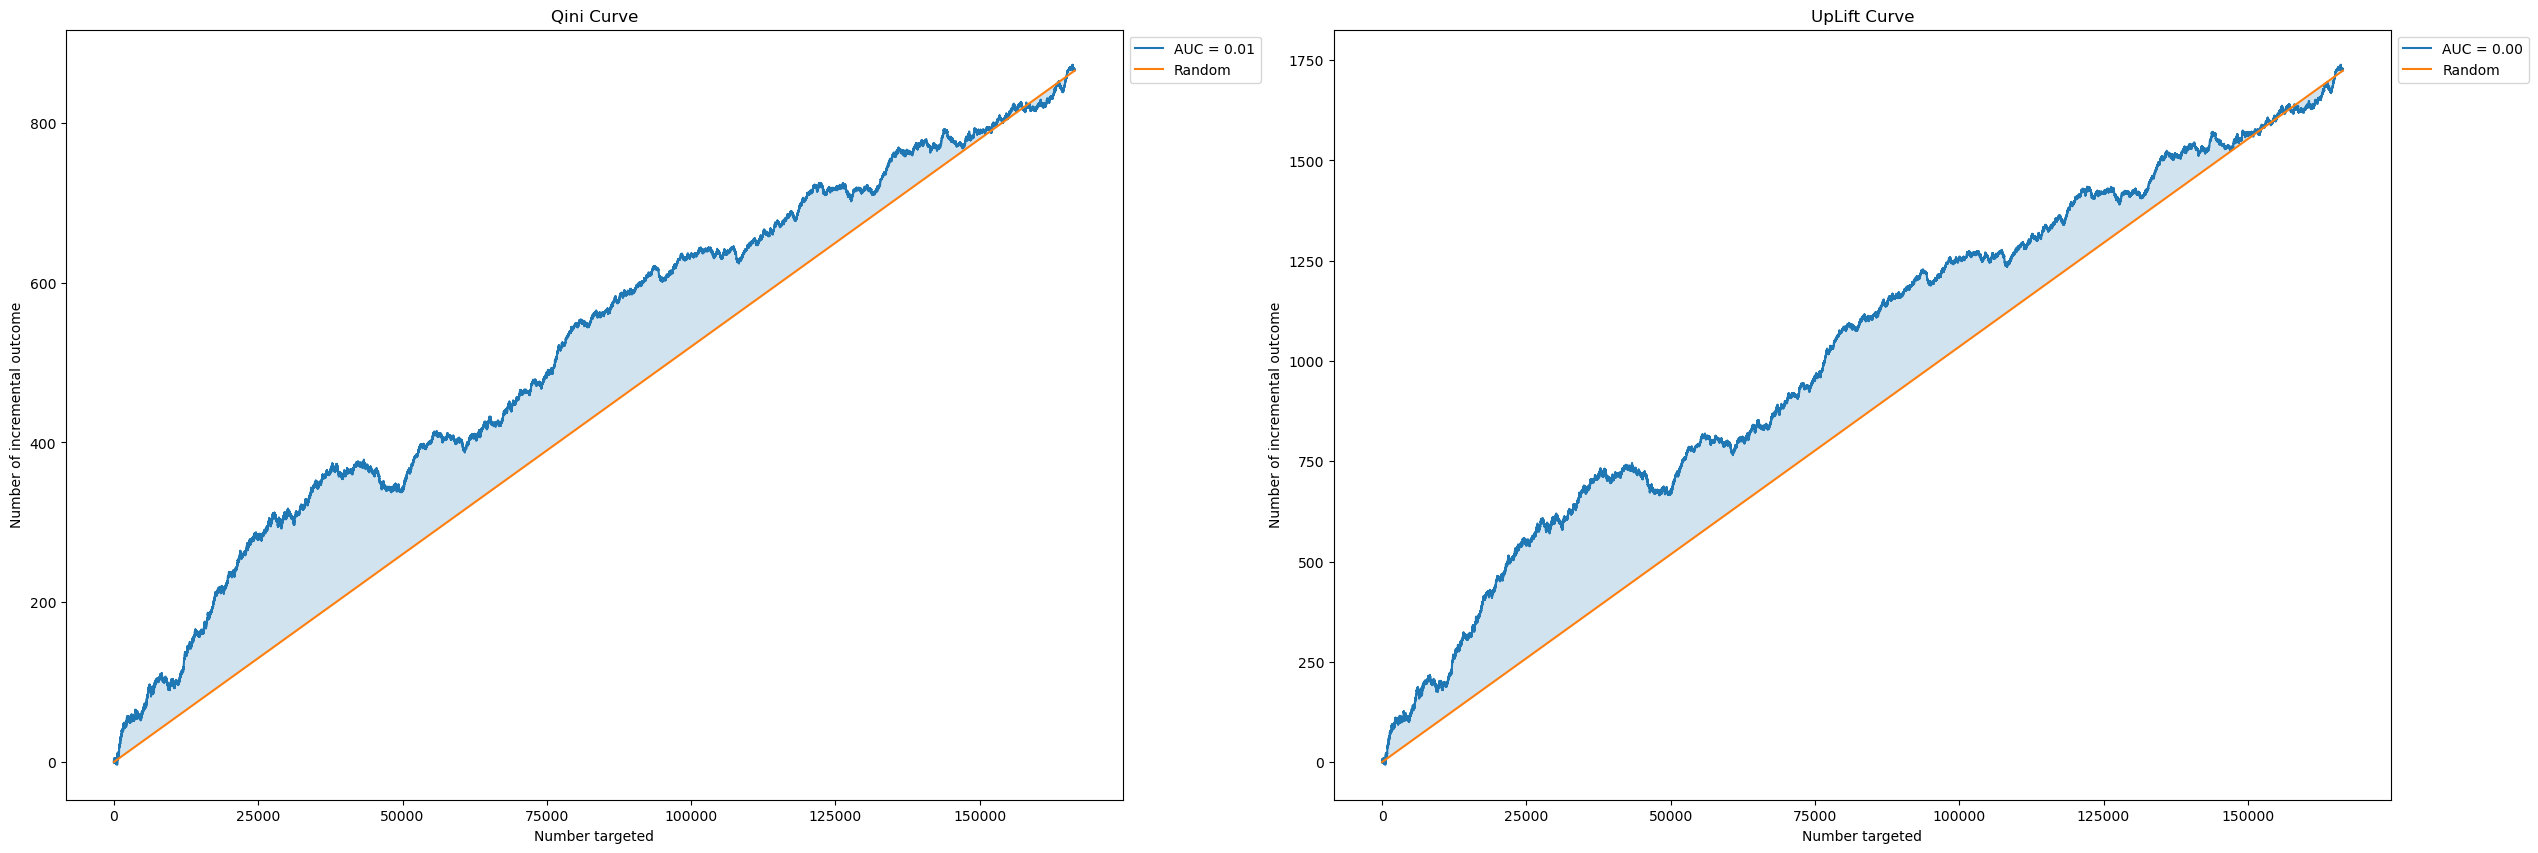

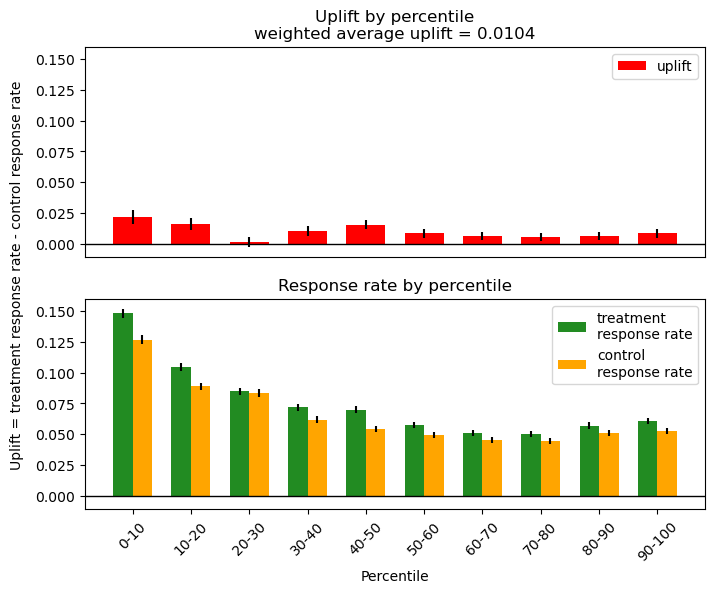

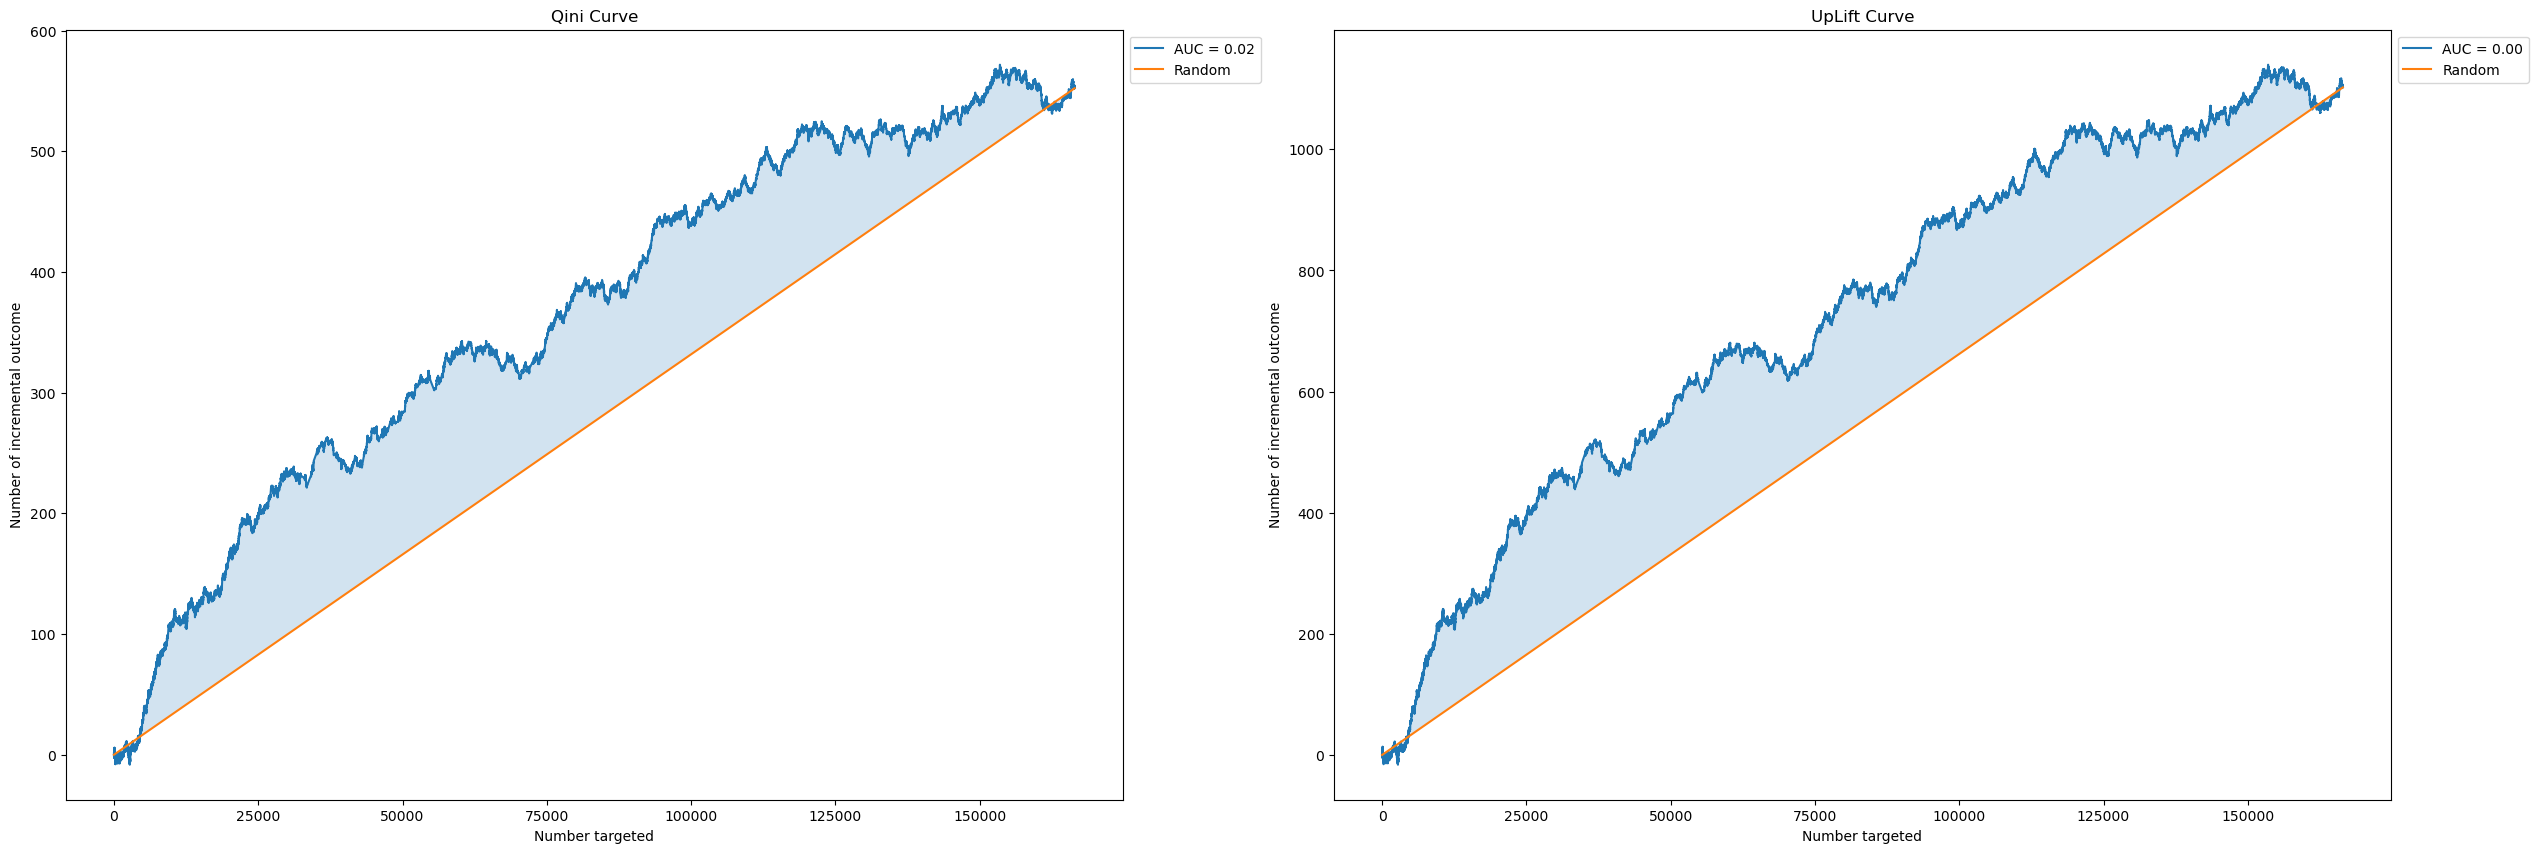

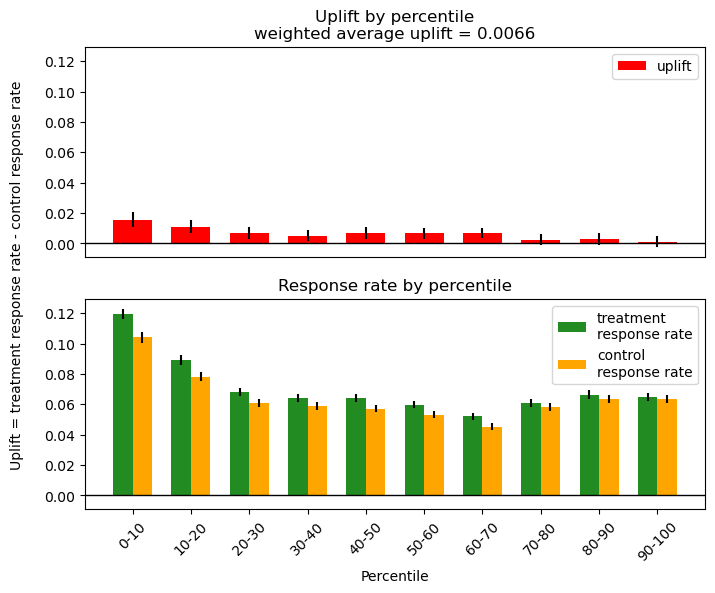

In [32]:
import copy
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      ctbst  = copy.deepcopy(automl.best_pipeline)
      ctbst.fit(X_train_, y_train_)
      y_pred = ctbst.predict(X_test_)
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')


# Применение библиотеки Scikit-Uplift в комбинации с CatBoost

In [33]:
from sklift.models import ClassTransformationReg
from sklearn.base import BaseEstimator

from sklearn.utils.multiclass import type_of_target
from sklearn.utils.validation import check_consistent_length

from sklift.utils import check_is_binary

In [34]:
import sklift
sklift.__version__

'0.5.1'

In [35]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU_without_norm(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


C:\Users\Kirill\AppData\Local\Temp\ipykernel_10136\900749741.py:1: DtypeWarning:

Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.



NewComer  SEGMENT_N_1  SEGMENT_N_2  SEGMENT_N_3  SEGMENT_N_4  \
7709046080         0            1            0            0            0   
7717101223         0            1            0            0            0   
7712715957         0            1            0            0            0   
7710968936         0            0            0            1            0   
7700742104         0            0            0            1            0   

            SEGMENT_N_5  SEGMENT_N_6  SEGMENT_N_8  SUB_EMAIL_Да  \
7709046080            0            0            0             1   
7717101223            0            0            0             1   
7712715957            0            0            0             0   
7710968936            0            0            0             1   
7700742104            0            0            0             1   

            SUB_EMAIL_Нет  Тип карты_Без возможности оплаты  \
7709046080              0                                 0   
7717101223              0                                 0   
7712715957              1                                 0   
7710968936              0                                 0   
7700742104              0                                 0   

            Тип карты_Как карточное платежное средство  \
7709046080                                           1   
7717101223                                           1   
7712715957                                           1   
7710968936                                           1   
7700742104                                           1   

            Канал регистрации_Ecomm  Канал регистрации_Розница   AGE  lftm  \
7709046080                        1                          0  16.0    23   
7717101223                        1                          0  36.0    90   
7712715957                        1                          0  32.0    98   
7710968936                        1                          0  33.0    60   
7700742104                        1                          0  35.0    88   

             AMOUNT  ORDERS          AOV  lftm_after_purch       LTV_1M  \
7709046080   413.15     1.0   413.150000              23.0   413.150000   
7717101223  1206.00     1.0  1206.000000              89.0   402.000000   
7712715957   274.10     1.0   274.100000              21.0   274.100000   
7710968936  2454.00     1.0  2454.000000               8.0  2454.000000   
7700742104  1280.00     3.0   426.666666              84.0   426.666666   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7709046080      1.000000        5.0      300.0           -295.0   
7717101223      0.333333       15.0      500.0           -485.0   
7712715957      1.000000        3.0        0.0              0.0   
7710968936      1.000000       27.0      500.0           -473.0   
7700742104      1.000000      514.0      921.0           -407.0   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7709046080             5.0             0.0                0.0   
7717101223            15.0             0.0                0.0   
7712715957             3.0             0.0                0.0   
7710968936            27.0             0.0                0.0   
7700742104           514.0           421.0                0.0   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7709046080              300.0             0.0            5.0   
7717101223              500.0             0.0           15.0   
7712715957                0.0             0.0            3.0   
7710968936              500.0             0.0           27.0   
7700742104              500.0             0.0           14.0   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus  AVG_USE_BONUS  \
7709046080                  0.0                 5.0          300.0   
7717101223                  0.0                15.0          500.0   
7712715957                  0.0                 3.0            0.0   
7710968936                  0.0              

target  treat
7709046080       0      0
7717101223       0      0
7712715957       1      0
7710968936       0      0
7700742104       0      0

[[0.       1.       0.       ... 0.420668 0.       0.420668]
 [0.       1.       0.       ... 0.293083 0.       0.293083]
 [0.       1.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]]
[-0.         -0.         -2.00406899 ...  0.         -0.
  0.        ]
0.5010151832976517


Split 1; WAU = 0.01013117505191248; UpLift 30% = 0.016605729890134827


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 2; WAU = 0.008596878255502502; UpLift 30% = 0.014671010023493594


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 3; WAU = 0.009086305731958712; UpLift 30% = 0.016876180205748464


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 4; WAU = 0.009933603321746214; UpLift 30% = 0.014134393194294978


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Split 5; WAU = 0.006532142486610781; UpLift 30% = 0.011566816489258502


c:\Users\Kirill\.conda\envs\automl\lib\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Mean WAU = 0.0089; Mean UpLift 30% = 0.0148


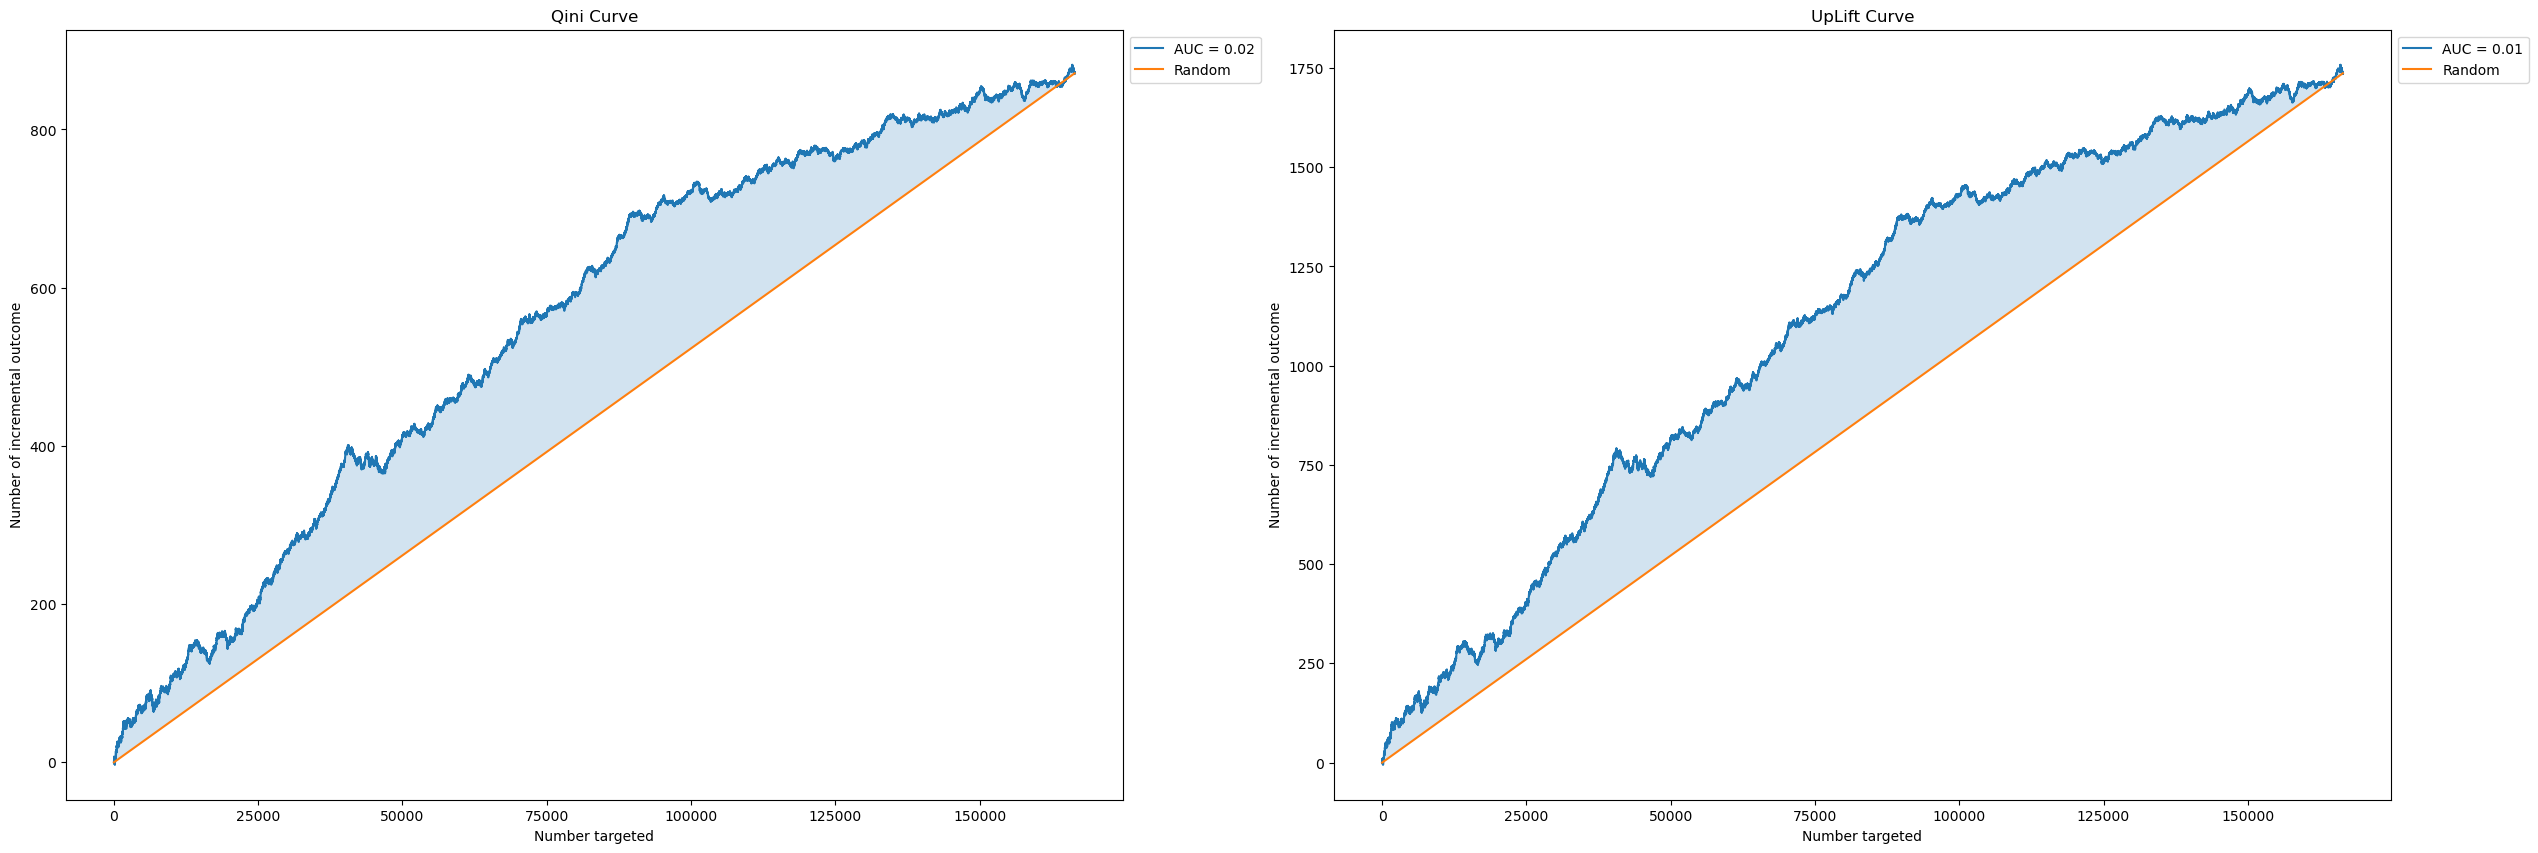

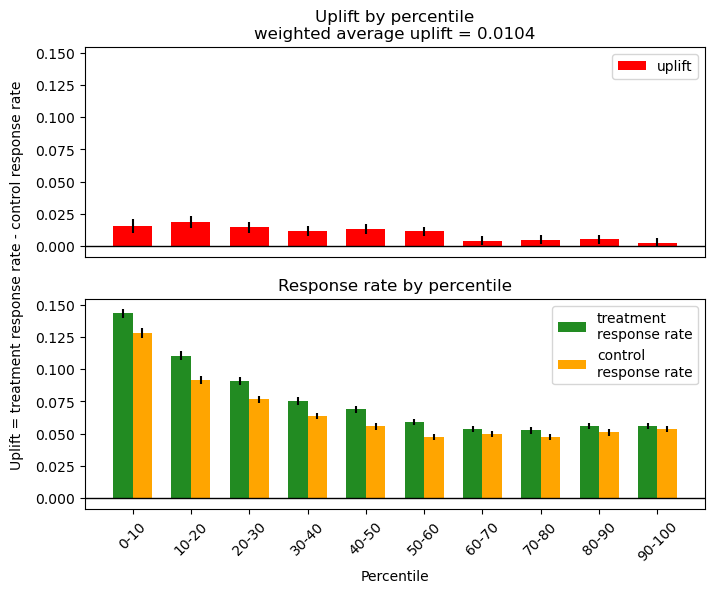

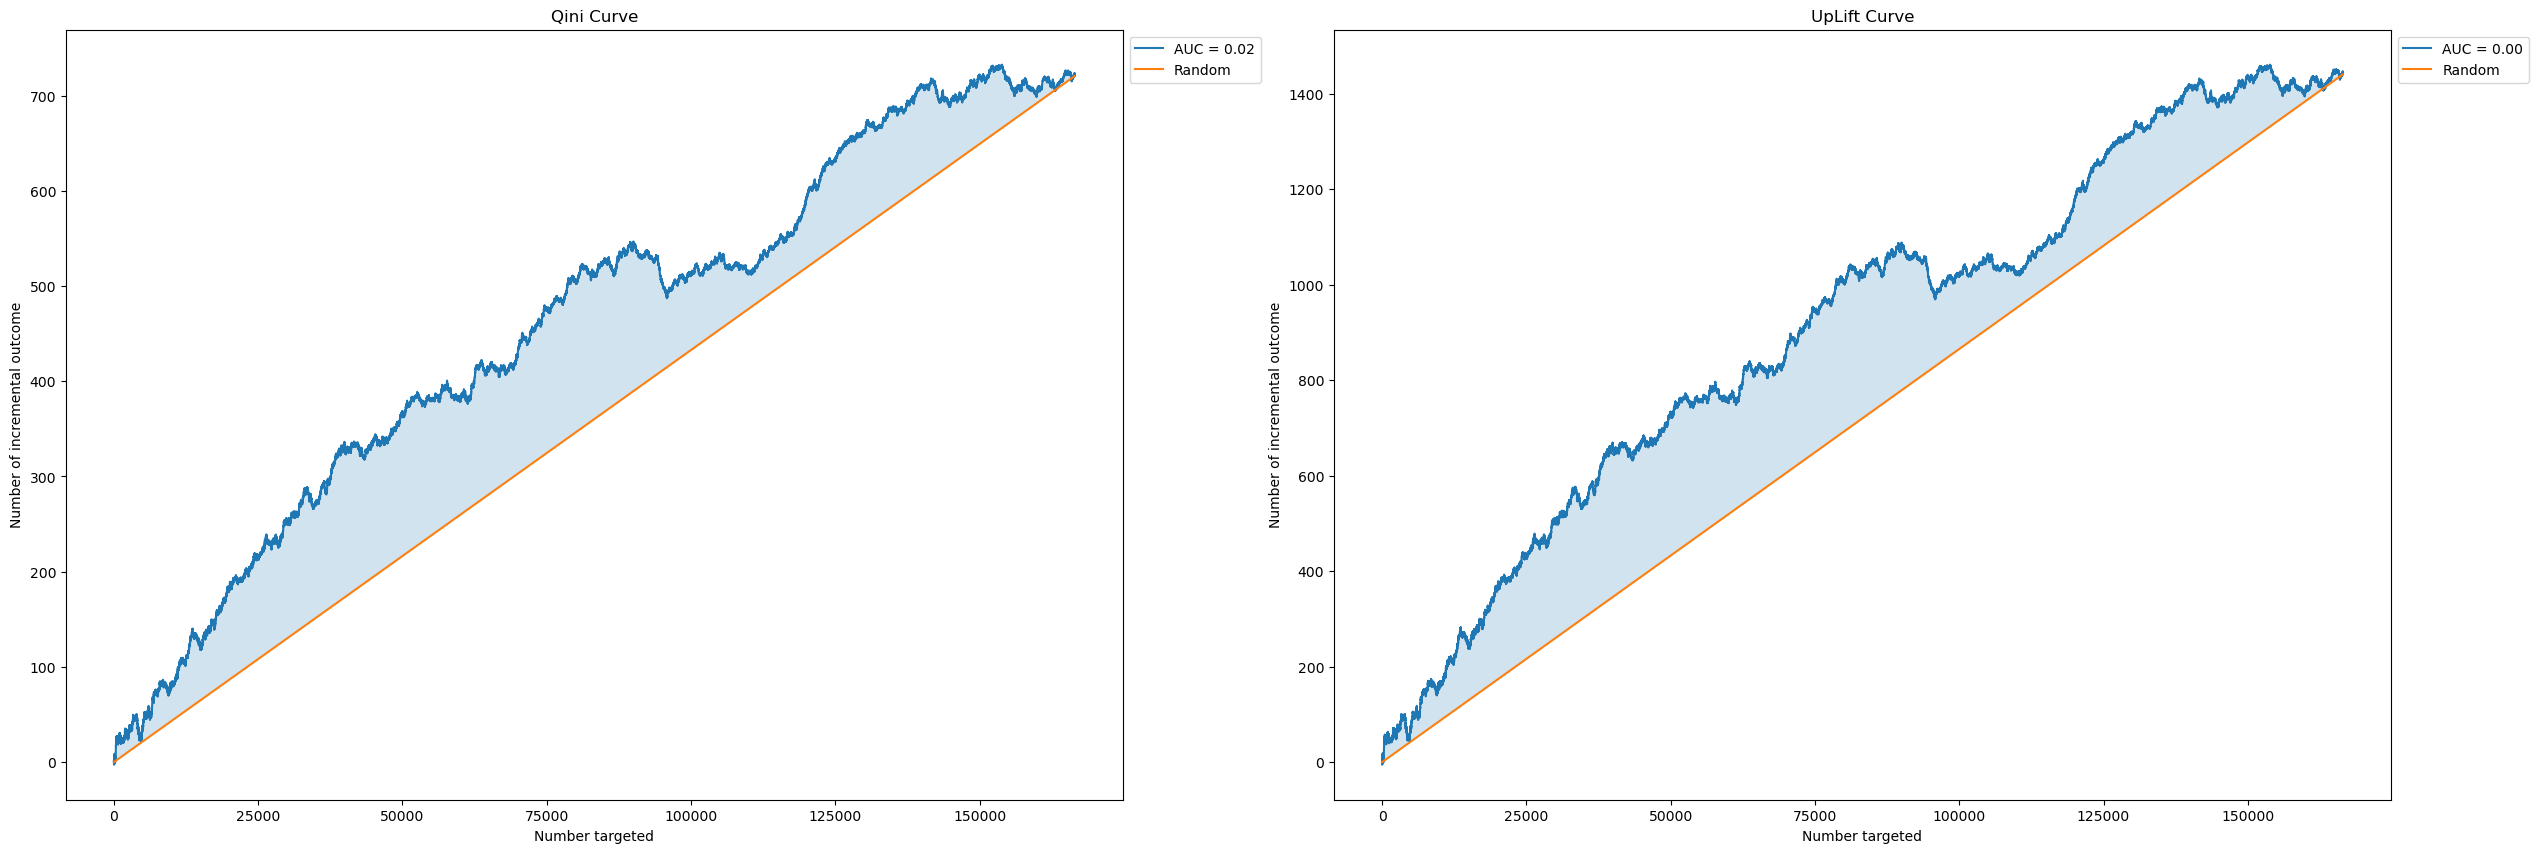

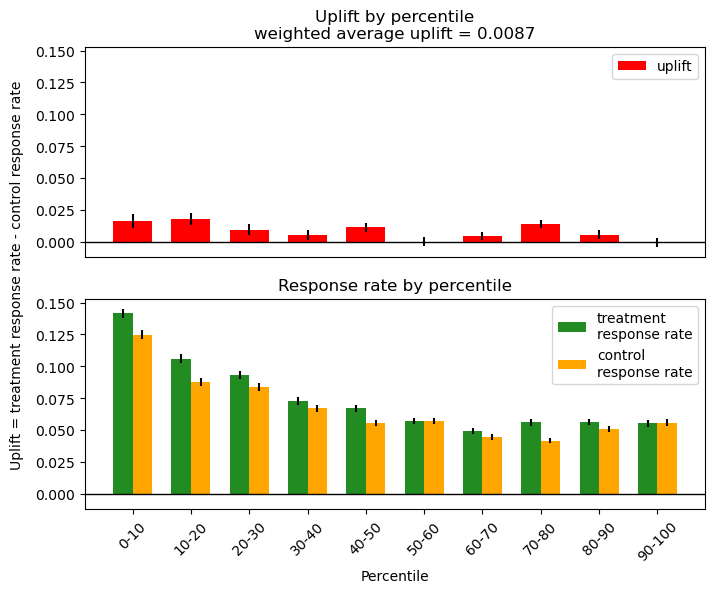

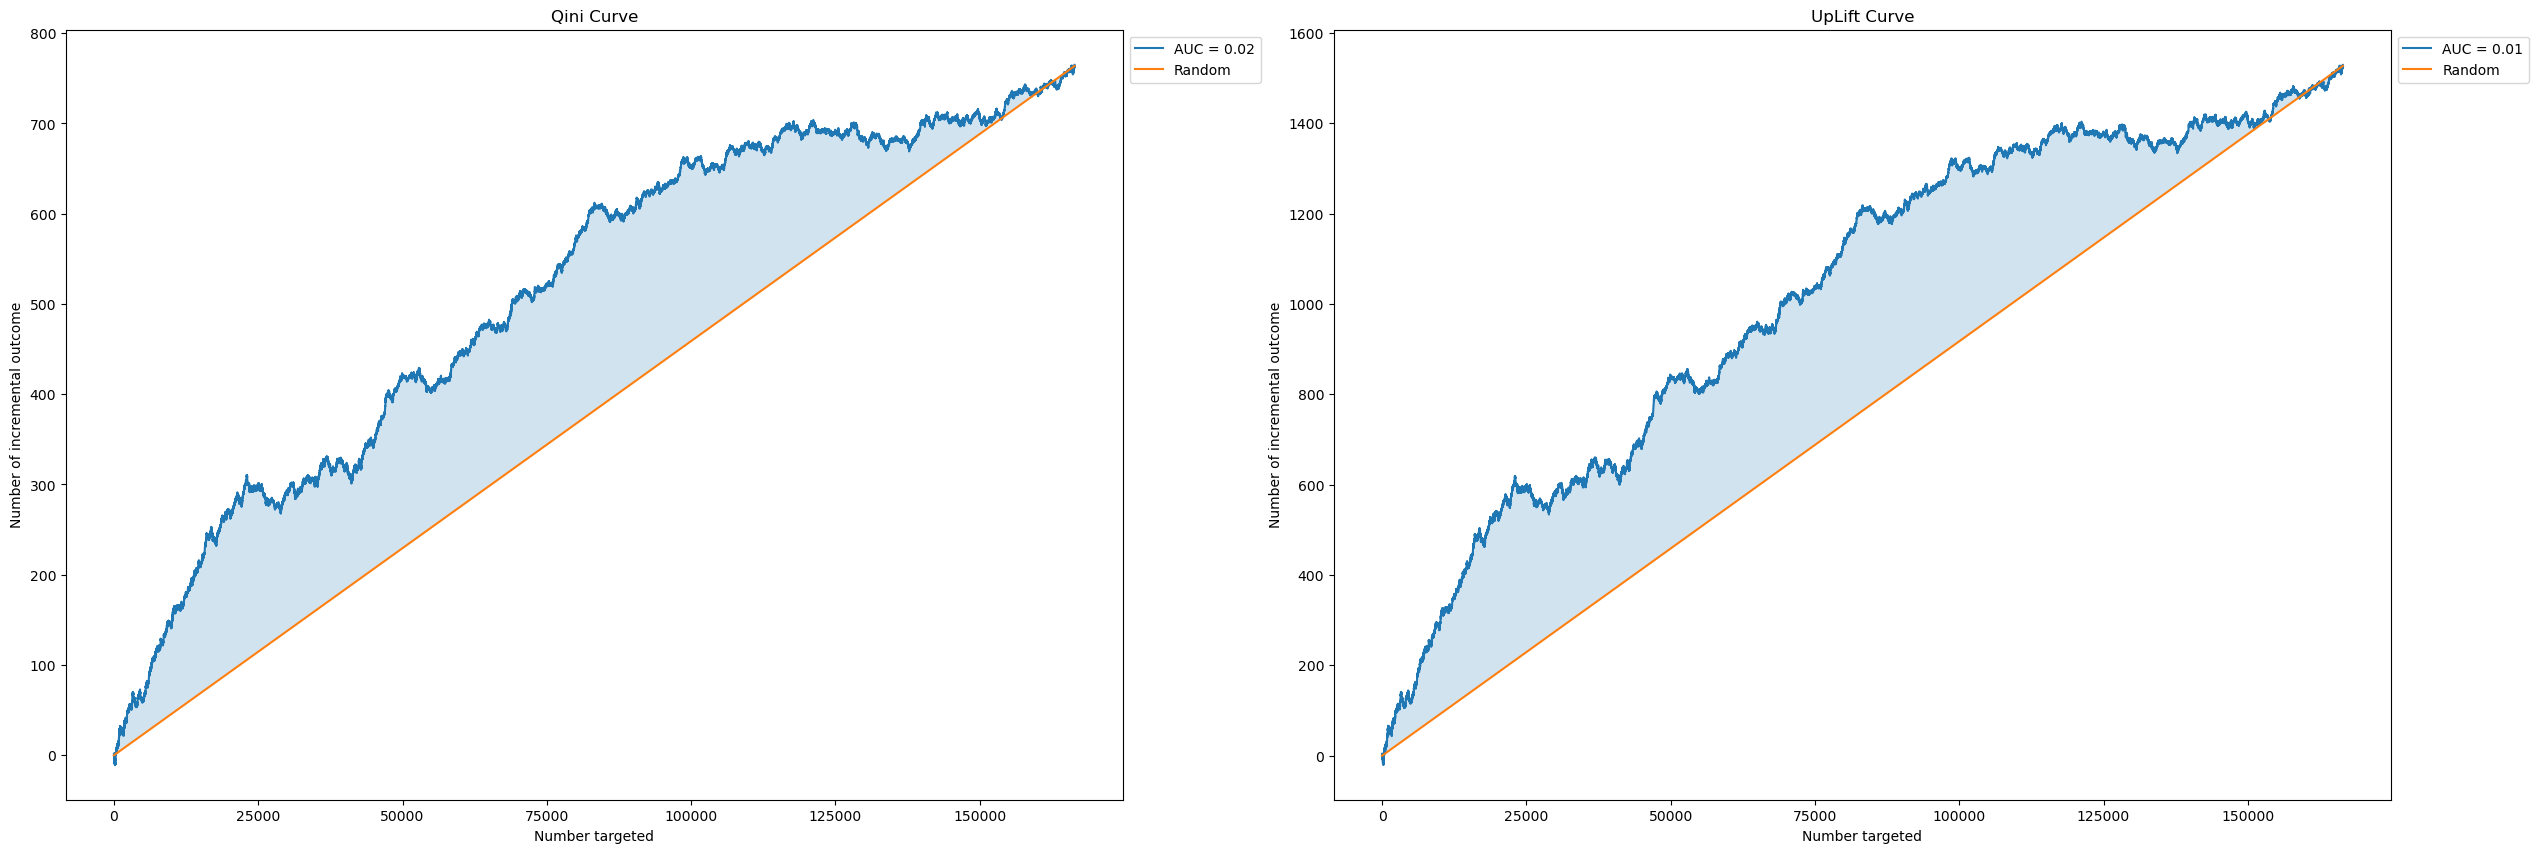

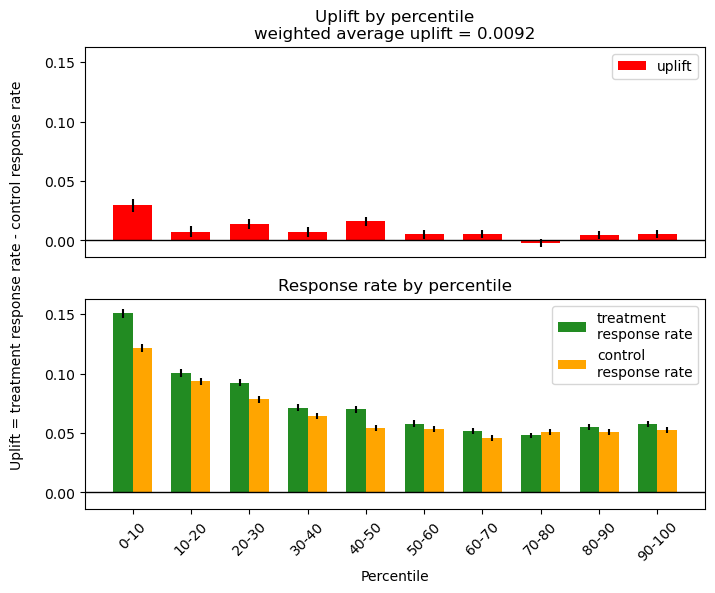

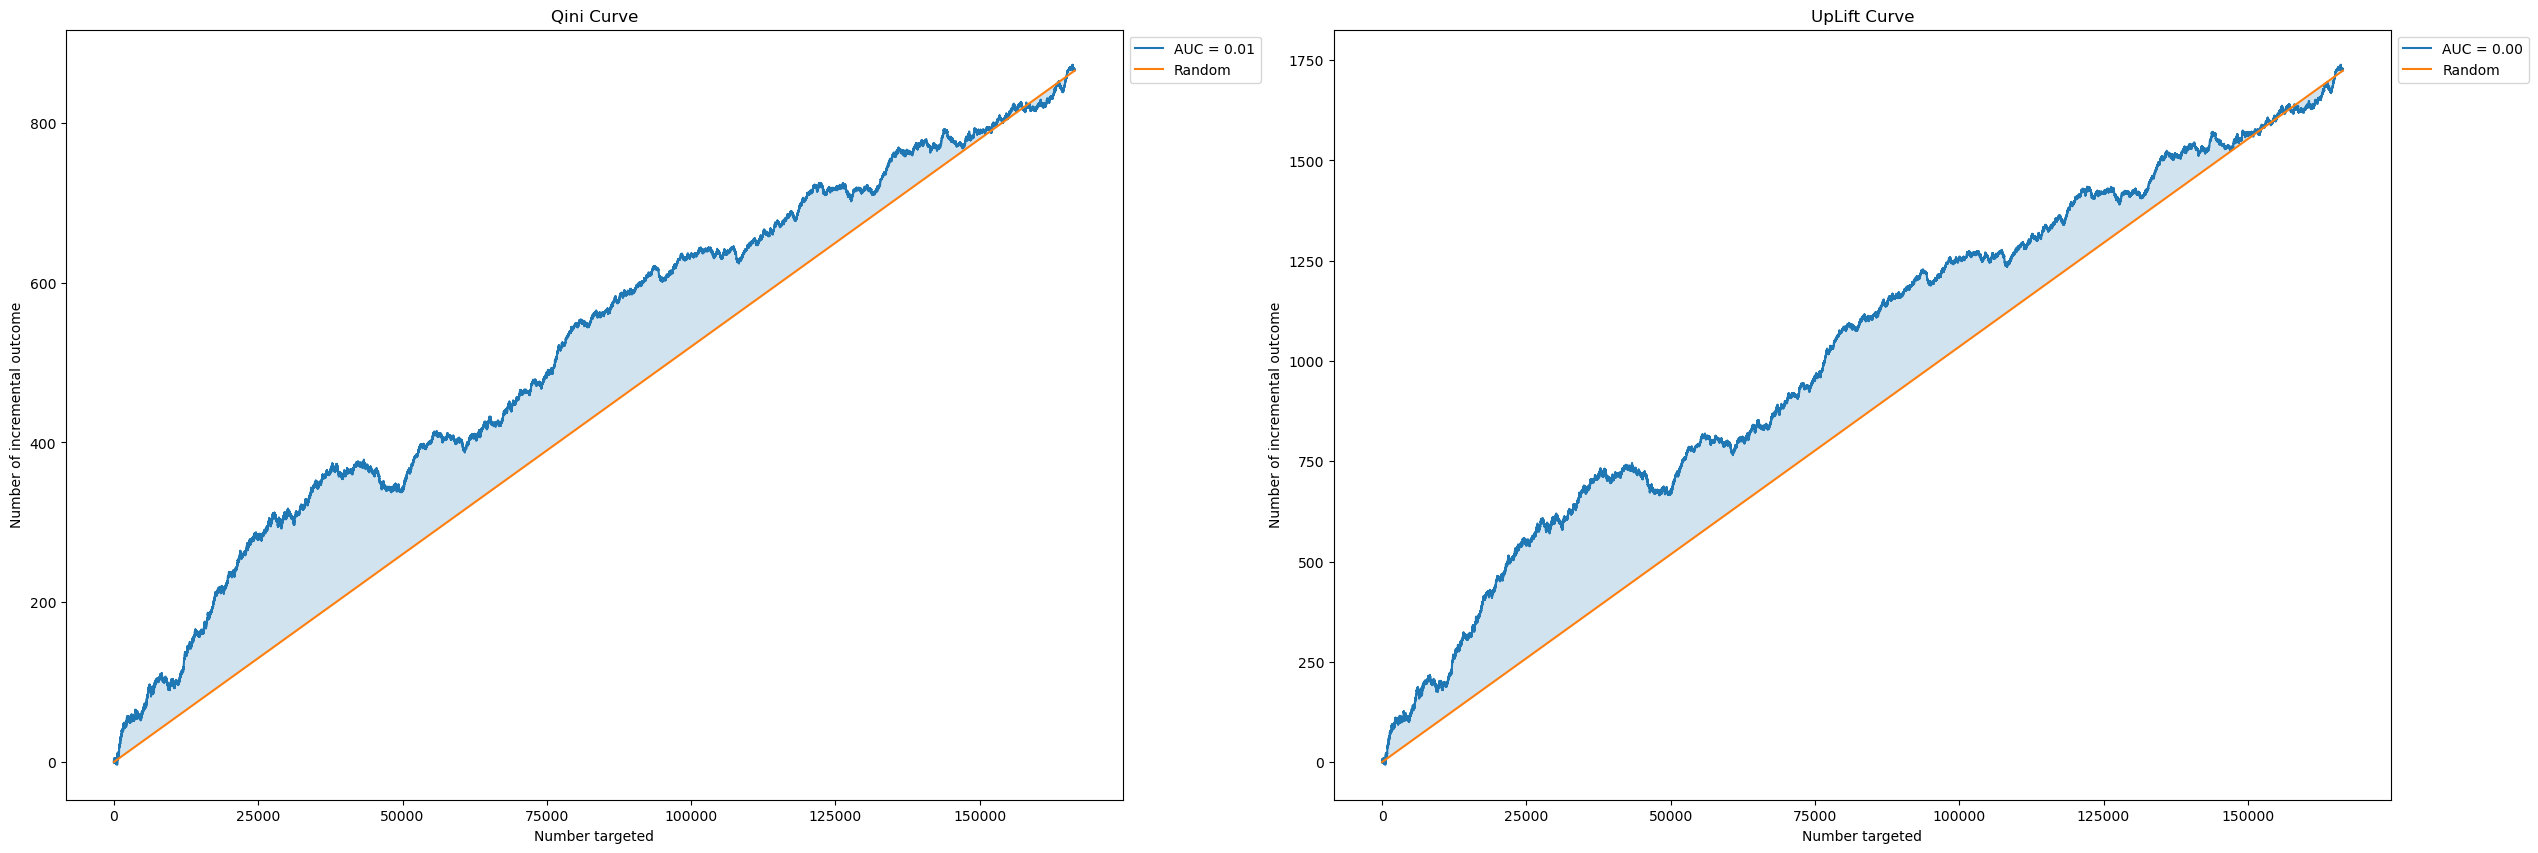

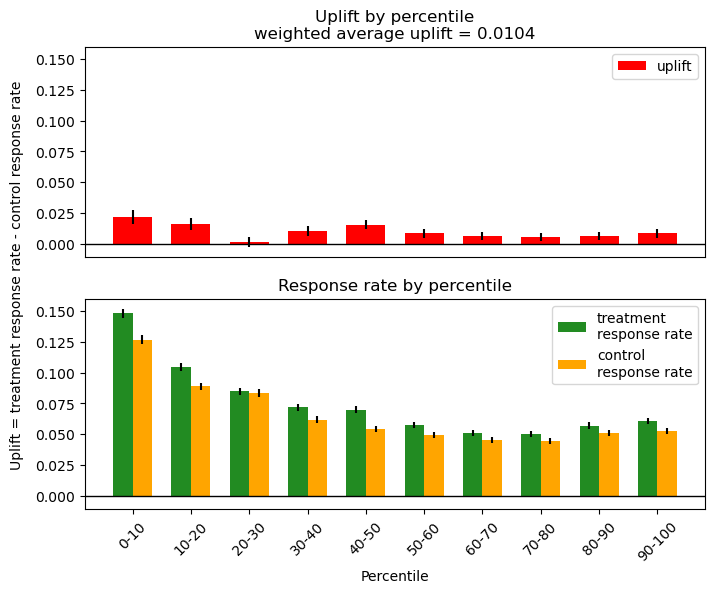

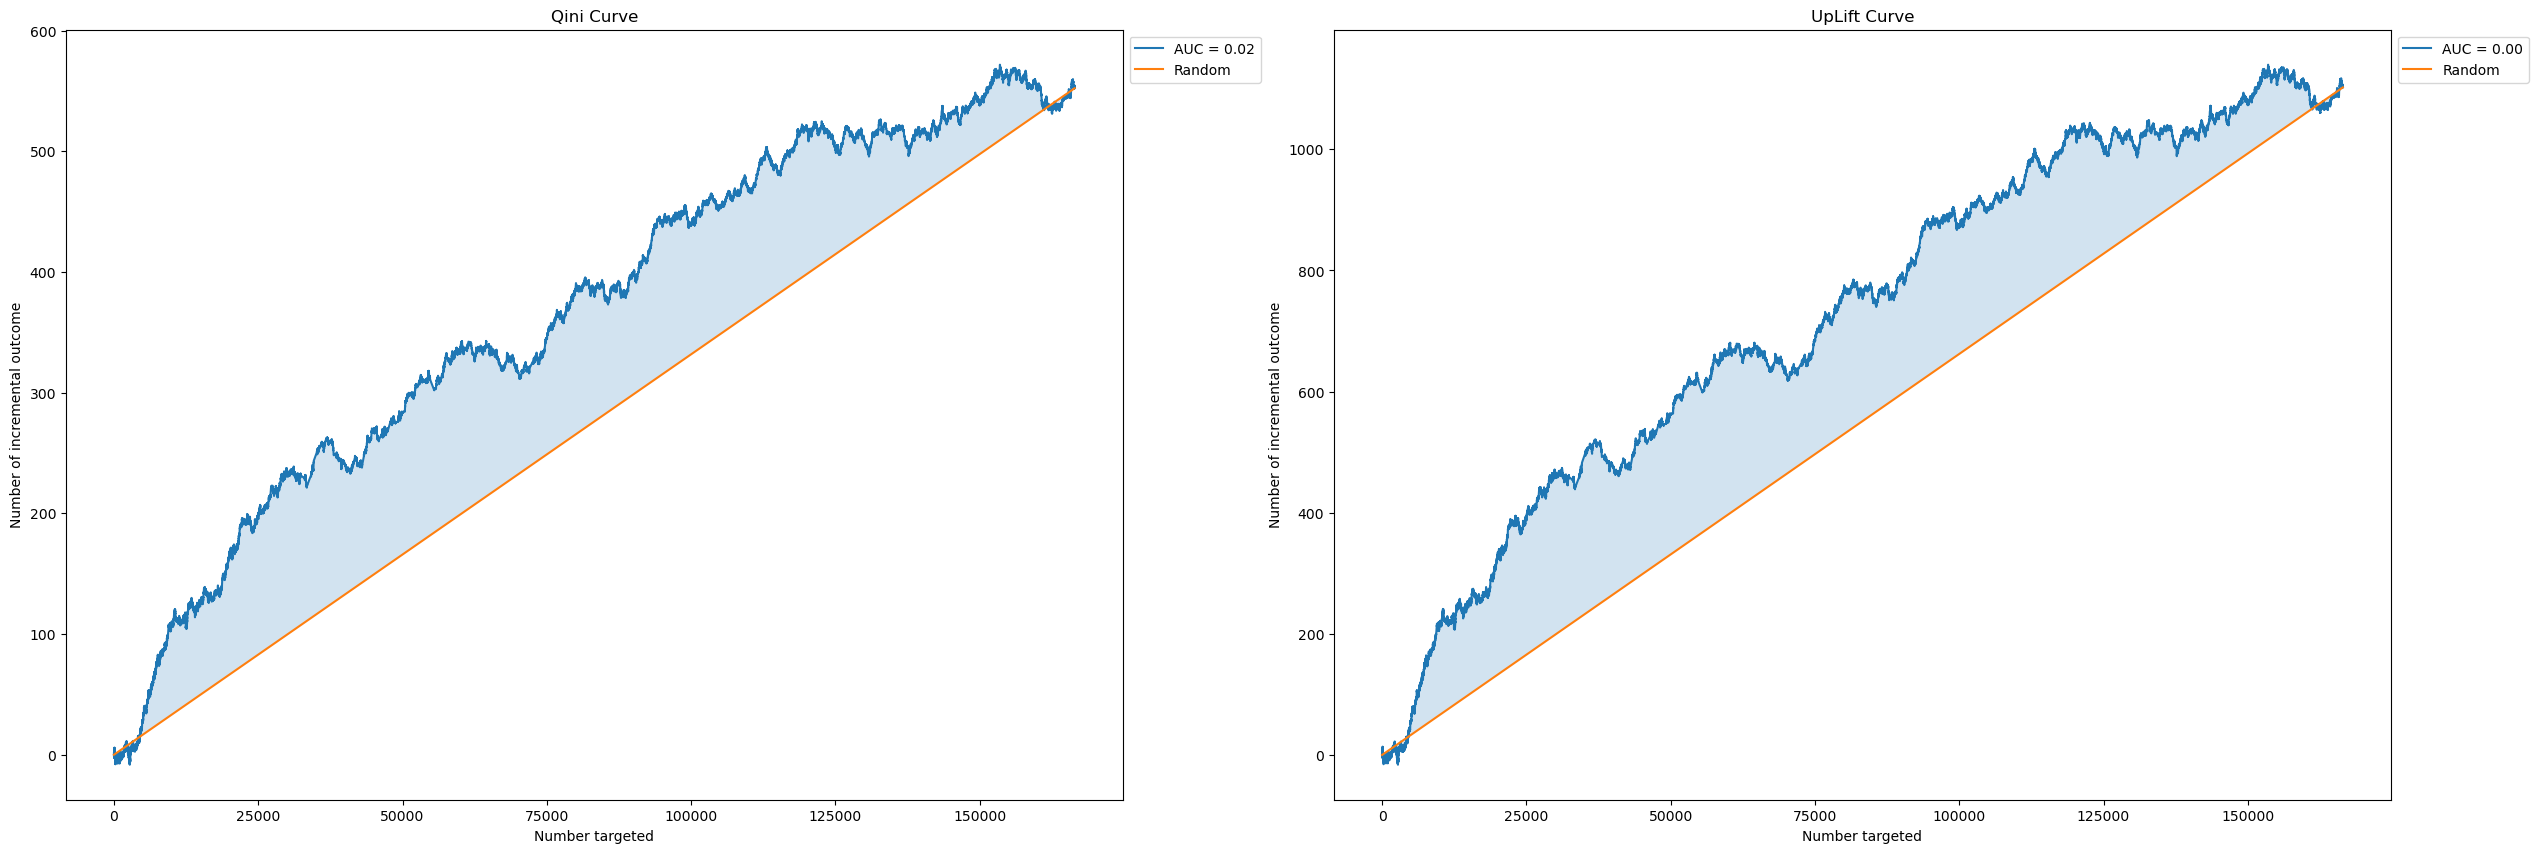

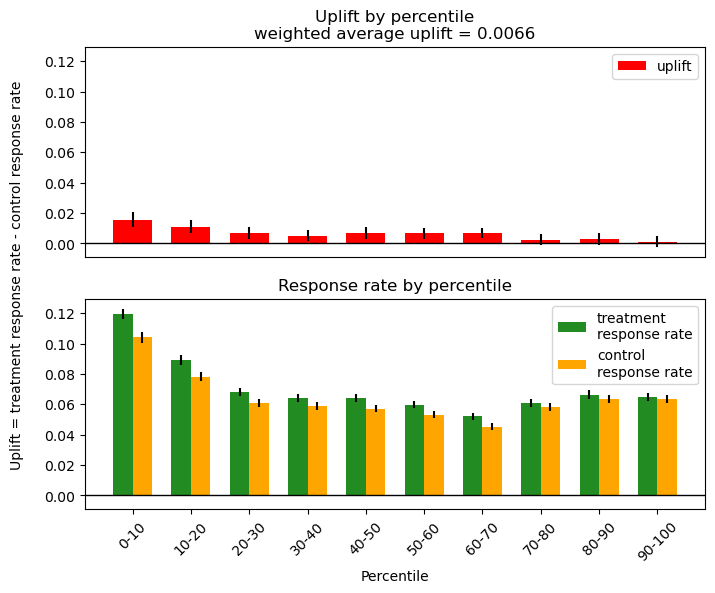

In [36]:
%matplotlib inline
import copy
# Метод двух моделей
#Default data
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0


# grid = { 'max_depth':2,
#     'learning_rate': 0.2, 
#     'n_estimators': 100,}

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      ctbst  = copy.deepcopy(automl.best_pipeline)
      ctbst = ClassTransformationReg(estimator=ctbst, propensity_val=p)
      ctbst.fit(X = X_train_, y = targ[train_index], treatment= treat[train_index])
      y_pred = ctbst.predict(X_test_)
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift 30% = {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"Plots/Regression model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index], uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"Plots/Regression model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')
